In [1]:
import pandas as pd
import numpy as np
import fit_curves 
import warnings
from plotnine.exceptions import PlotnineWarning
from fit_curves import *
county_map={
    "Tippecanoe": "Tippecanoe County","White":"White County","Dubois":"Dubois County","Ripley": "Ripley County","Hamilton": "Hamilton County","Gibson": "Gibson County","Vigo": "Vigo County",
    "Grant": "Grant County","Randolph": "Randolph County","Hendricks": "Hendricks County","Lawrence": "Lawrence County","Decatur": "Decatur County",
    "Whitley": "Whitley County","Clay": "Clay County","Henry": "Henry County","Porter": "Porter County","Jennings": "Jennings County","Knox": "Knox County",
    "Benton": "Benton County","Blackford": "Blackford County","Pulaski": "Pulaski County","Clinton": "Clinton County","Lake": "Lake County","Carroll": "Carroll County",
    "Adams": "Adams County","Marshall": "Marshall County","Elkhart": "Elkhart County","Madison": "Madison County","Johnson": "Johnson County","Jasper": "Jasper County",
    "Cass": "Cass County","Vanderburgh": "Vanderburgh County","Shelby": "Shelby County","La Porte": "Laporte County","Miami": "Miami County"
}

region3_map = {

    "Jasper County": "NC", "Lake County": "NC", "Laporte County": "NC", "Newton County": "NC", "Porter County": "NC", "Pulaski County": "NC", "Starke County": "NC", "White County": "NC",
    "Kosciusko County":"NC","Wabash County":"NC","St Joseph County":"NC","Cass County": "NC", "Fulton County": "NC", "Howard County": "C", "Miami County": "NC", "Tippecanoe County": "NC", "Tipton County": "C", "Carroll County": "NC", "Clinton County": "C","Marshall County":"NC","Elkhart County":"NC",
    "Adams County": "NE", "Allen County": "NE", "Dekalb County": "NE", "Huntington County": "NE", "Lagrange County": "NE", "Noble County": "NE", "Steuben County": "NE", "Wells County": "NE", "Whitley County": "NE",
    "Benton County": "NC", "Fountain County": "NC", "Montgomery County": "NC", "Parke County": "NC", "Putnam County": "NC", "Vermillion County": "NC", "Warren County": "NC","Vigo County": "NC","Clay County": "NC",
    "Boone County": "C", "Hamilton County": "C", "Hancock County": "C", "Hendricks County": "C", "Johnson County": "C", "Madison County": "C", "Marion County": "C", "Morgan County": "C", "Shelby County": "C",
    "Blackford County": "NE","Union County": "NE","Fayette County": "NE", "Delaware County": "NE", "Grant County": "C", "Henry County": "NE", "Jay County": "NE", "Randolph County":"NE","Rush County":"C","Wayne County":"NE",    
    "Daviess County": "NC", "Sullivan County": "NC","Gibson County": "NC", "Knox County": "NC", "Perry County": "NC", "Pike County": "NC", "Posey County": "NC", "Spencer County": "NC", "Vanderburgh County": "NC", "Warrick County": "NC",
    "Brown County": "NC", "Crawford County": "NC", "Dubois County": "NC", "Greene County": "NC", "Lawrence County": "NC", "Martin County": "NC", "Monroe County": "NC", "Orange County": "NC", "Owen County": "NC", "Washington County": "NC",
    "Bartholomew County": "C", "Clark County": "NC", "Decatur County": "C", "Dearborn County": "NC", "Floyd County": "NC", "Franklin County": "NC", "Harrison County": "NC", "Jackson County": "NC", "Jefferson County": "NC", "Jennings County": "NC", "Ohio County": "NC", "Ripley County": "NC", "Scott County": "NC", "Switzerland County": "NC"
}

In [6]:
#########################################################################################################################
#                                   MasterDbase_NR_Dbase_forRstudio_0504.csv                                            #
#########################################################################################################################

# Nitrogen dosis
nitro_gtd1= np.random.uniform(100, 300, size=200)
#nitro_gtd1 = np.array([ 89.2, 111.5, 178.4, 200.7, 223.0, 245.3, 267.6])
nitro_gtd2 = nitro_gtd1 / 0.892

gtd1=pd.read_csv("/usr/local/shared/indiana_nitrogen_initiative/camberato&nielsen_2006_2022/MasterDbase_NR_Dbase_forRstudio_0504.csv",encoding="latin",names=['id','prev_crop','pu','year','state','crd','county','location','fld','lat','long','sandy','muck','soil_texture','soil_assoc','manure','irrig','hybrid','plt_date','ntiming','nsource','model','a','b','c','aonr','opt_yield','rsq','eonr'])

# Filtering rows
gtd1 = gtd1[gtd1['manure']=='no'] # No Manure
gtd1 = gtd1[gtd1['irrig']=='no'] # No Irrigation
gtd1 = gtd1[gtd1['prev_crop']=='Soy'] # Only Soybean as a Prep Crop

values_to_replace=['-','','NaN']
gtd1=gtd1.replace(values_to_replace,np.nan)

mask_noparam = gtd1['a'].isna()
gtd1.loc[mask_noparam, 'a'] = gtd1['opt_yield']
gtd1.loc[mask_noparam, 'b'] = 0
gtd1.loc[mask_noparam]

gtd1[['a','b','c','aonr']]=gtd1[['a','b','c','aonr']].astype(float)
columns_to_check=['a']
gtd1.dropna(subset=columns_to_check,inplace=True)
gtd1.reset_index(drop=True, inplace=True)

# Selecting Columns
gtd1=gtd1[['id','year','crd','county','a','b','c','aonr']]

# Setting all nitrogen dosis for each trial
gtd1 = (
    gtd1
    .assign(key=1)
    .merge(
        pd.DataFrame({'rate': nitro_gtd1, 'key': 1}),
        on='key'
    )
    .drop(columns='key')
)
# from lb to kilograms
gtd1['nkg_ha'] = (gtd1['rate'] / 0.892).astype(int)
gtd1['aonr_kg_ha'] = (gtd1['aonr'] / 0.892).astype(int)

a = gtd1['a'].astype(float)
b = gtd1['b'].astype(float)
c = gtd1['c'].abs()
r = gtd1['rate'].astype(float)

# Capped to max. N rate in trial
gtd1['effective_r'] = gtd1[['rate', 'aonr']].min(axis=1)

lin_val  = a + (b * gtd1['effective_r'])
quad_val = a + (b * gtd1['effective_r']) - (c * gtd1['effective_r']**2)


gtd1['yield_bush'] = np.where(c.isna(), lin_val, quad_val)

gtd1['yield_ton'] = (gtd1['yield_bush'] * 60 * 1.12085) / 1000

# Static column
gtd1['dbase'] = 'GTD1'

# Setting Region
valid_counties = list(county_map.keys())

gtd1 = gtd1[gtd1["county"].isin(valid_counties)].copy()

gtd1["county"] = gtd1["county"].replace(county_map)

gtd1["region"] = gtd1["county"].map(region3_map)

gtd1['aonr']=gtd1['aonr'].astype('float')

gtd1['yield_ton']=np.where(gtd1['yield_ton']<0,0,gtd1['yield_ton'])

new_gtd1=pd.DataFrame({
    'yield_ton_ha':gtd1['yield_ton'],
    'nitro_kg_ha':gtd1['nkg_ha'],
    'county':gtd1['county'],
    'region':gtd1['region'],
    'year':gtd1['year'],
    'id':gtd1['id'],
    'aonr_kg_ha':gtd1['aonr_kg_ha'],
    'dbase':gtd1['dbase']
    })

TimeoutError: [Errno 60] Operation timed out

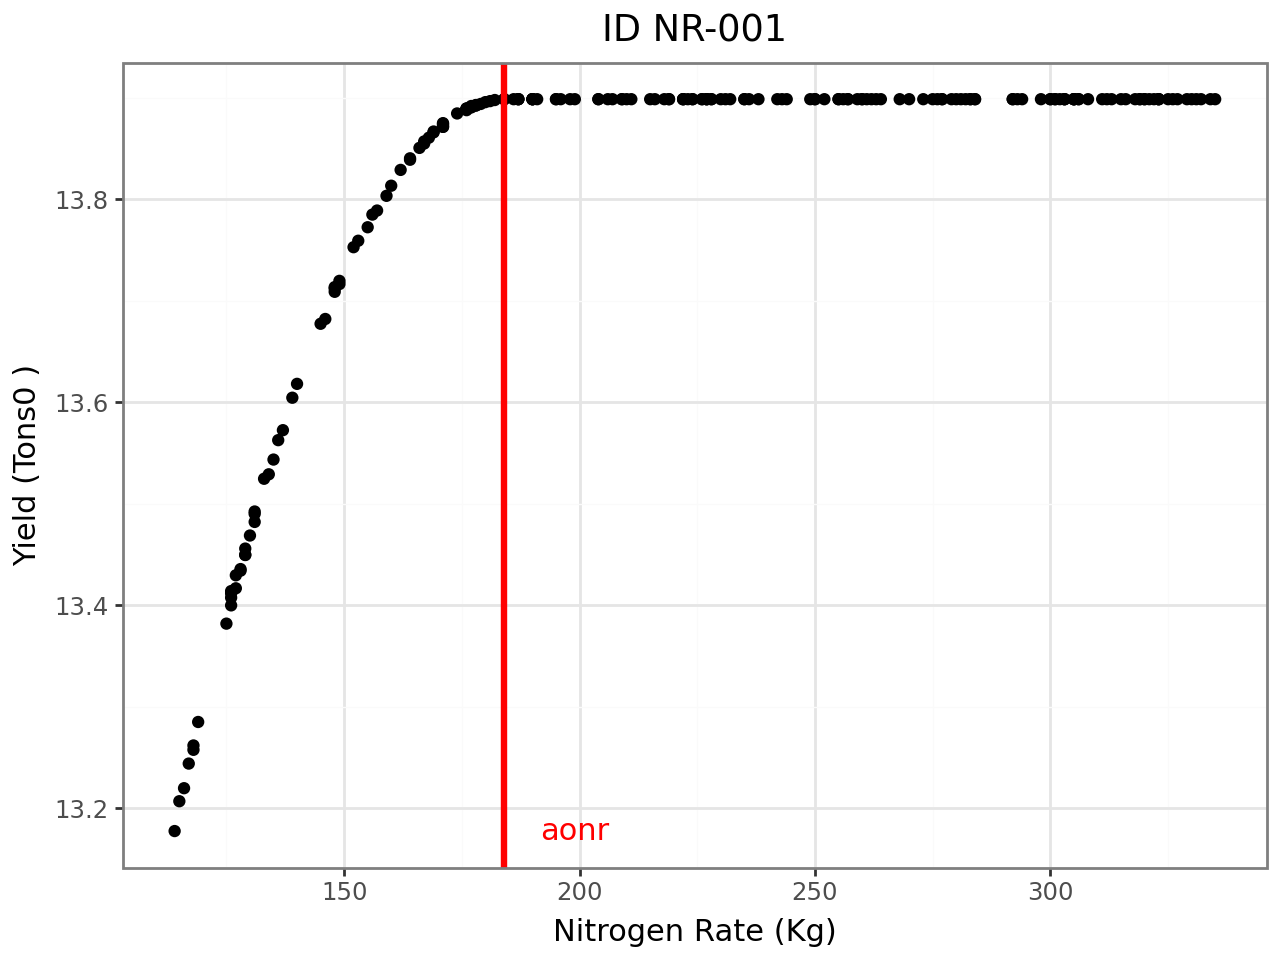

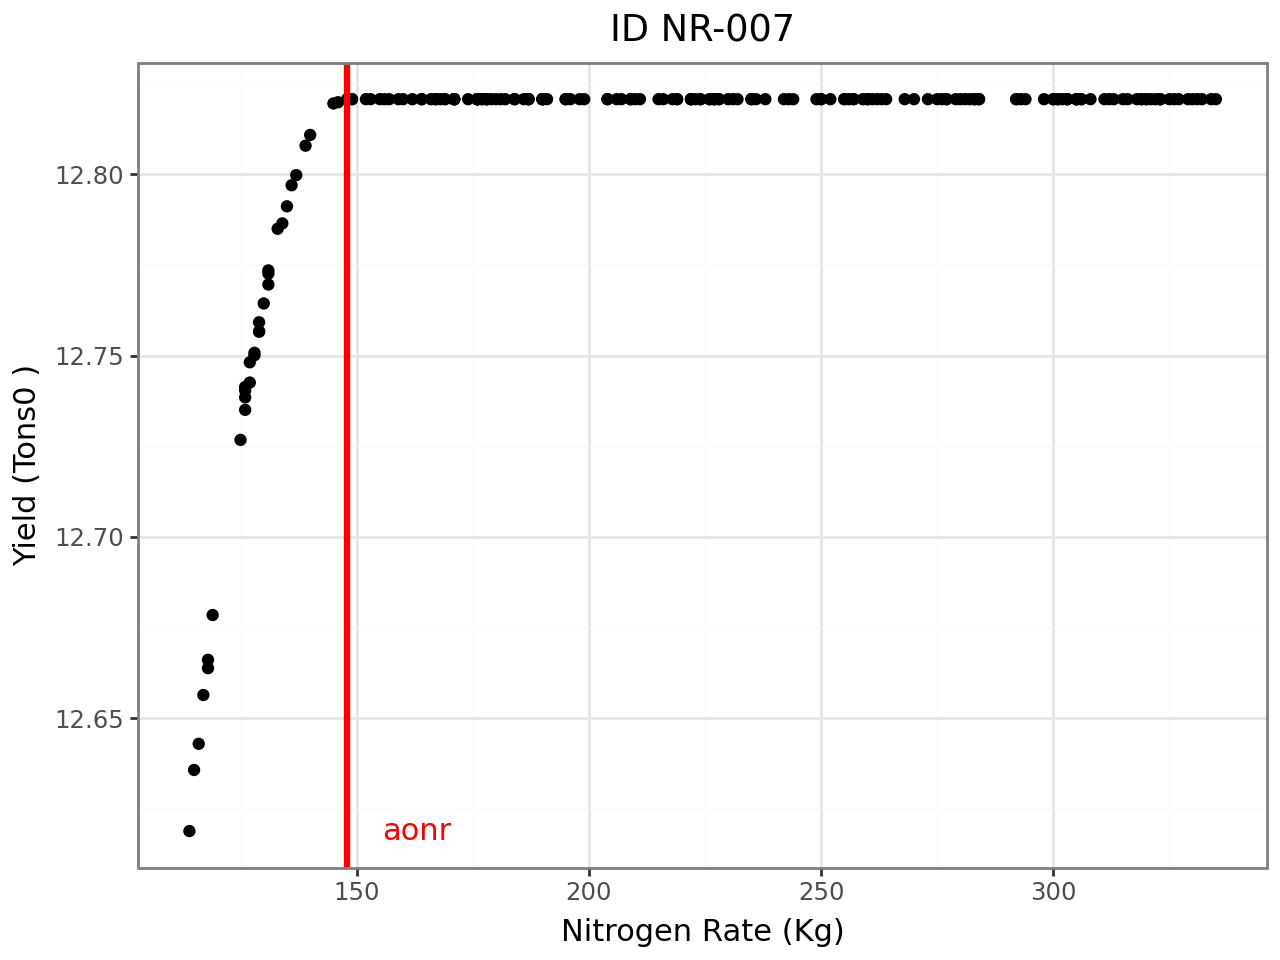

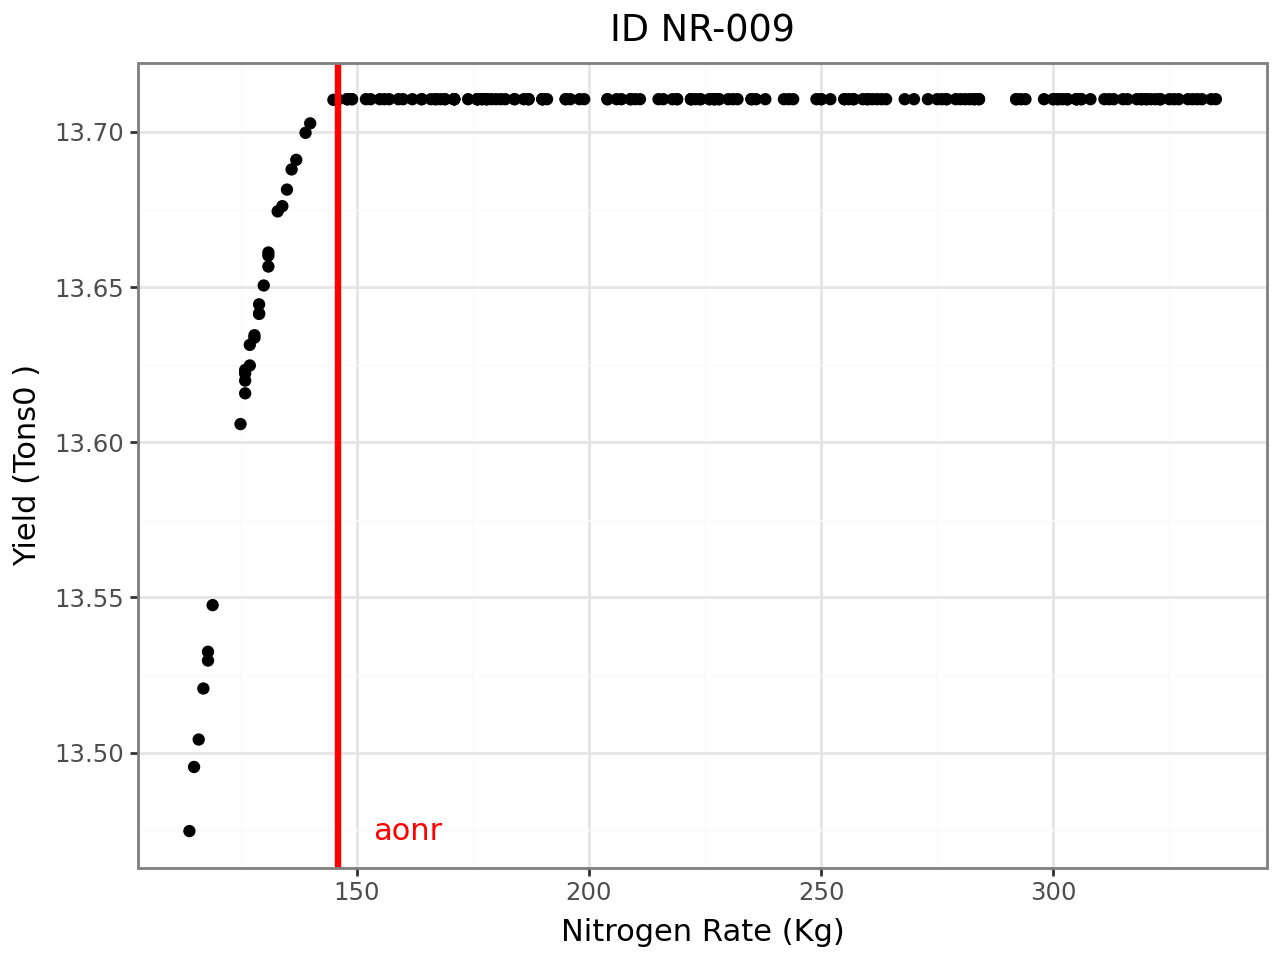

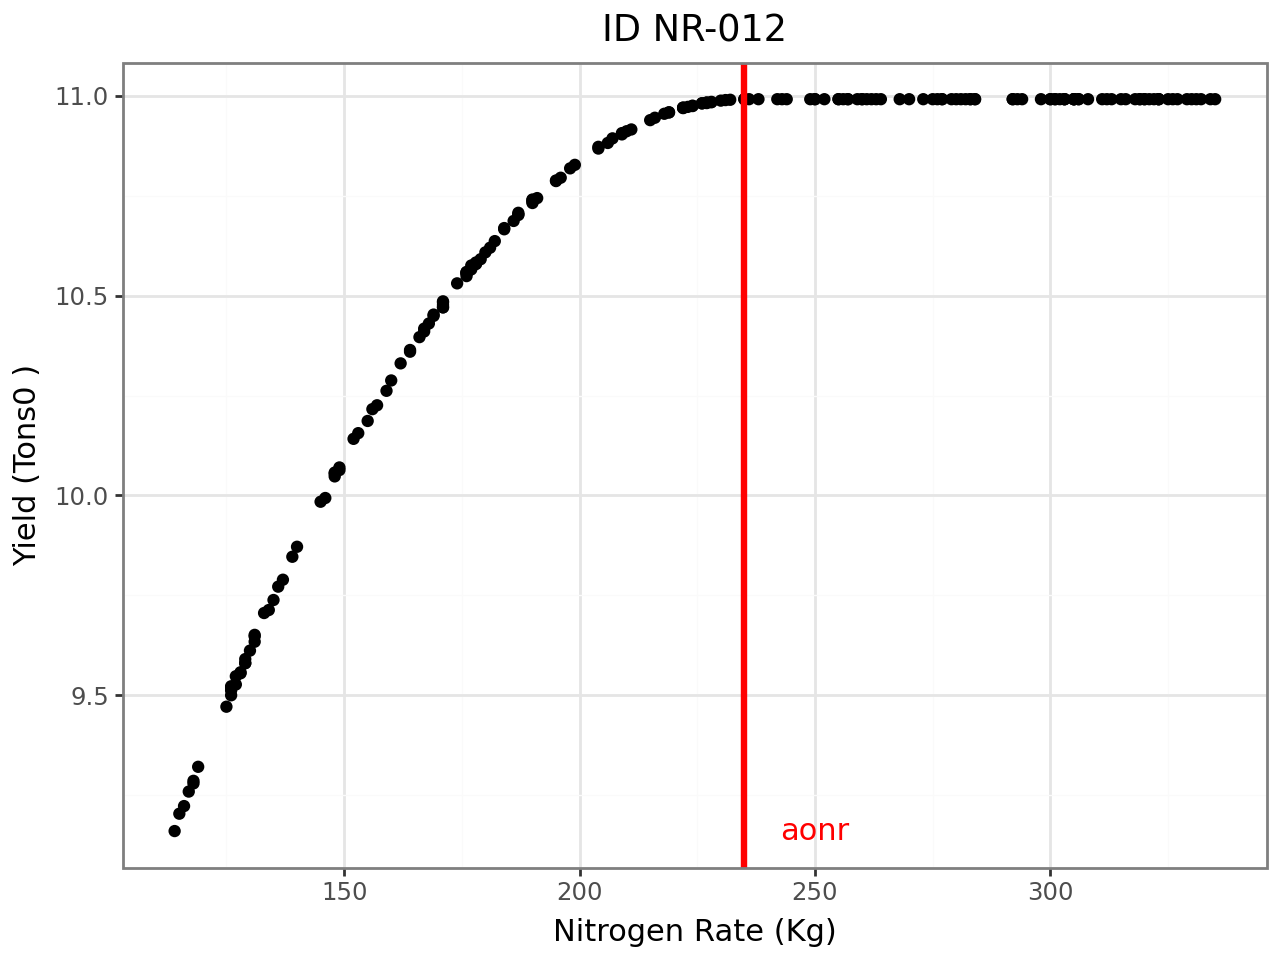

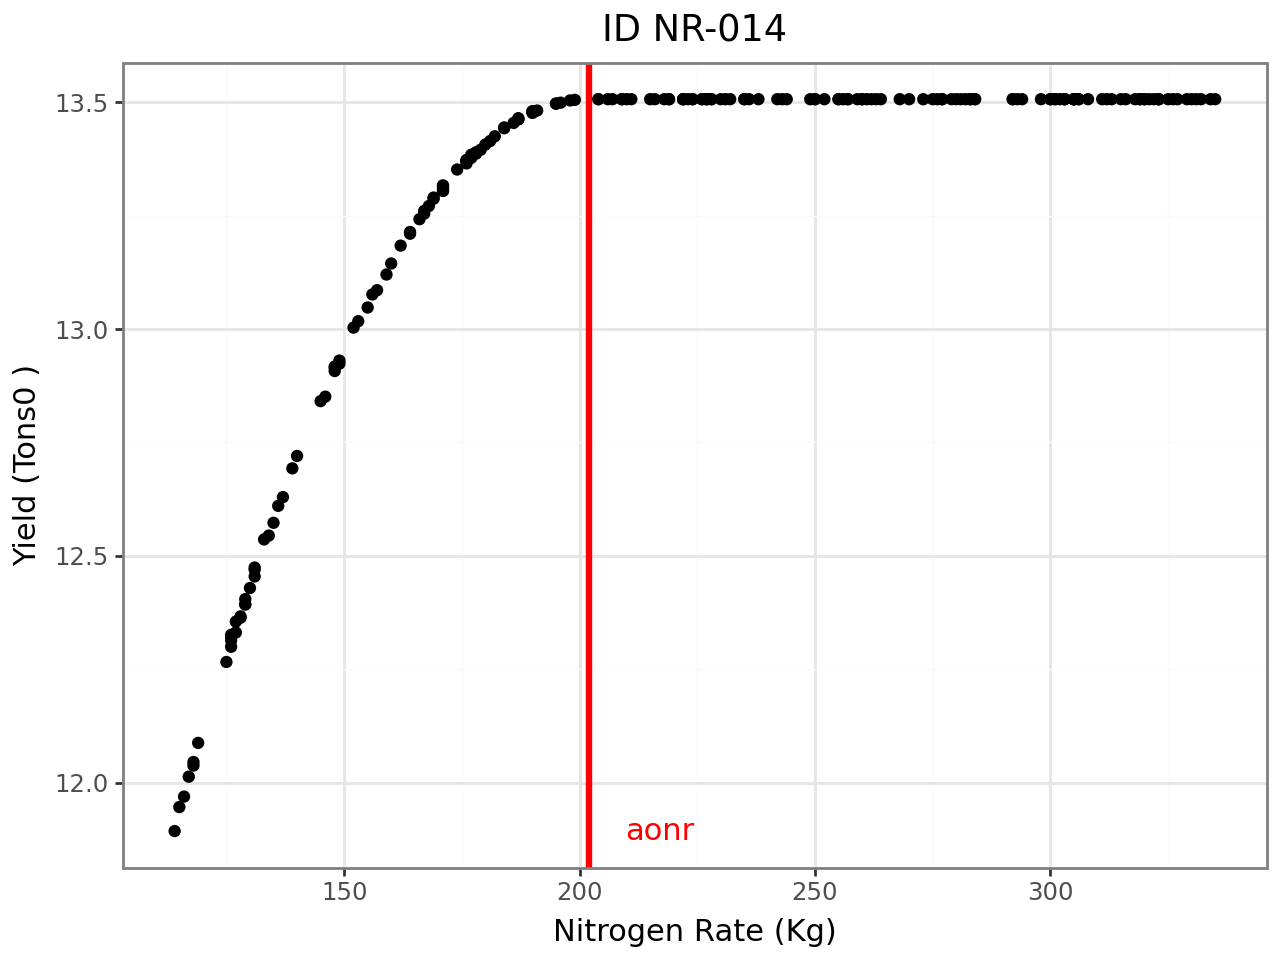

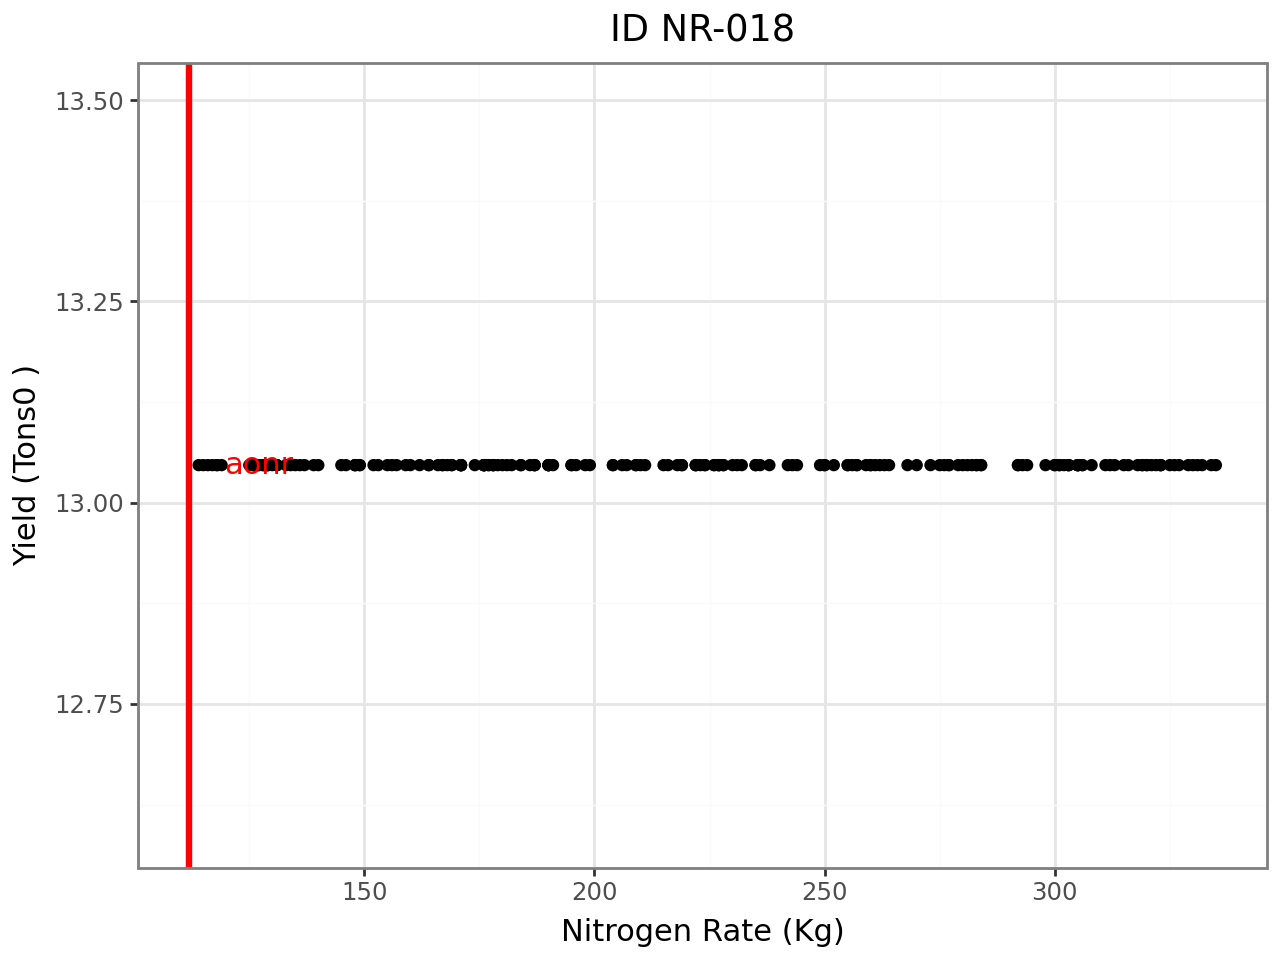

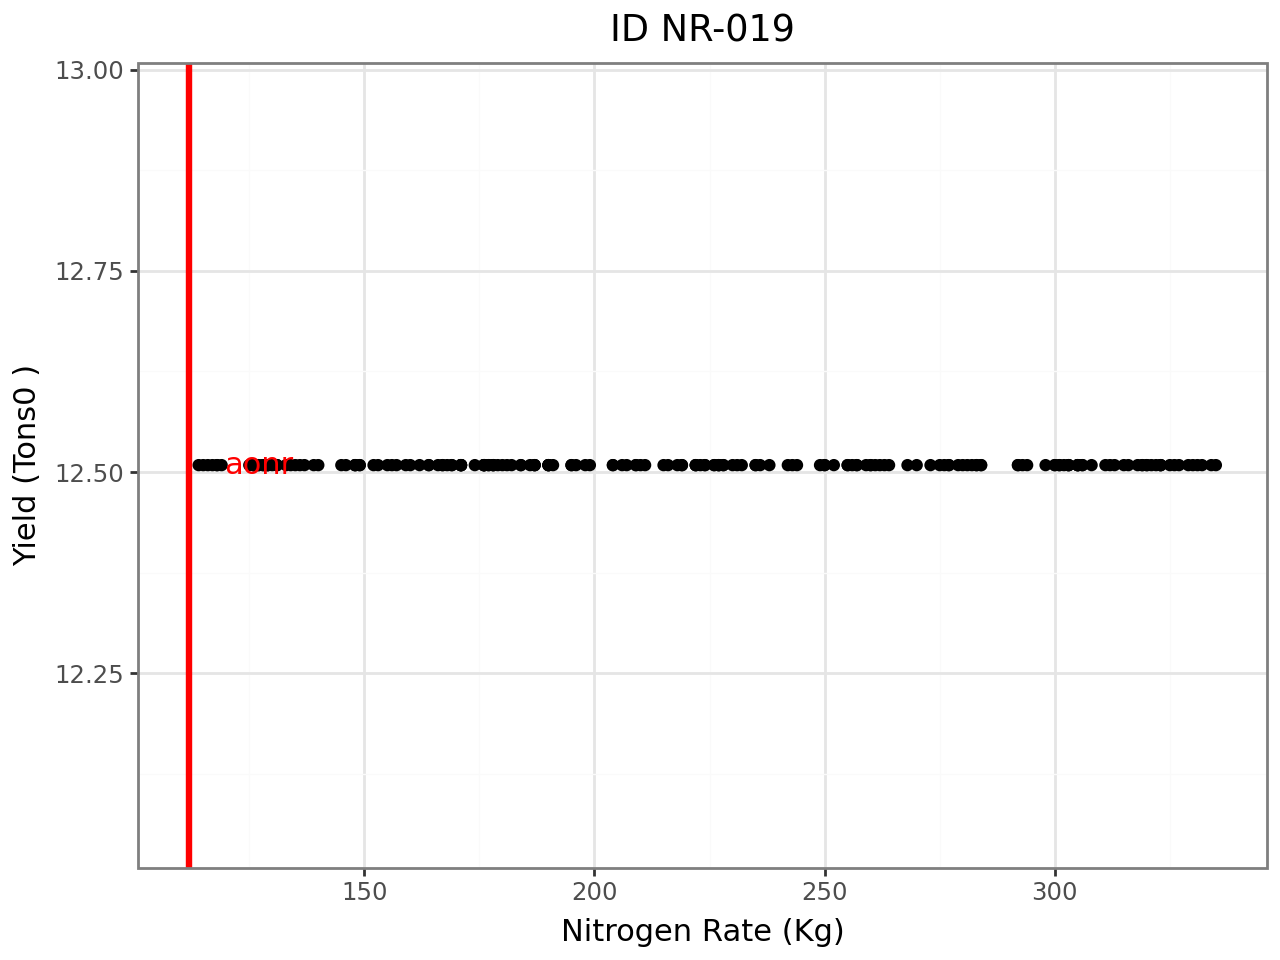

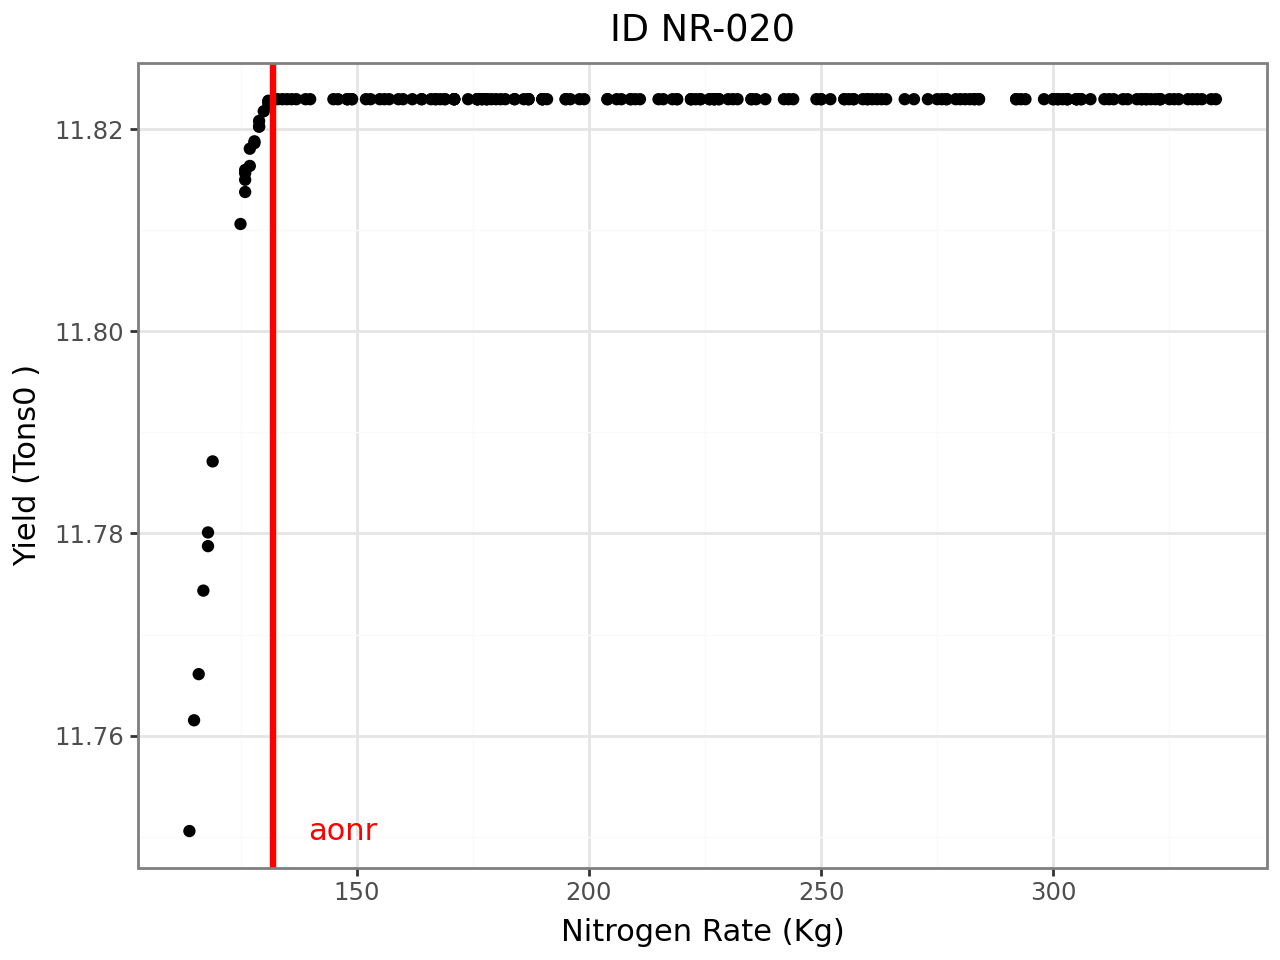

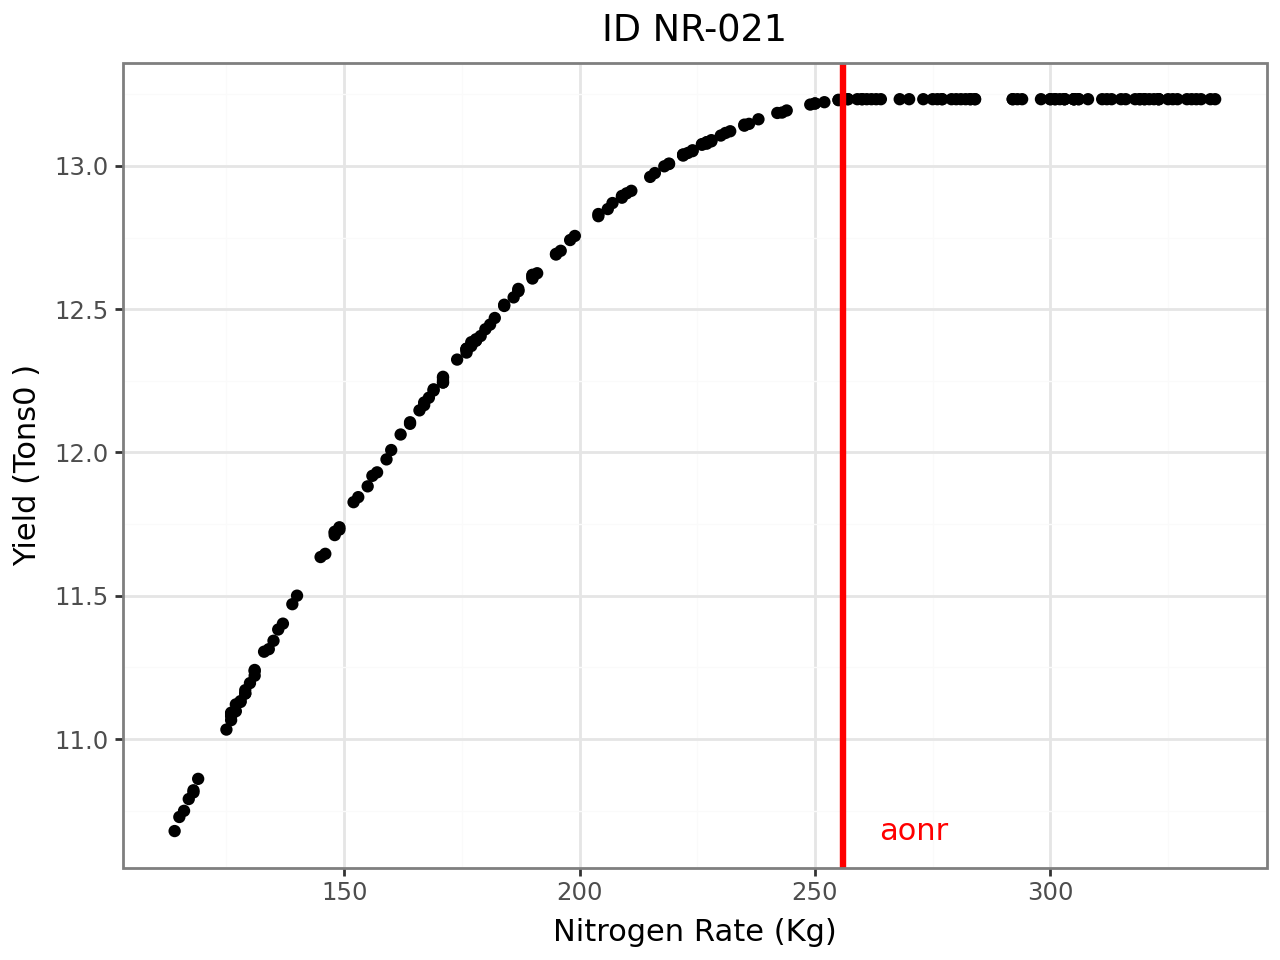

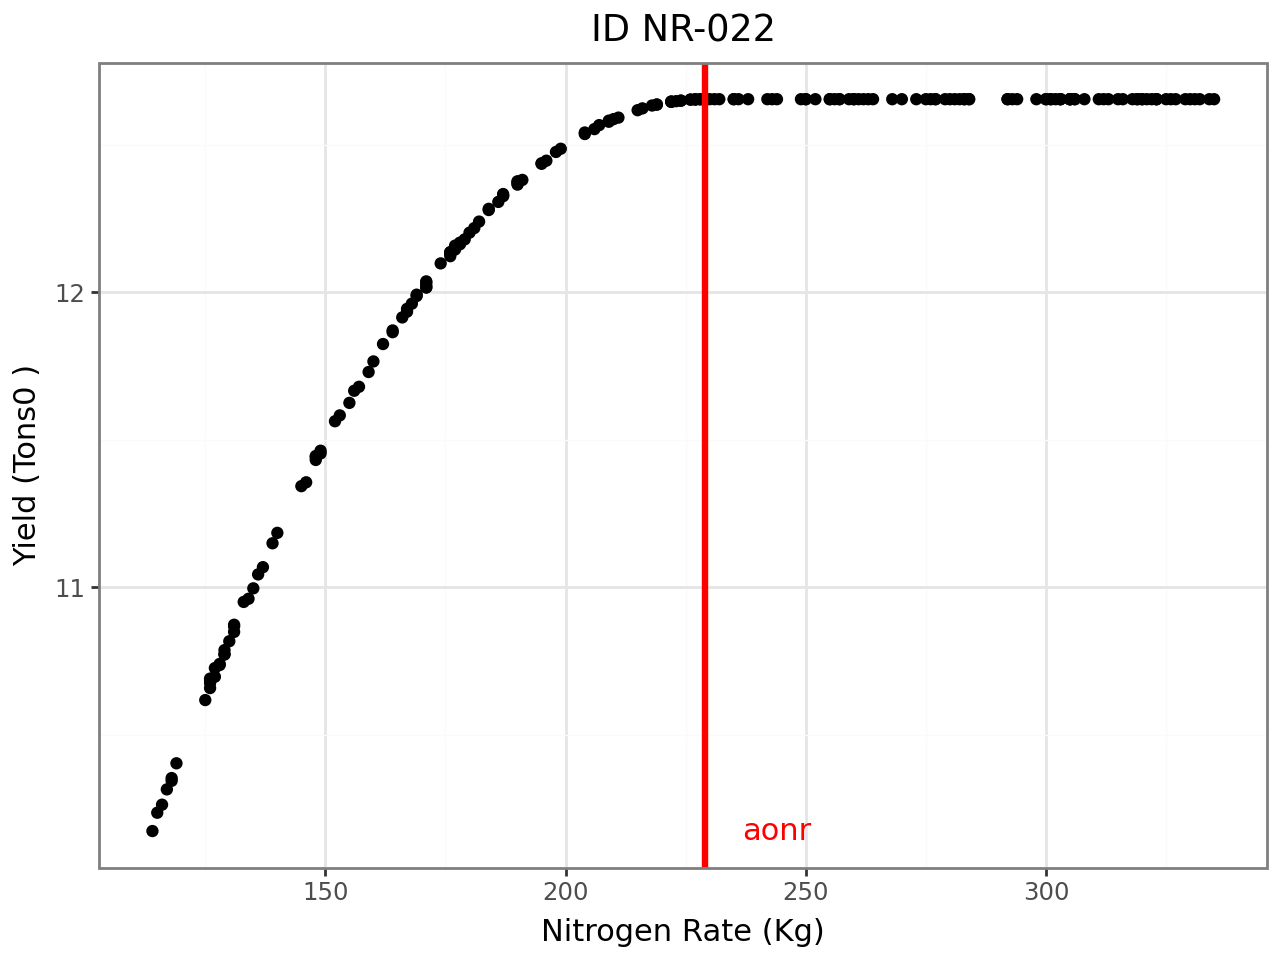

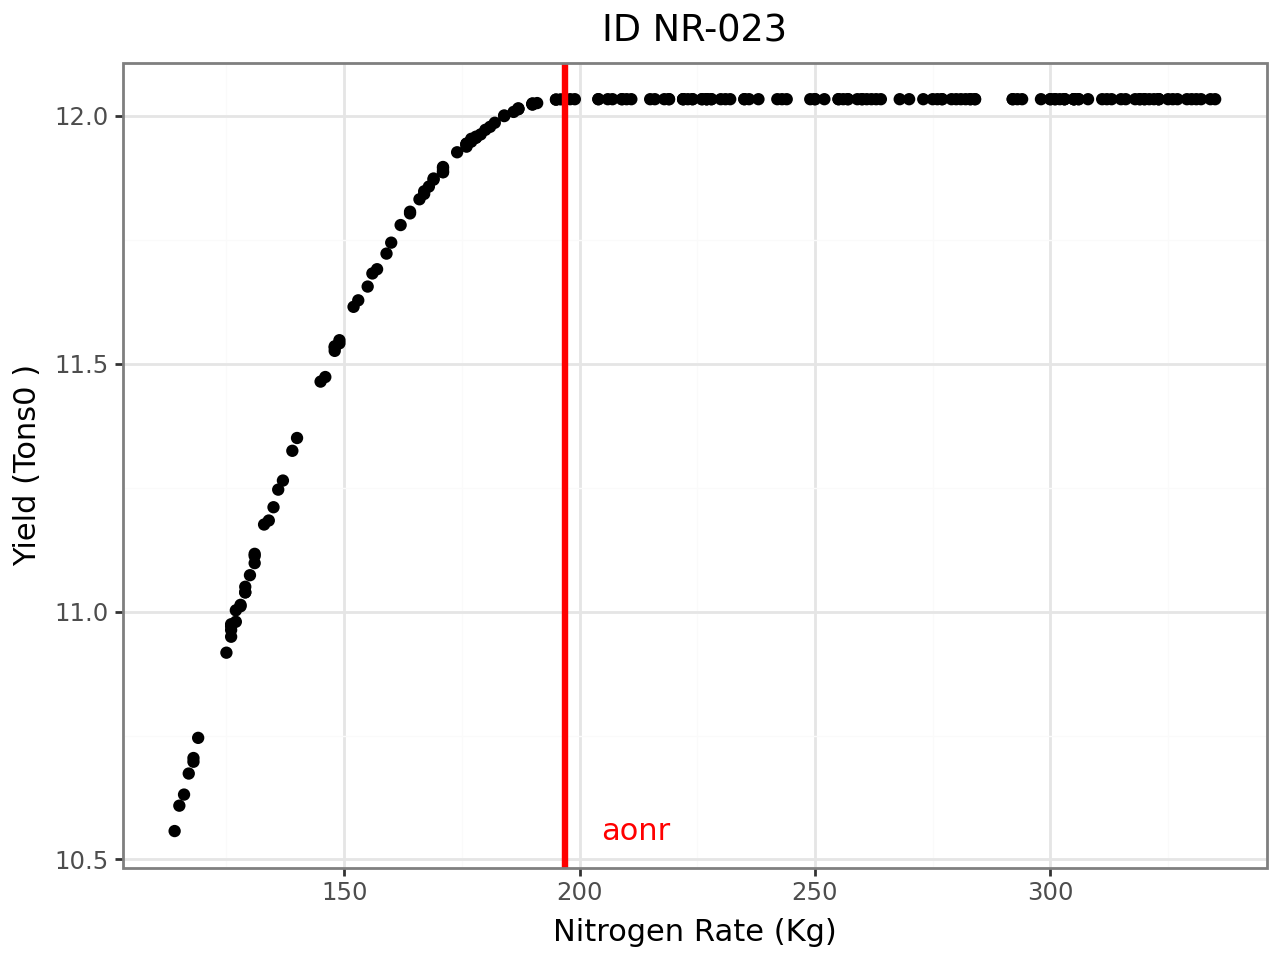

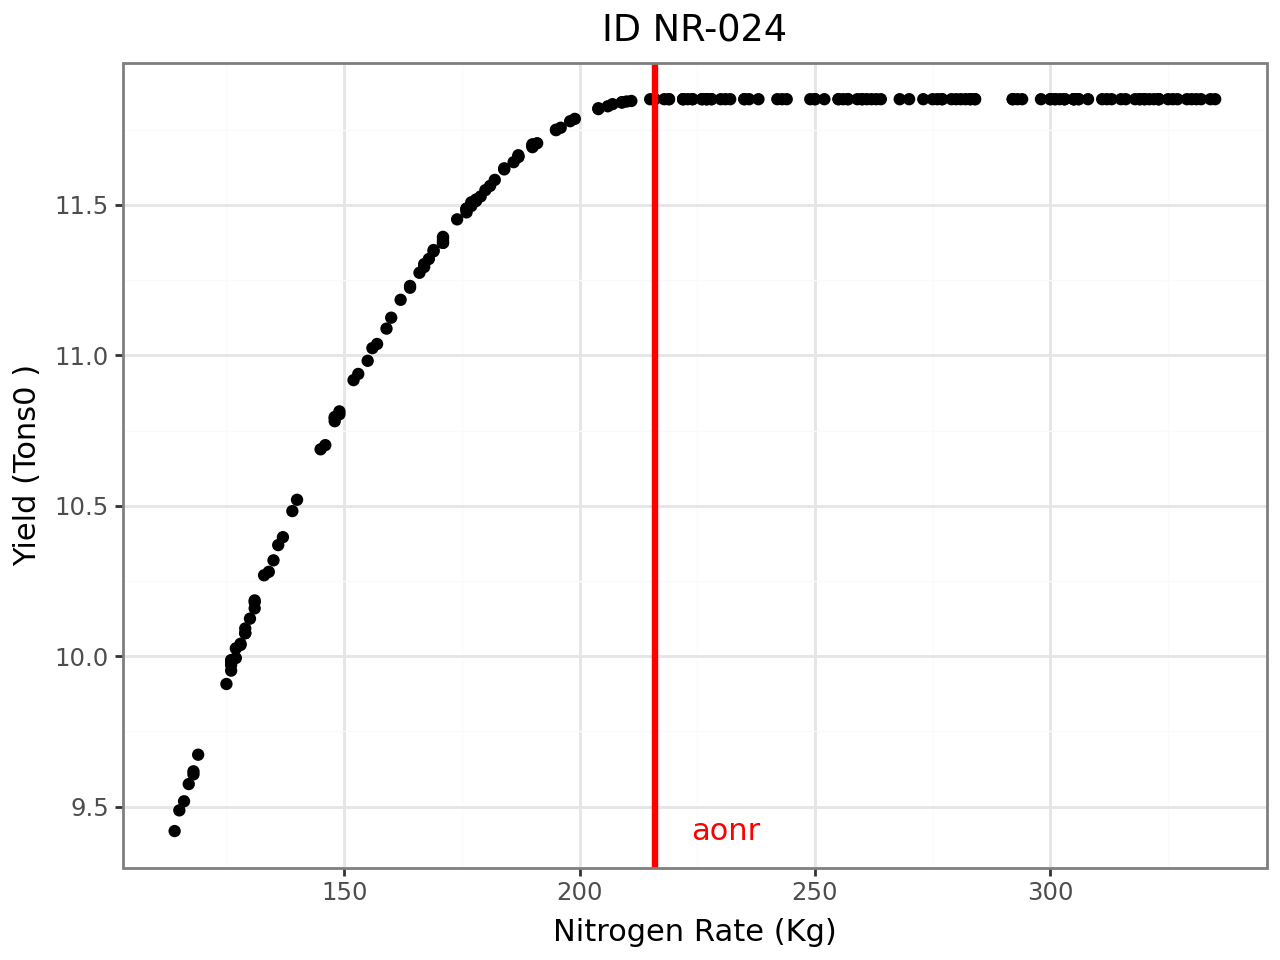

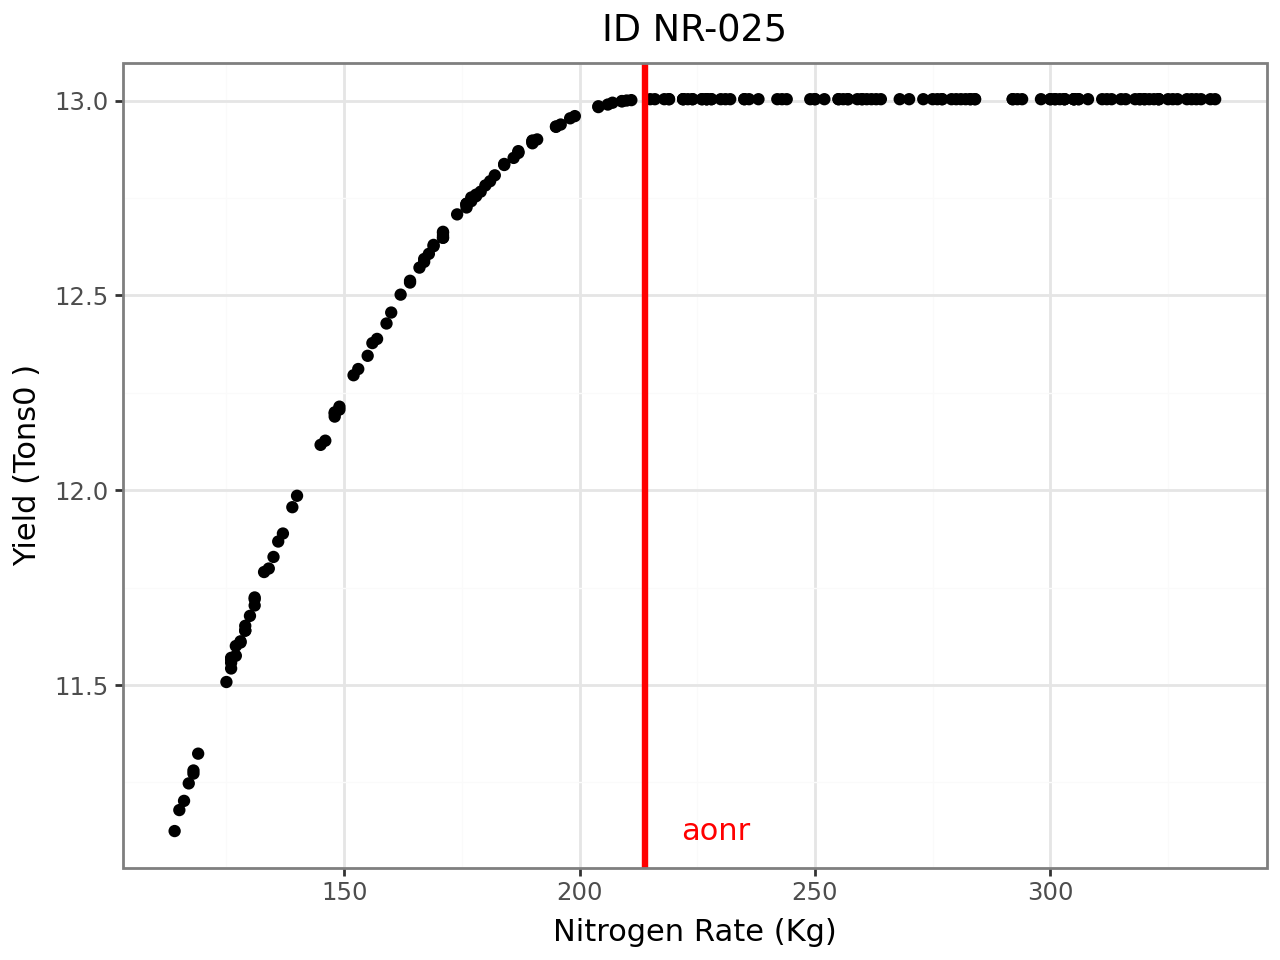

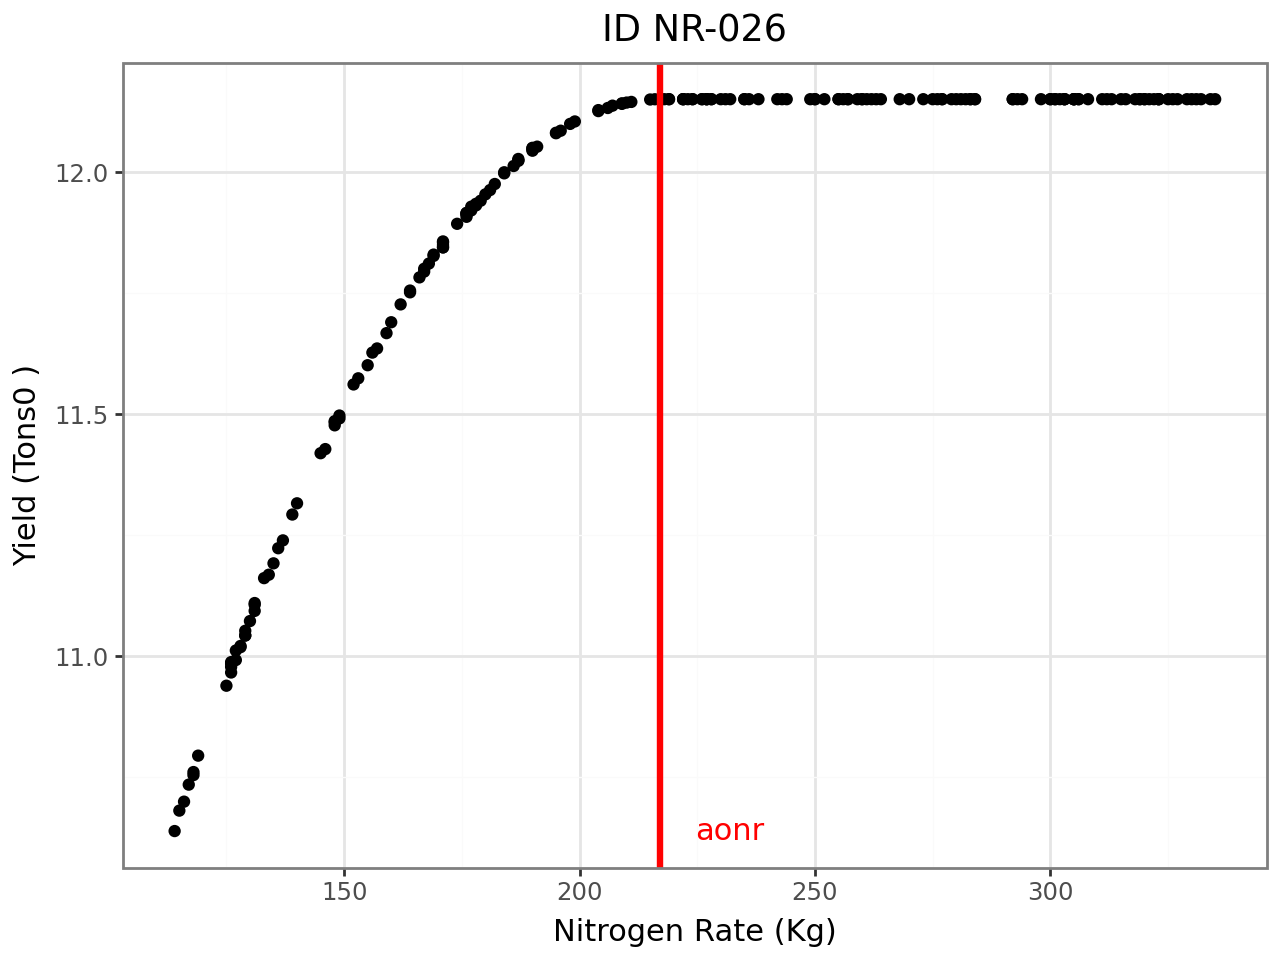

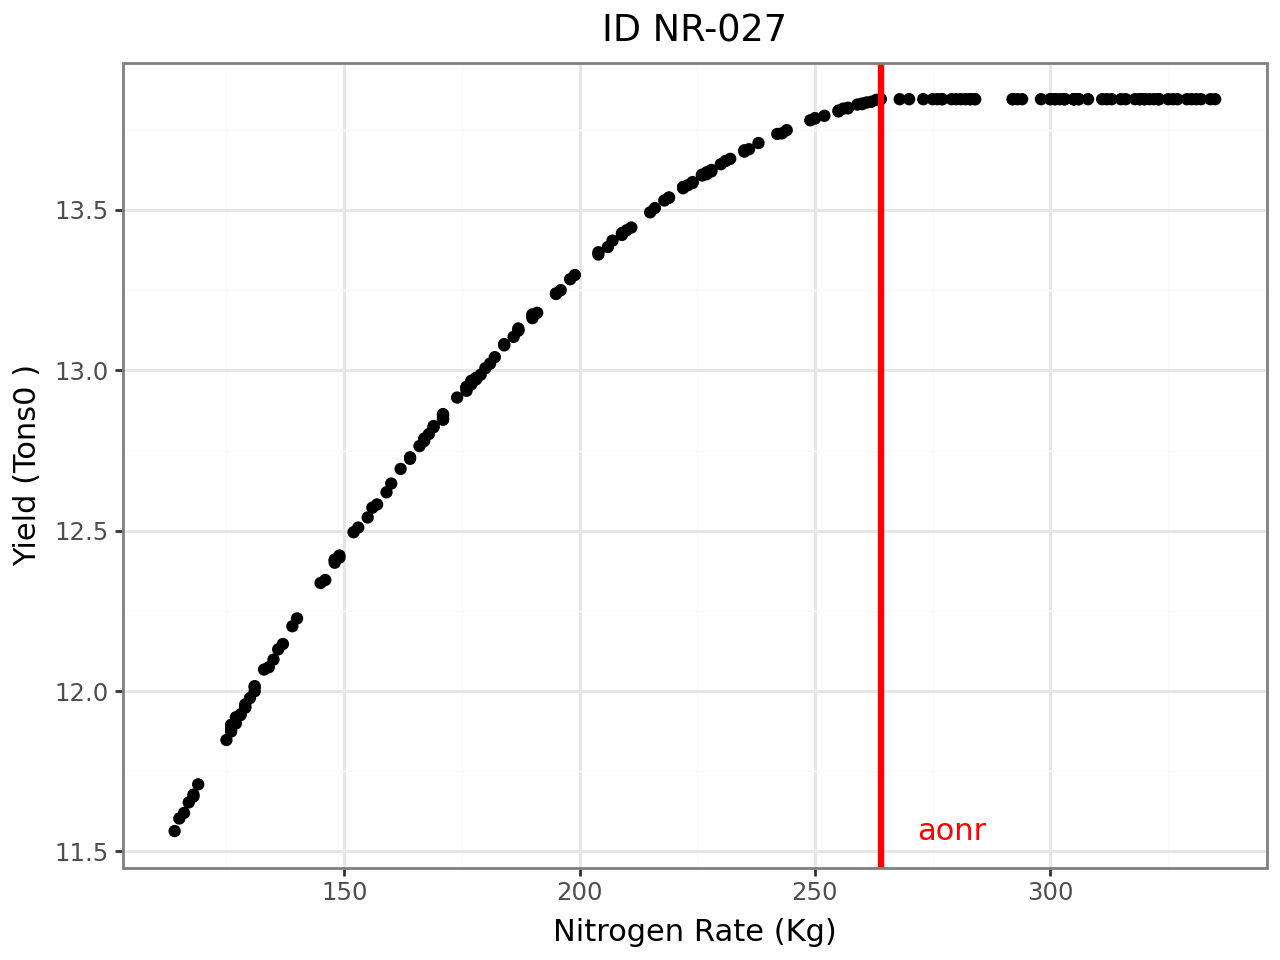

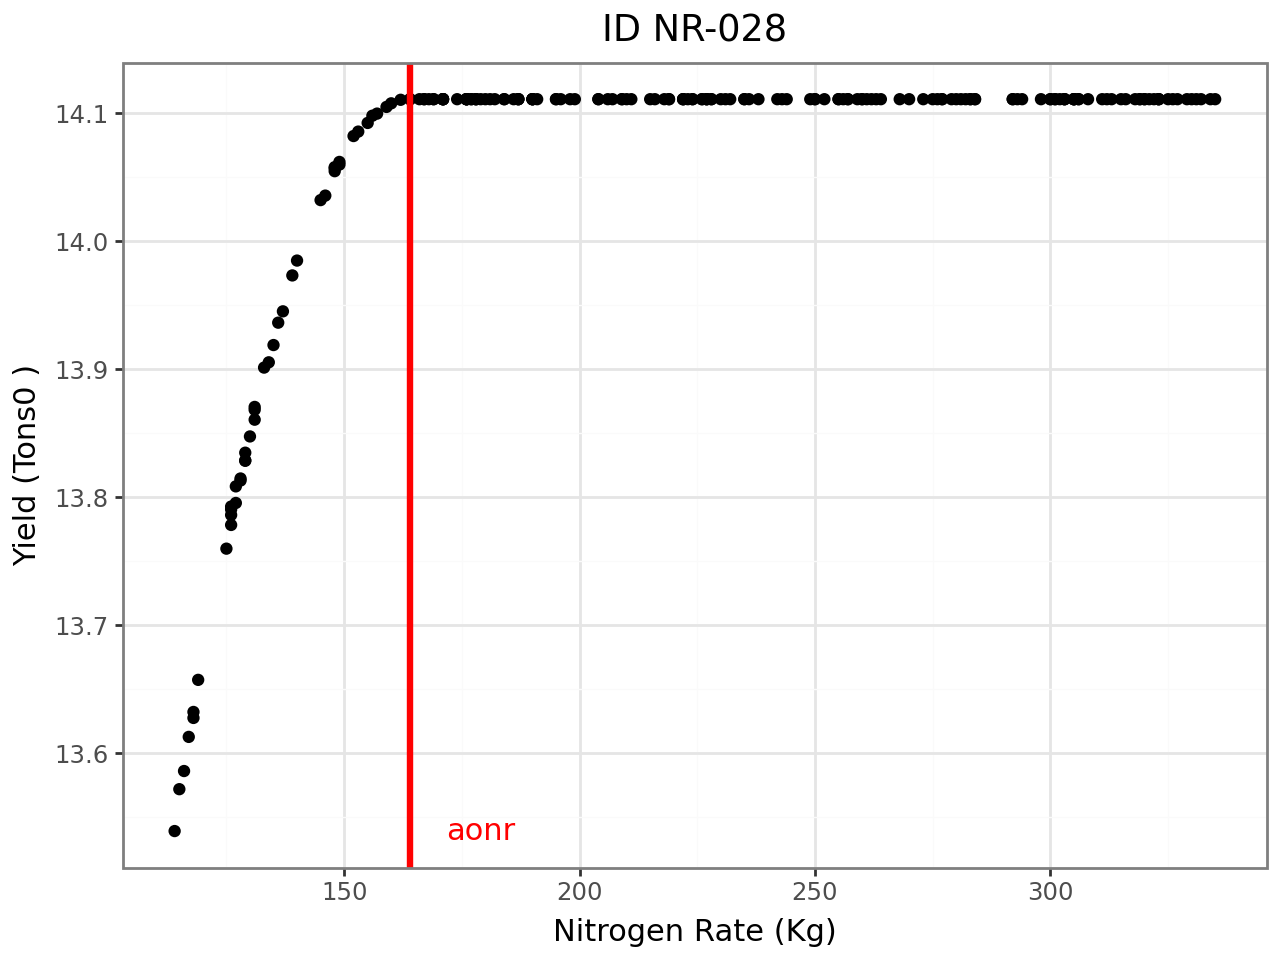

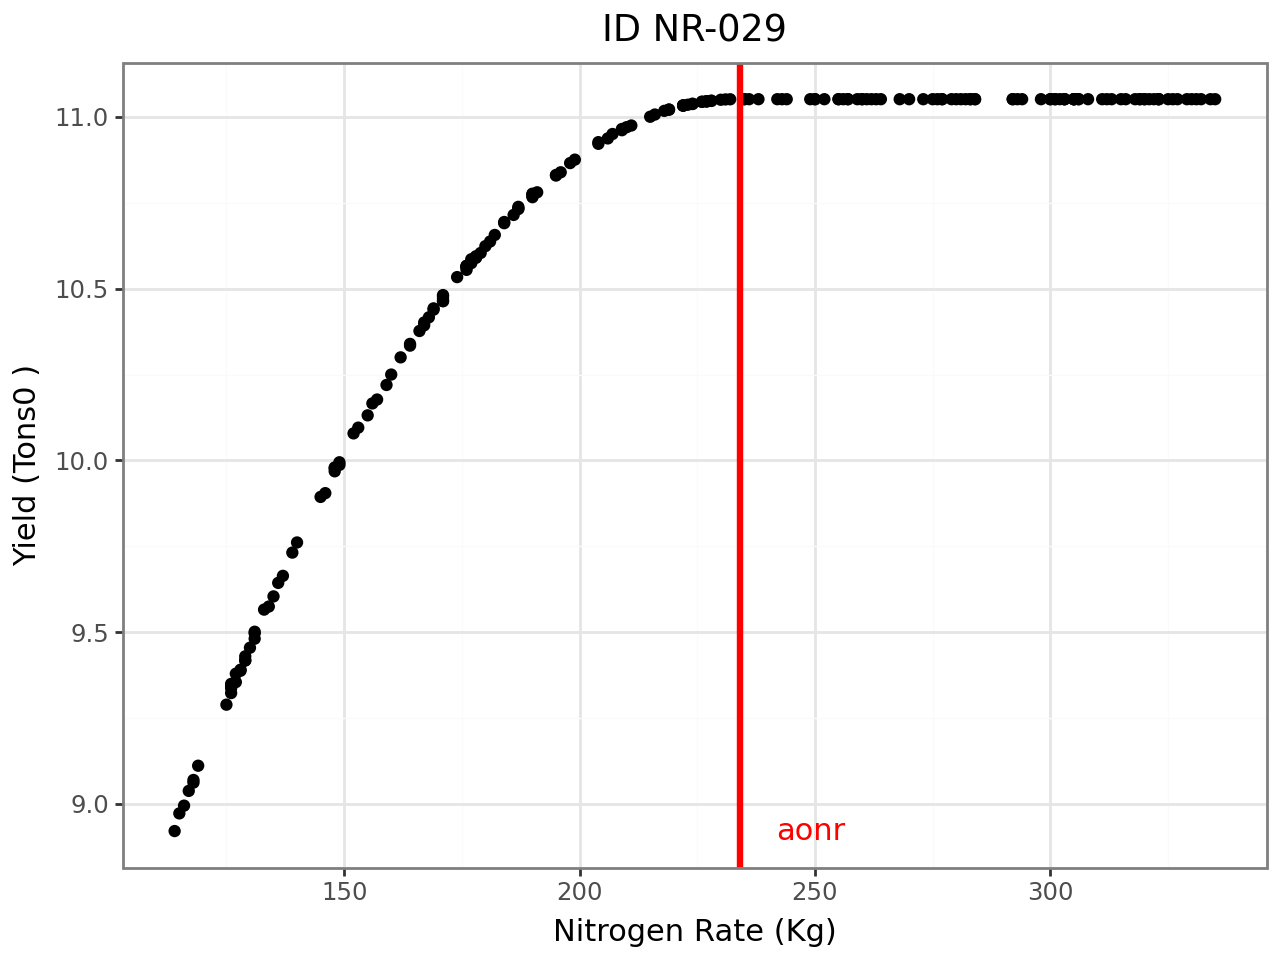

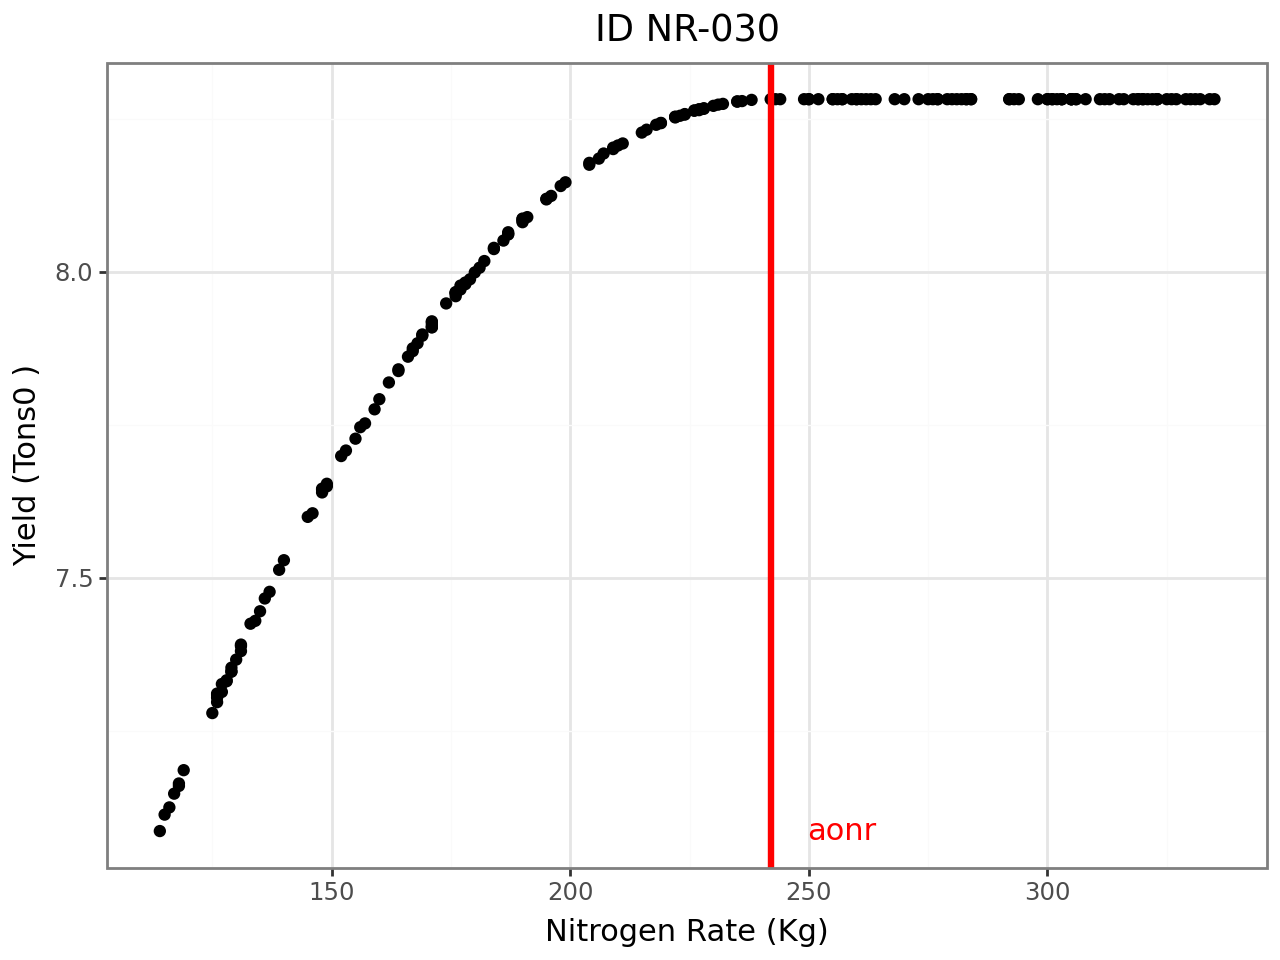

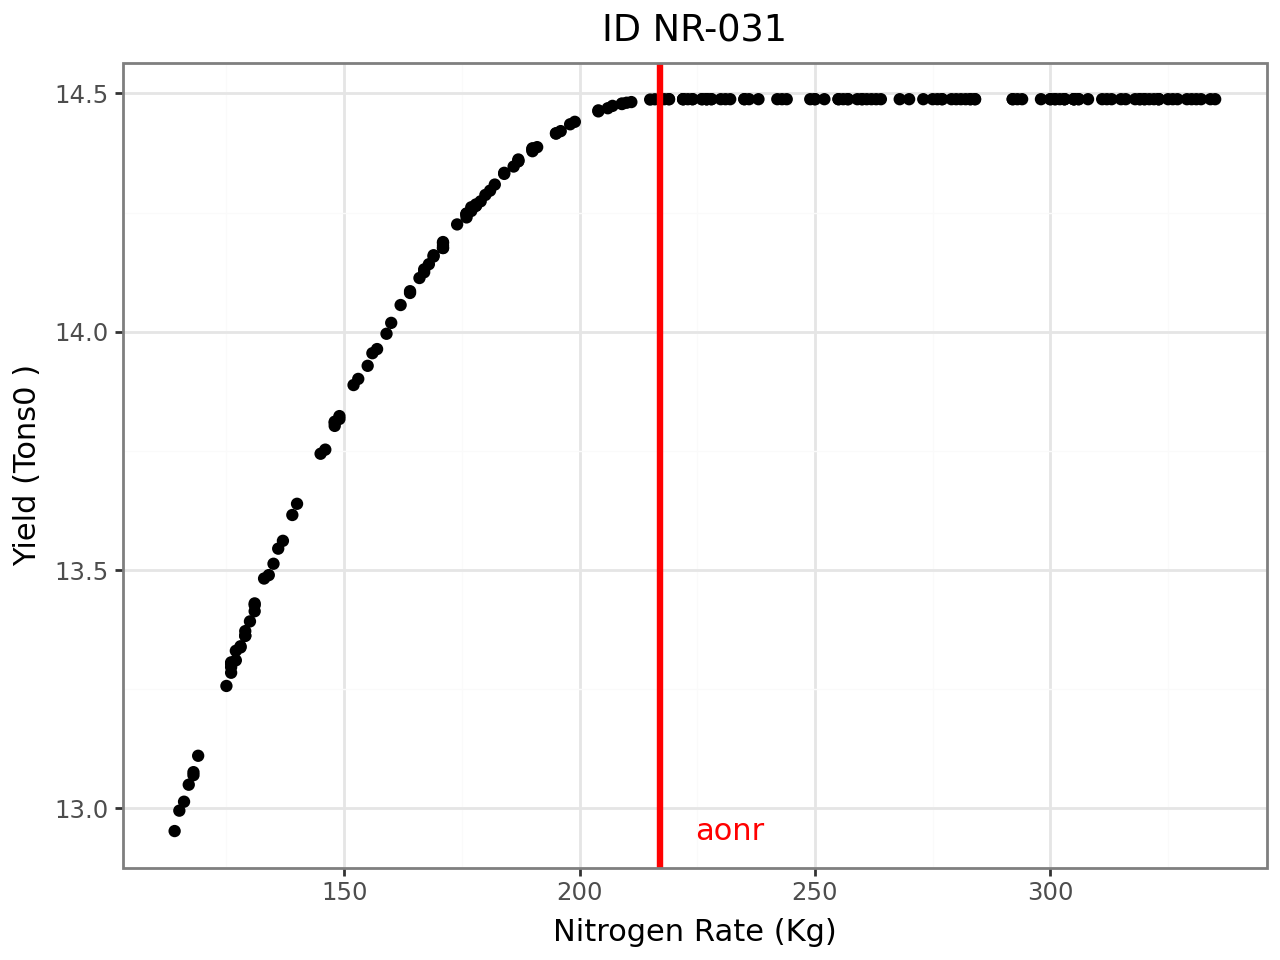

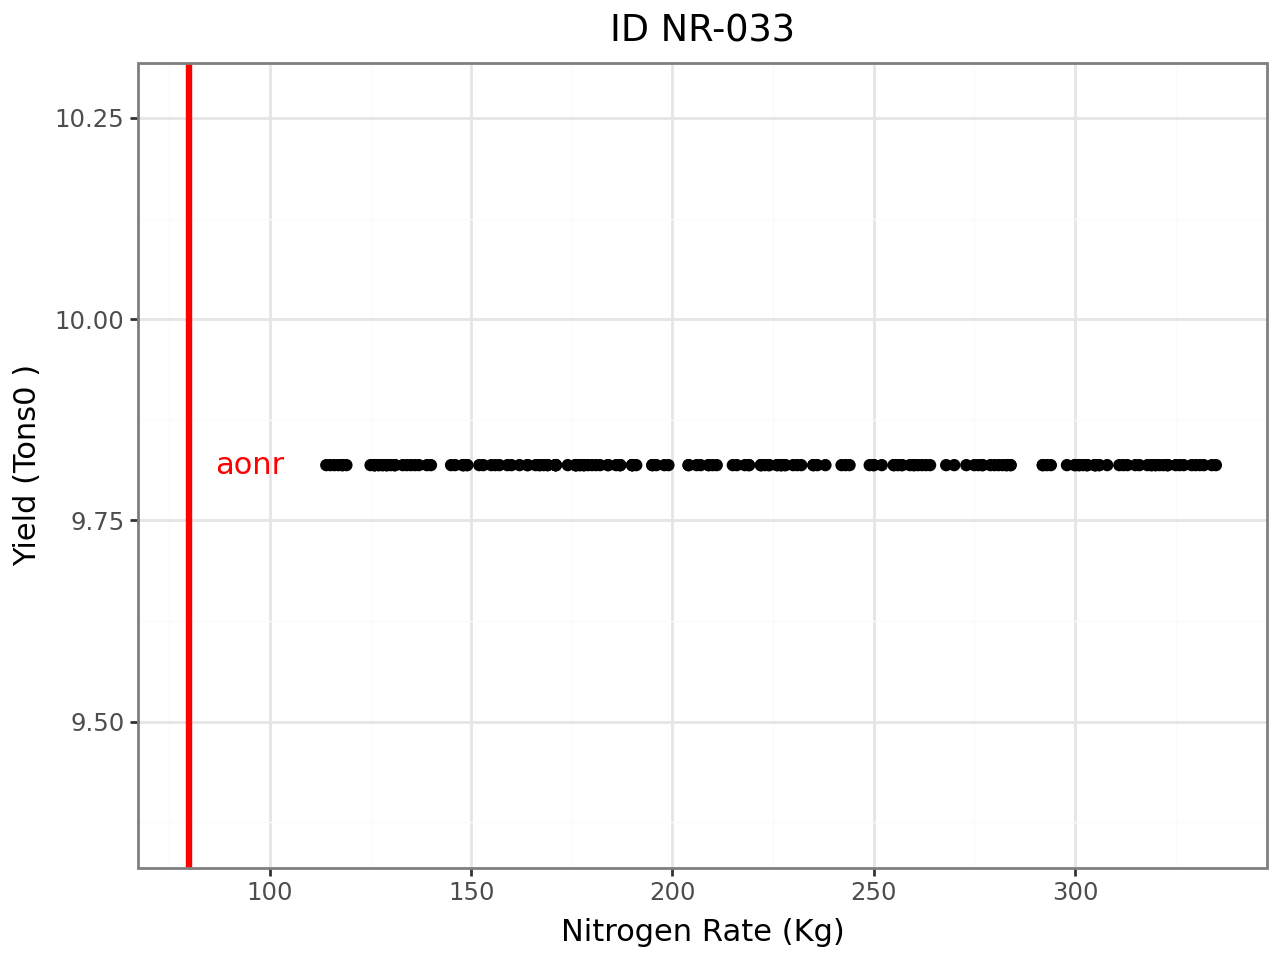

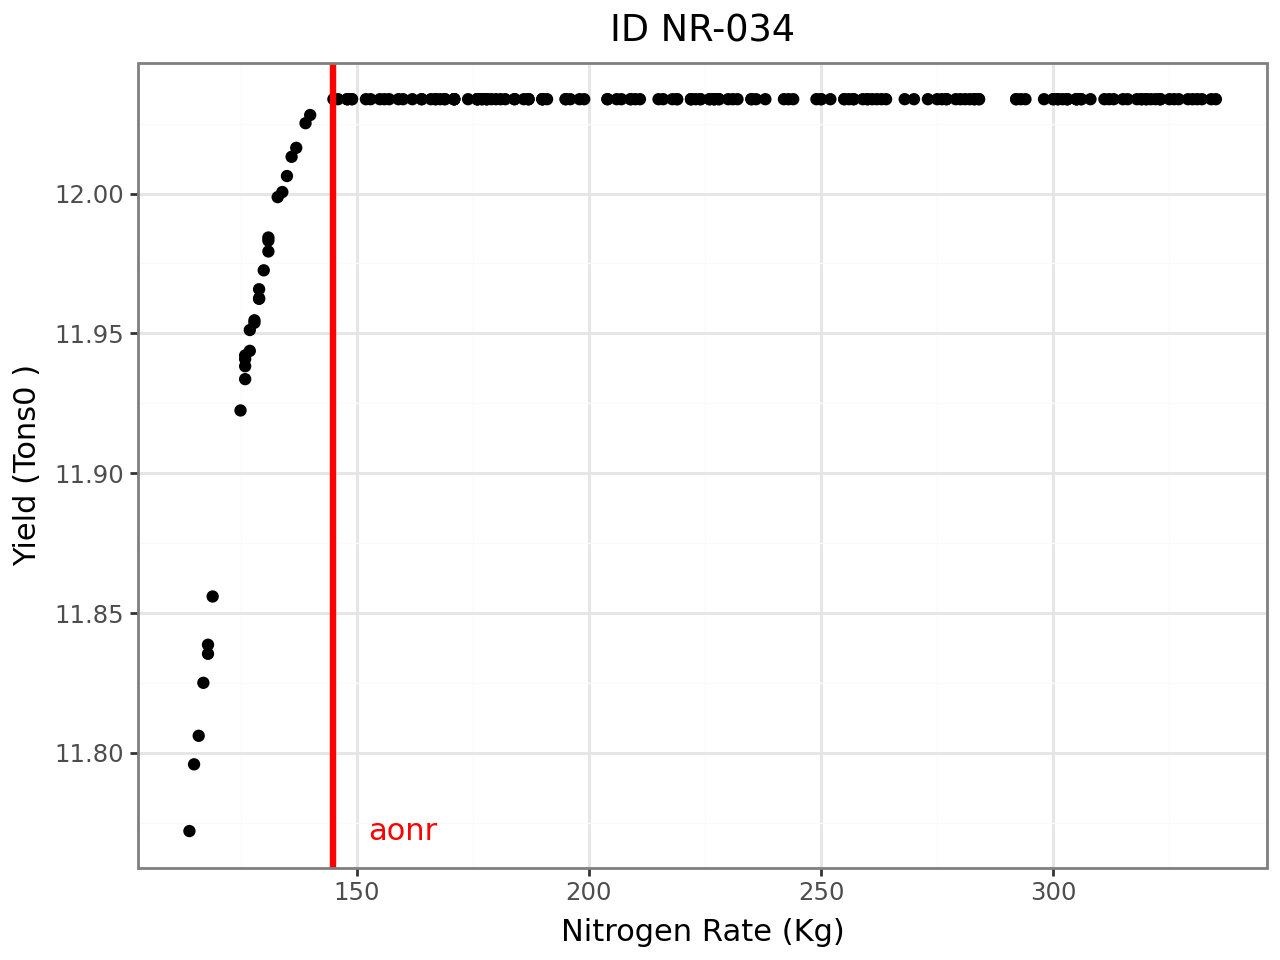

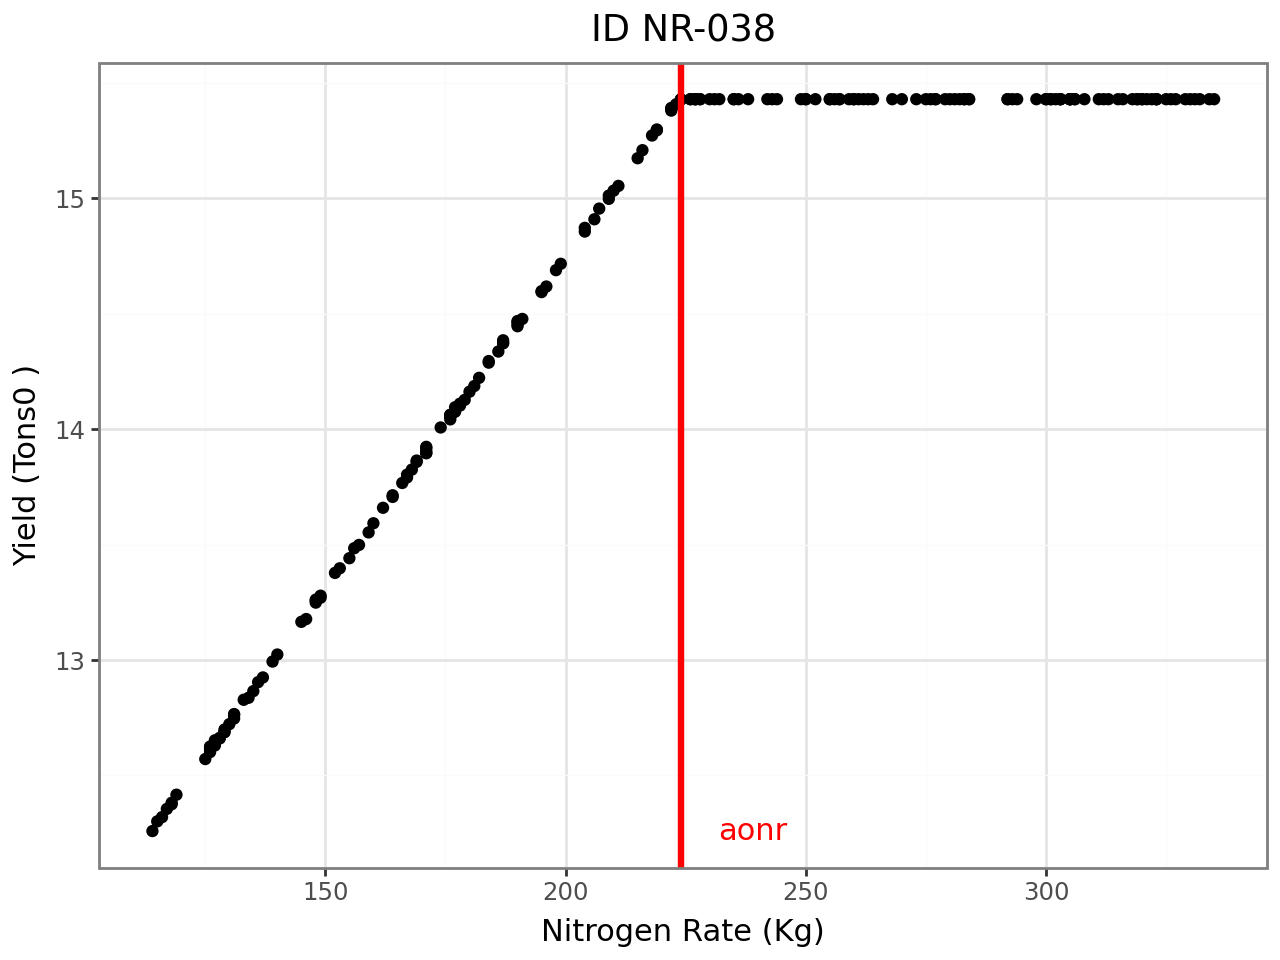

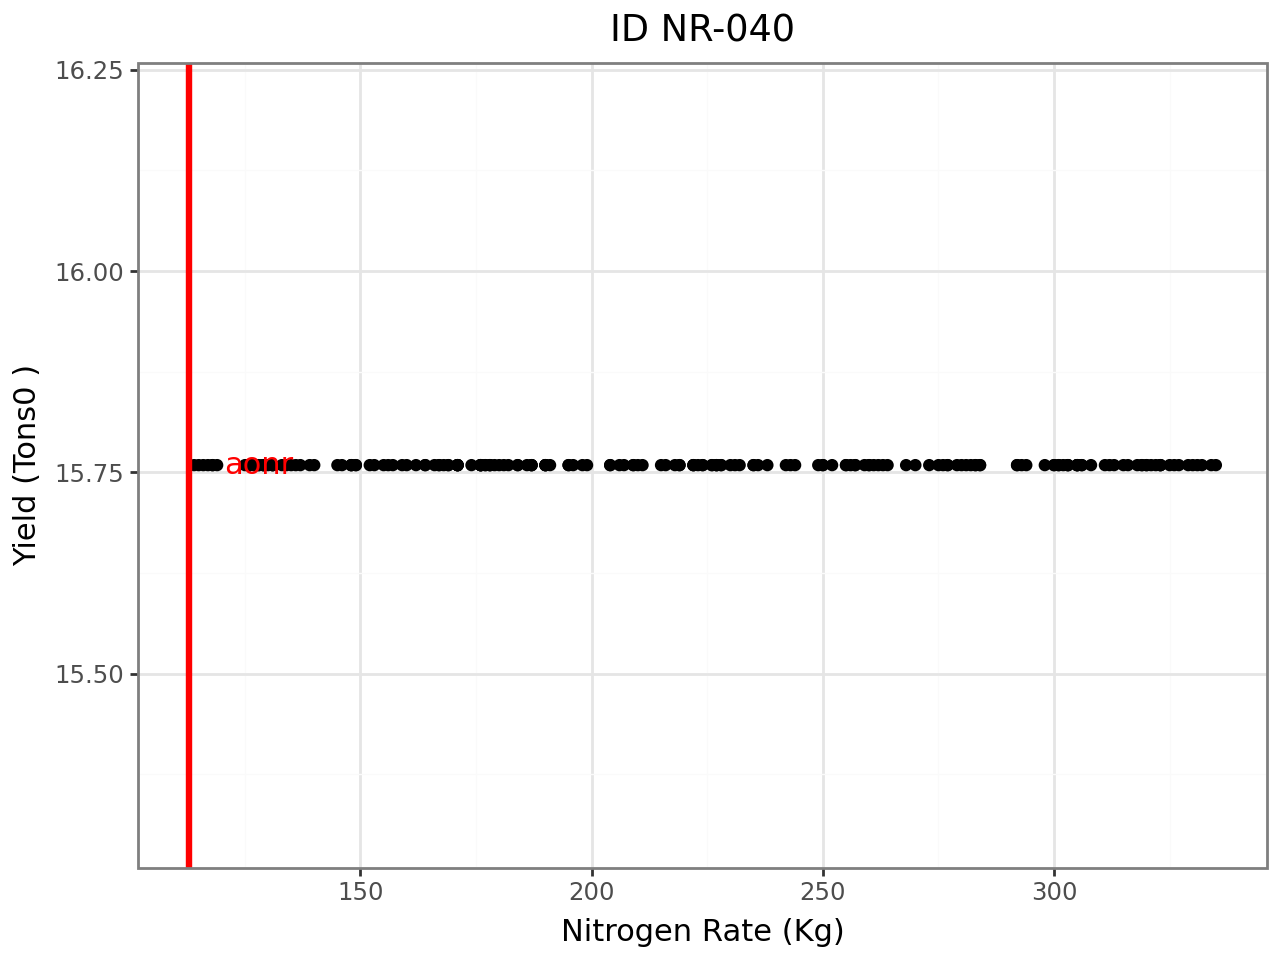

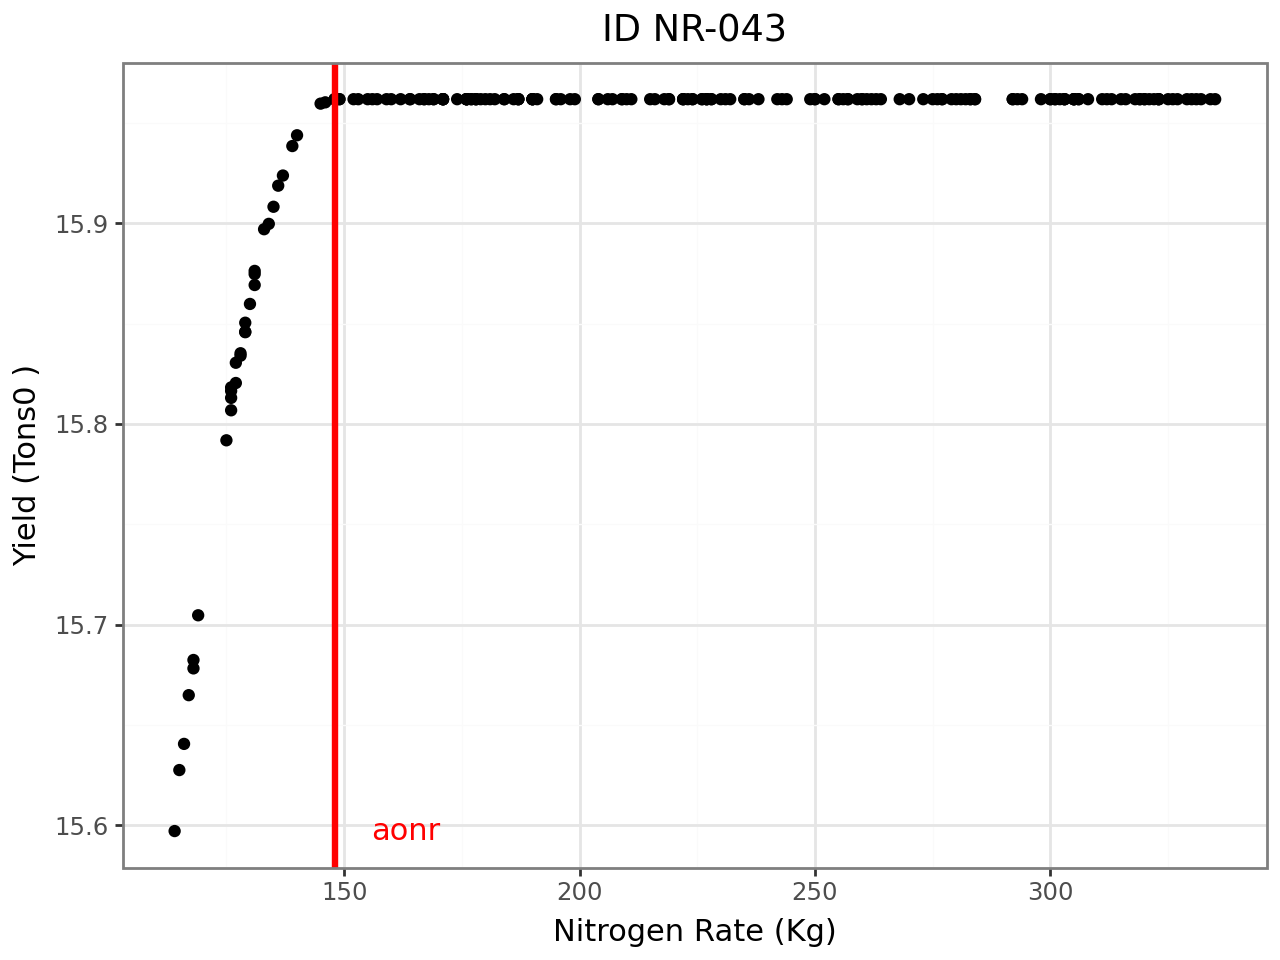

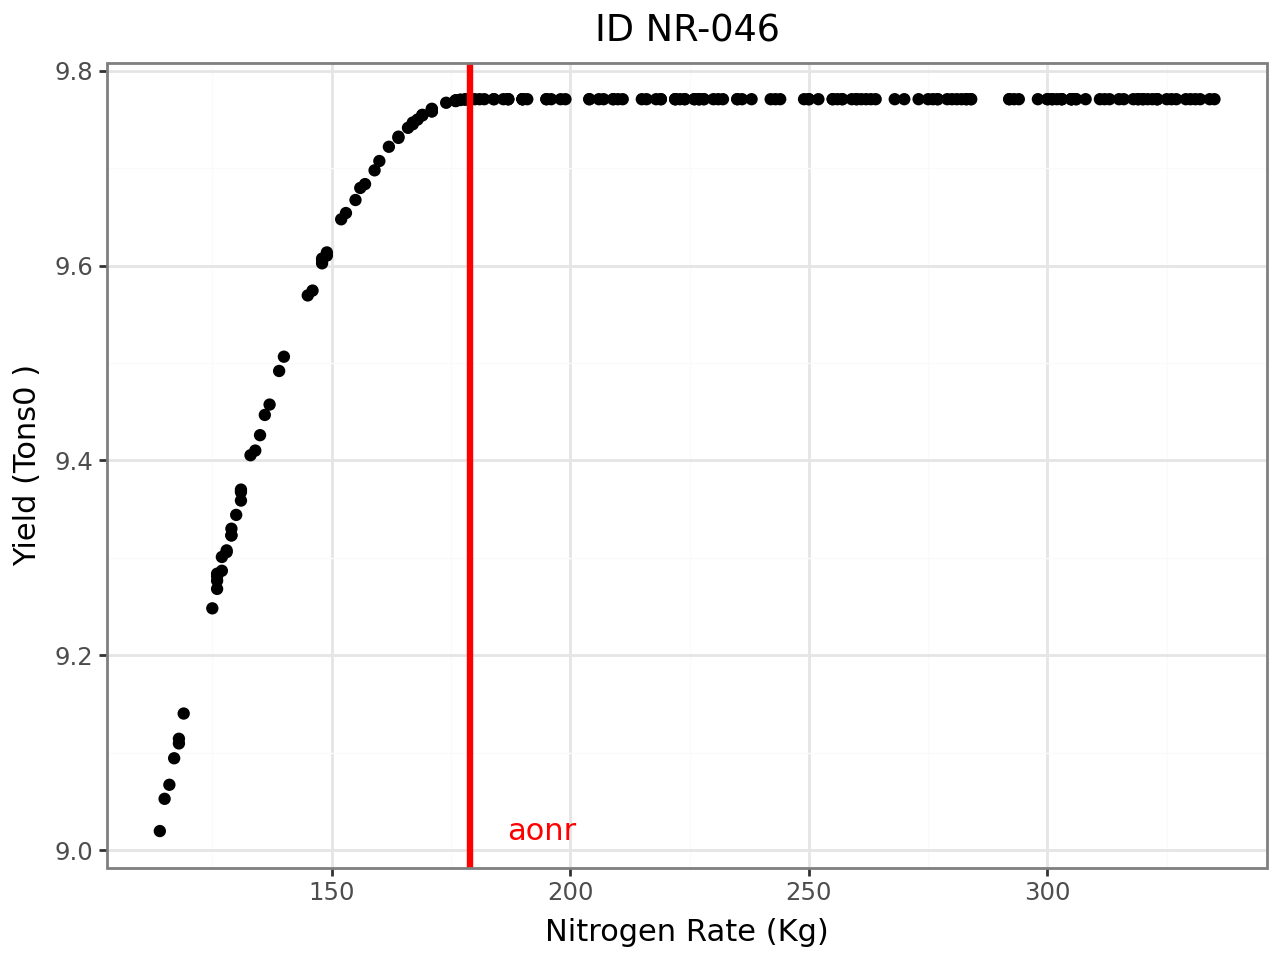

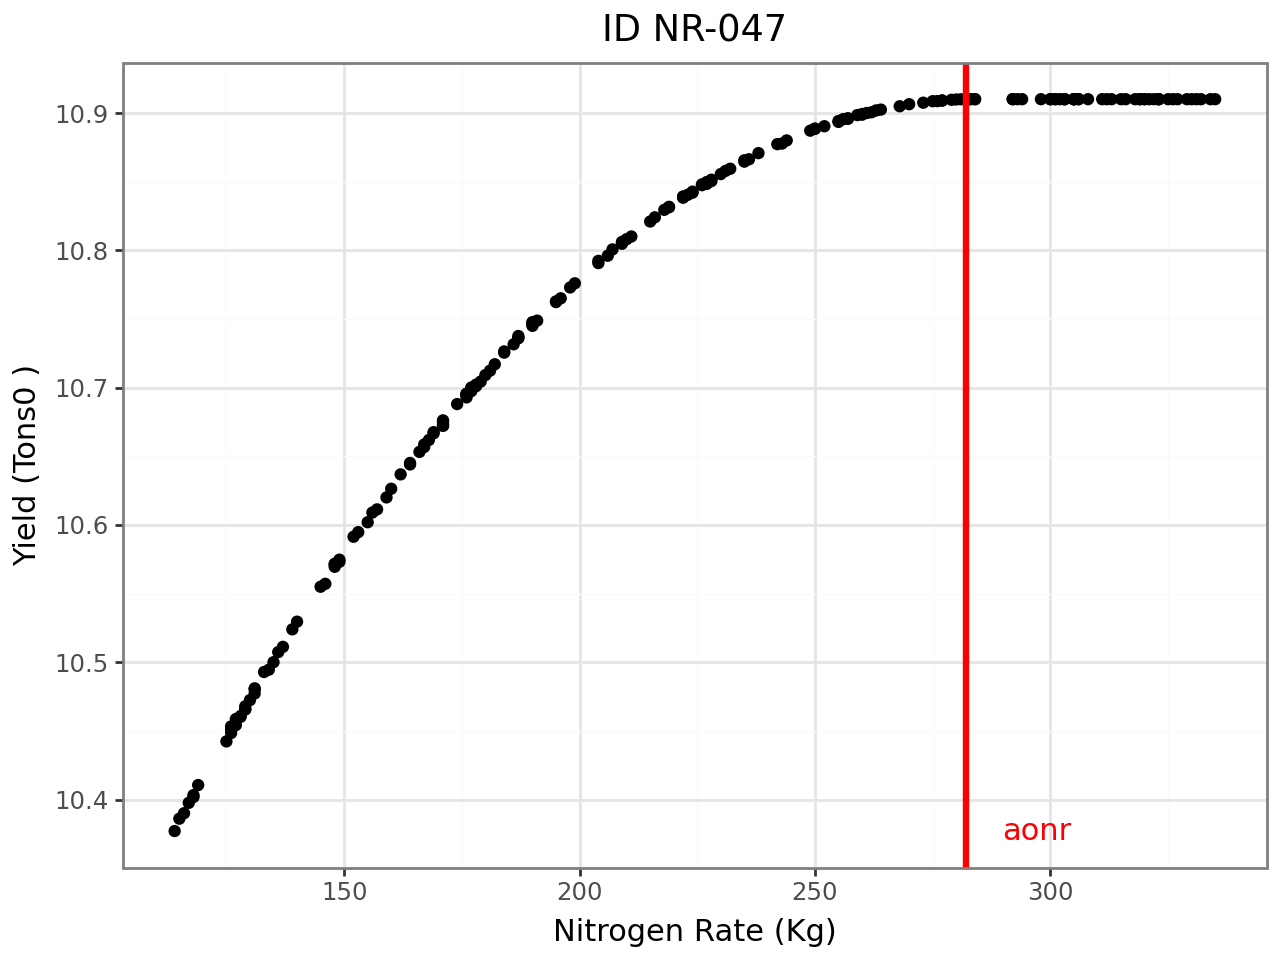

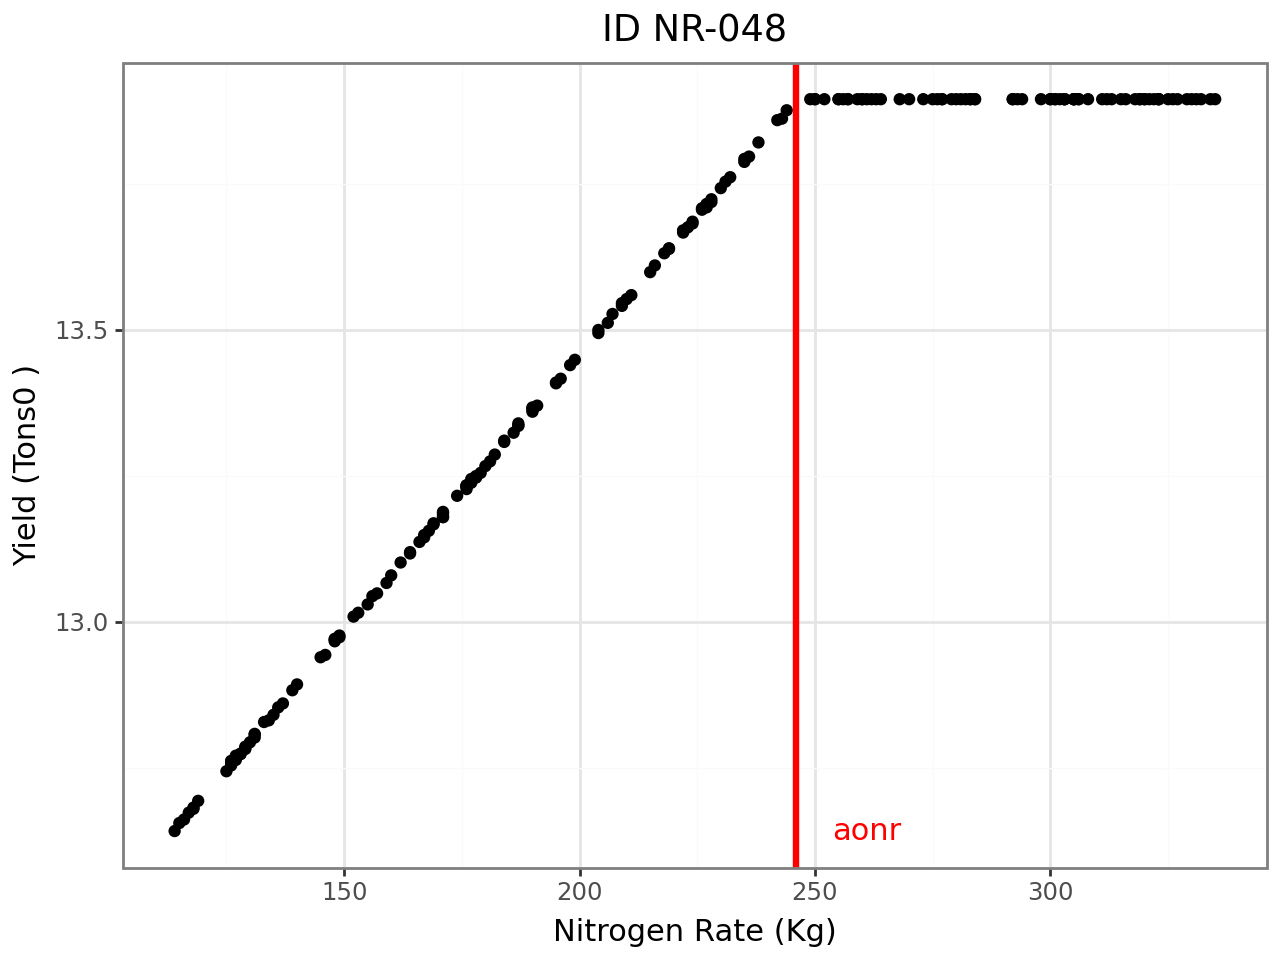

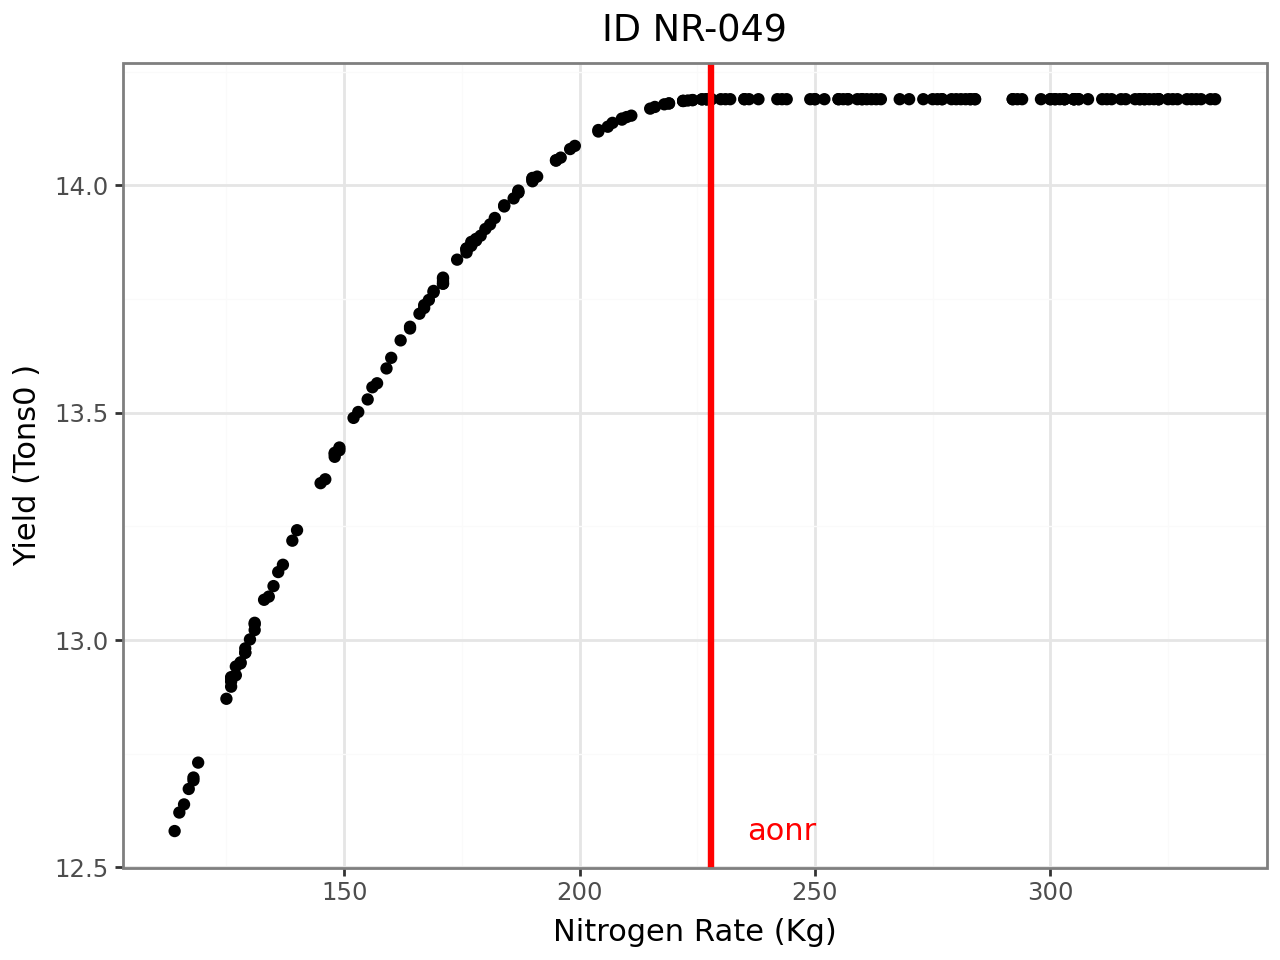

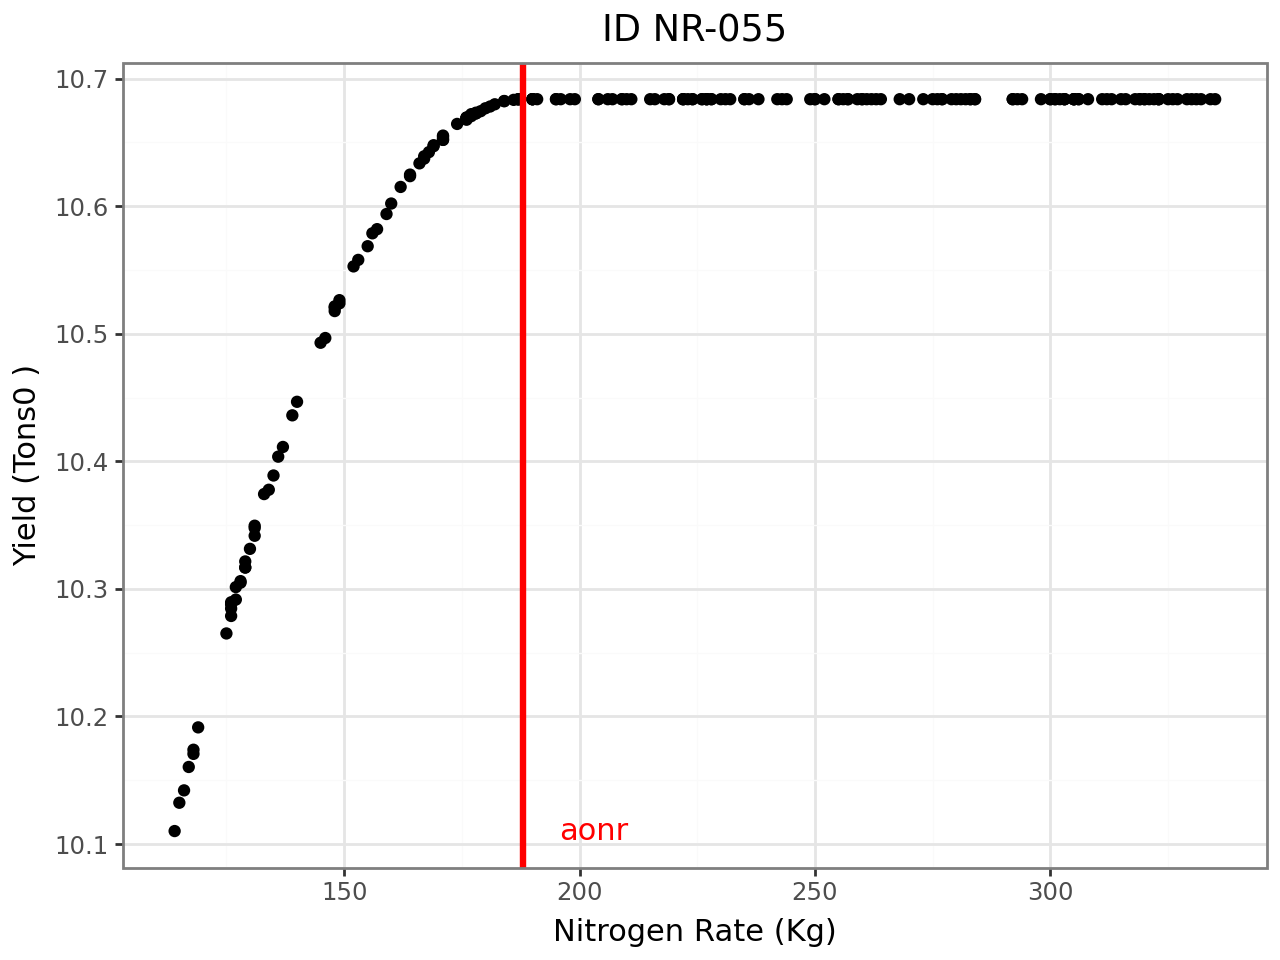

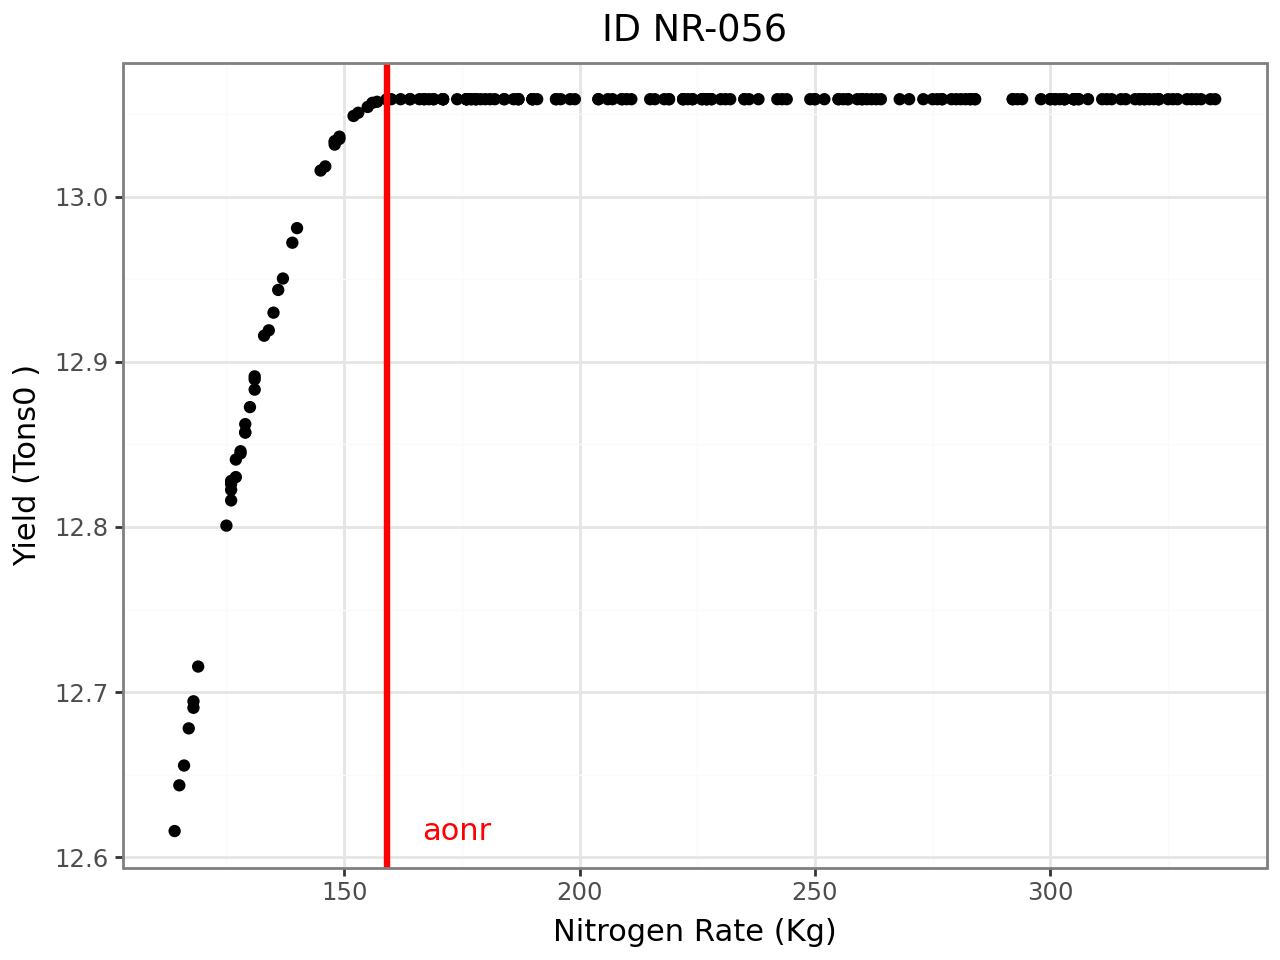

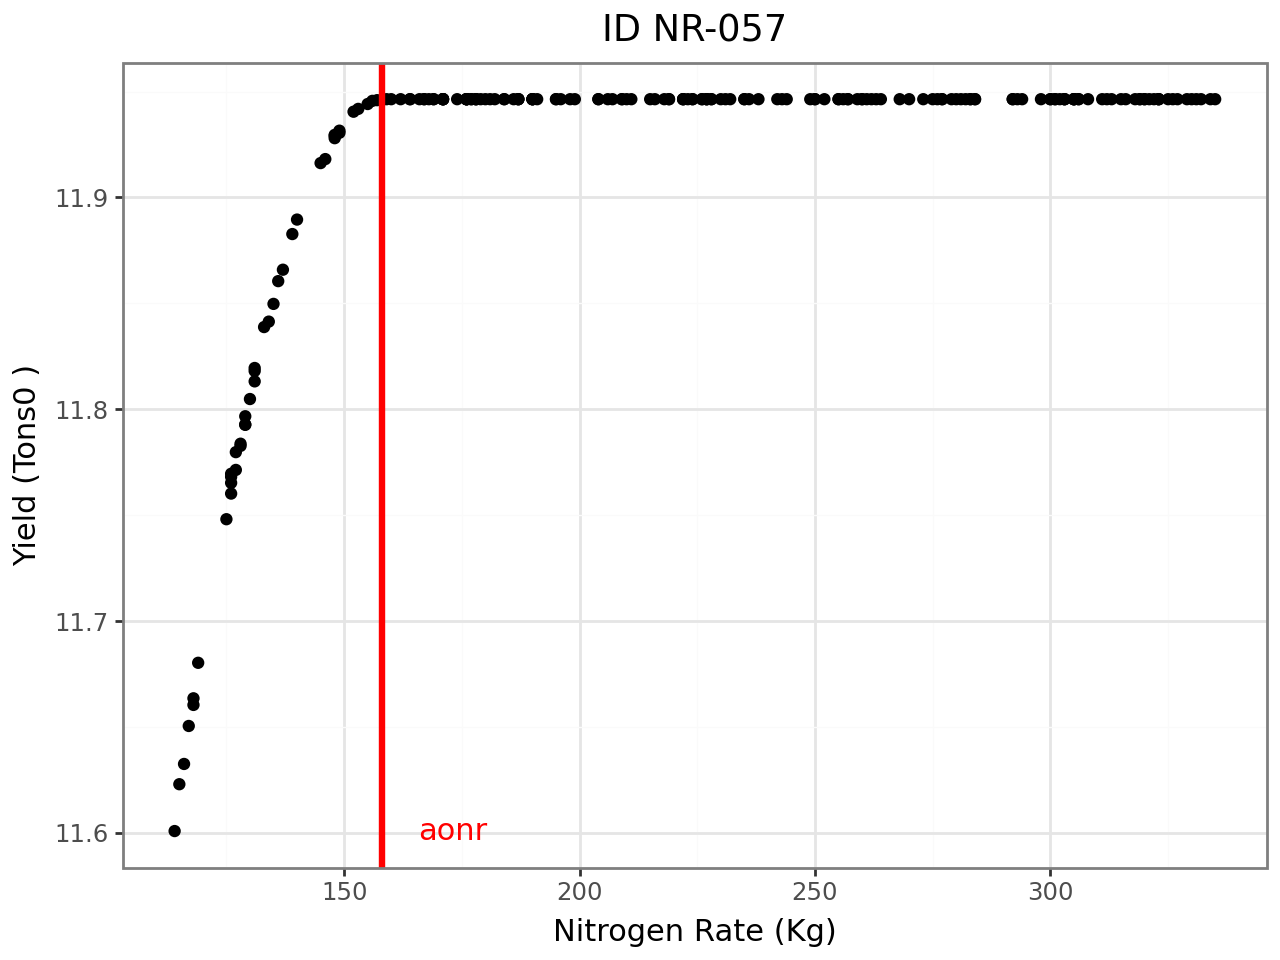

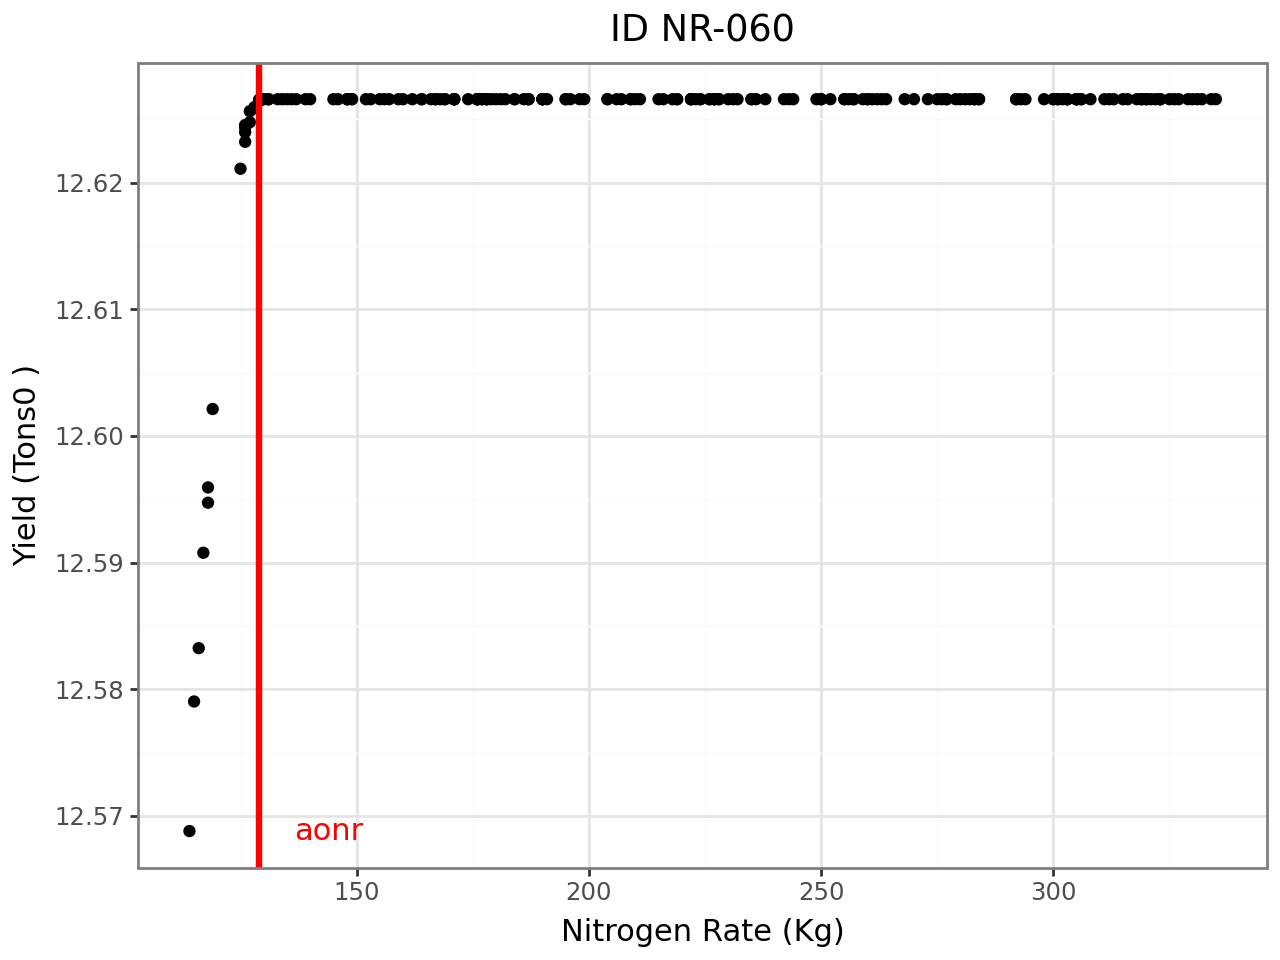

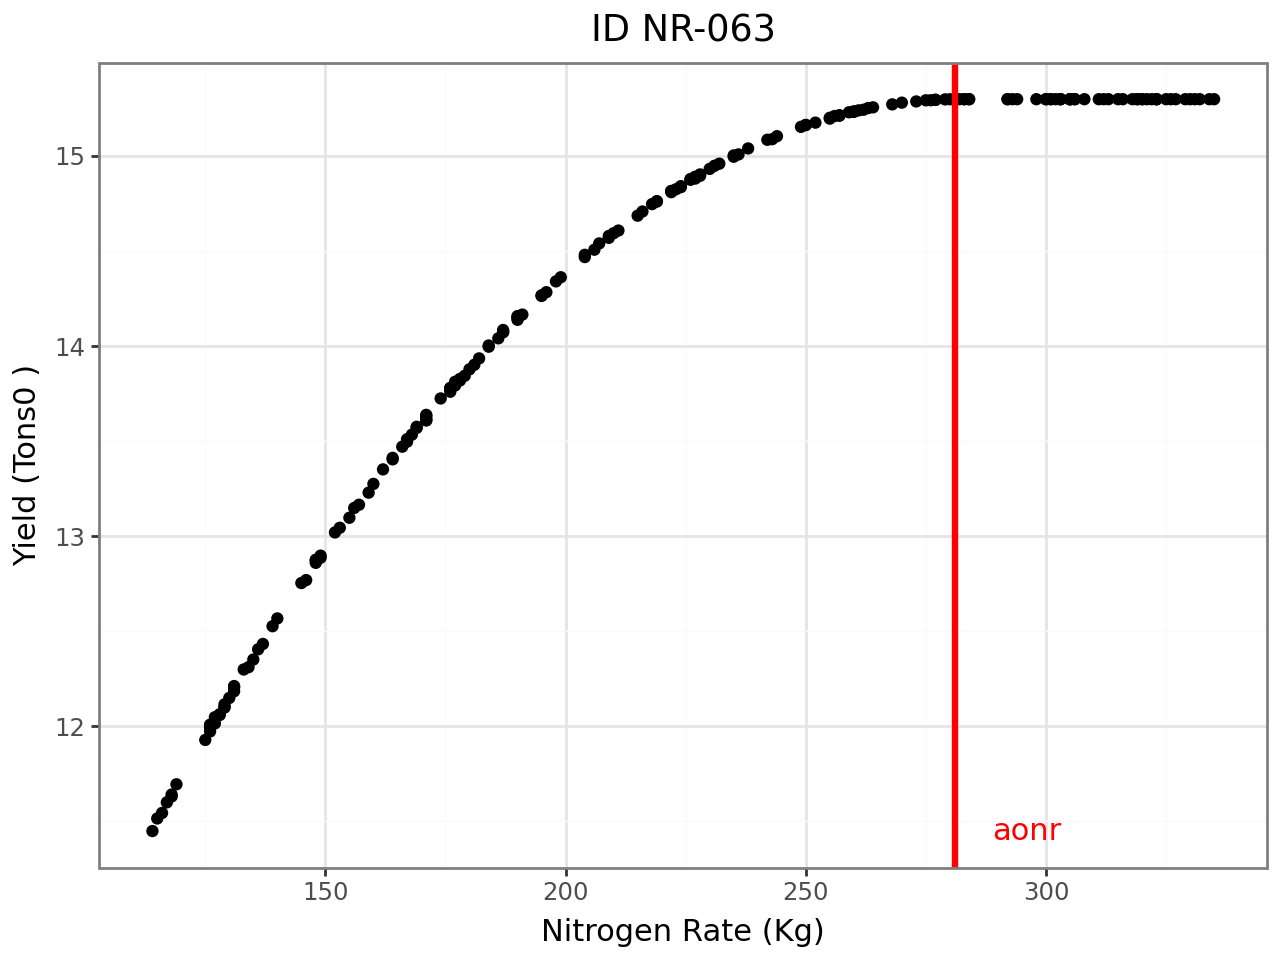

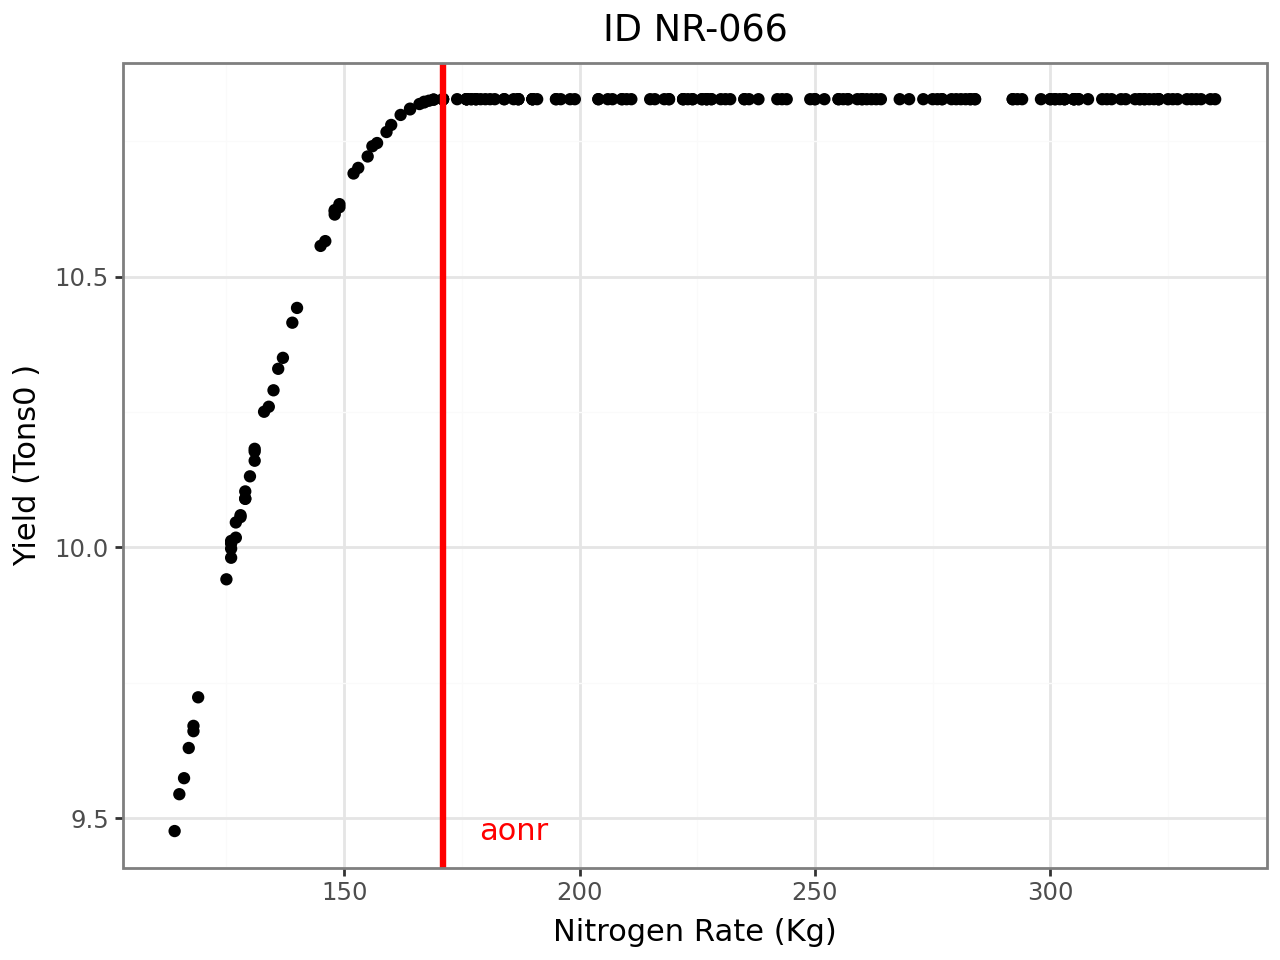

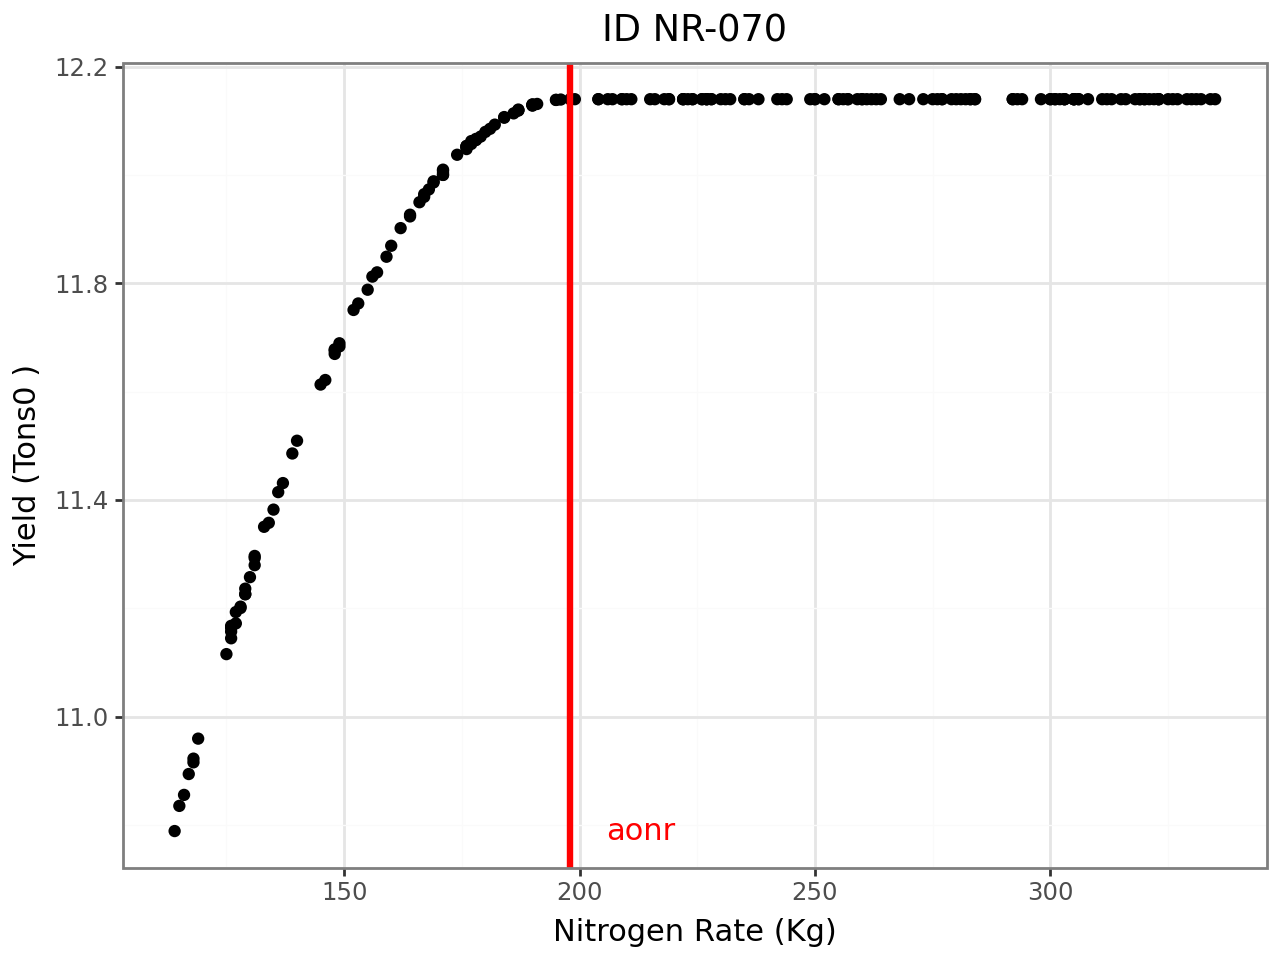

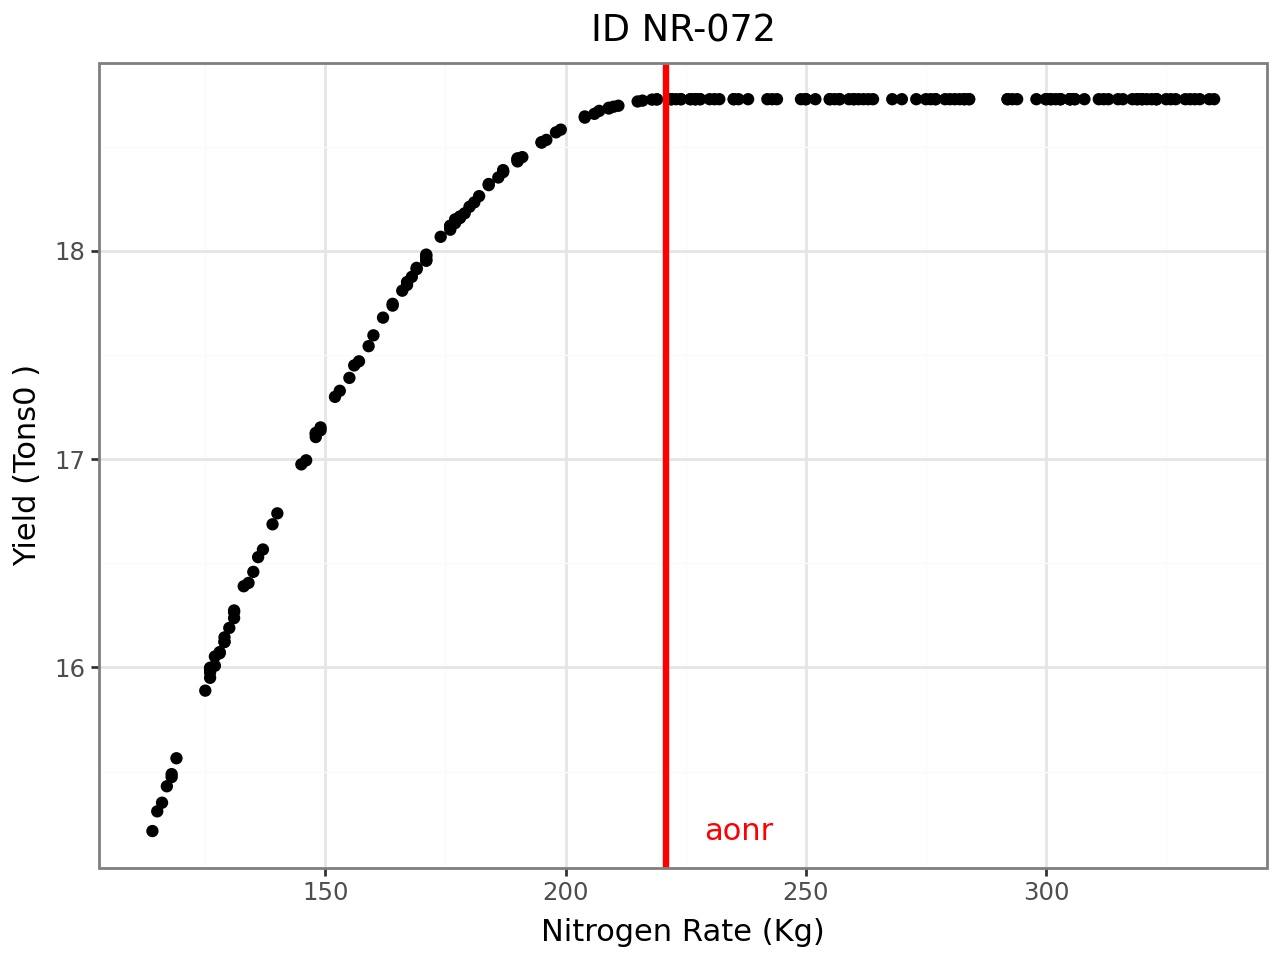

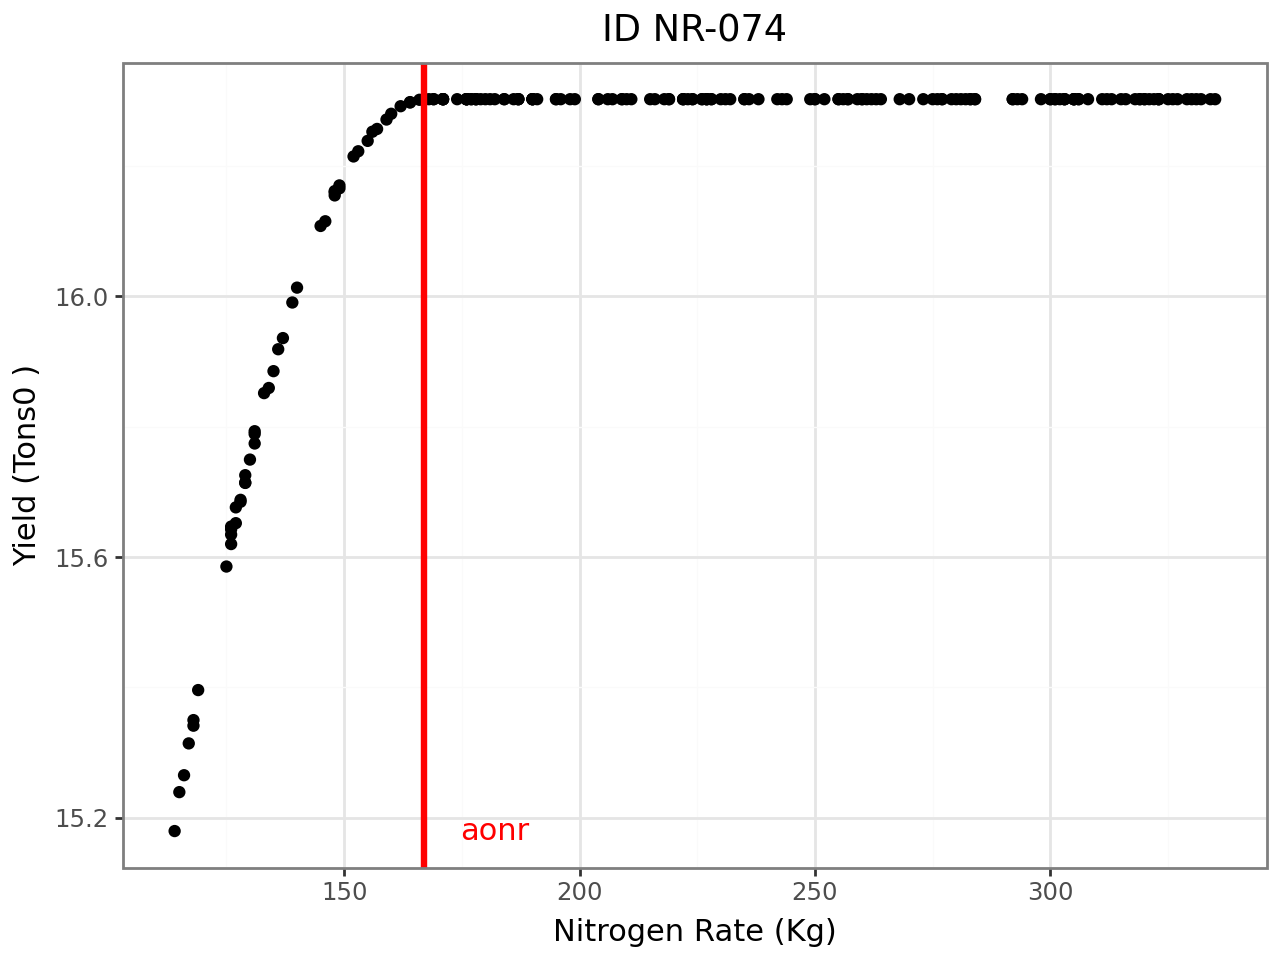

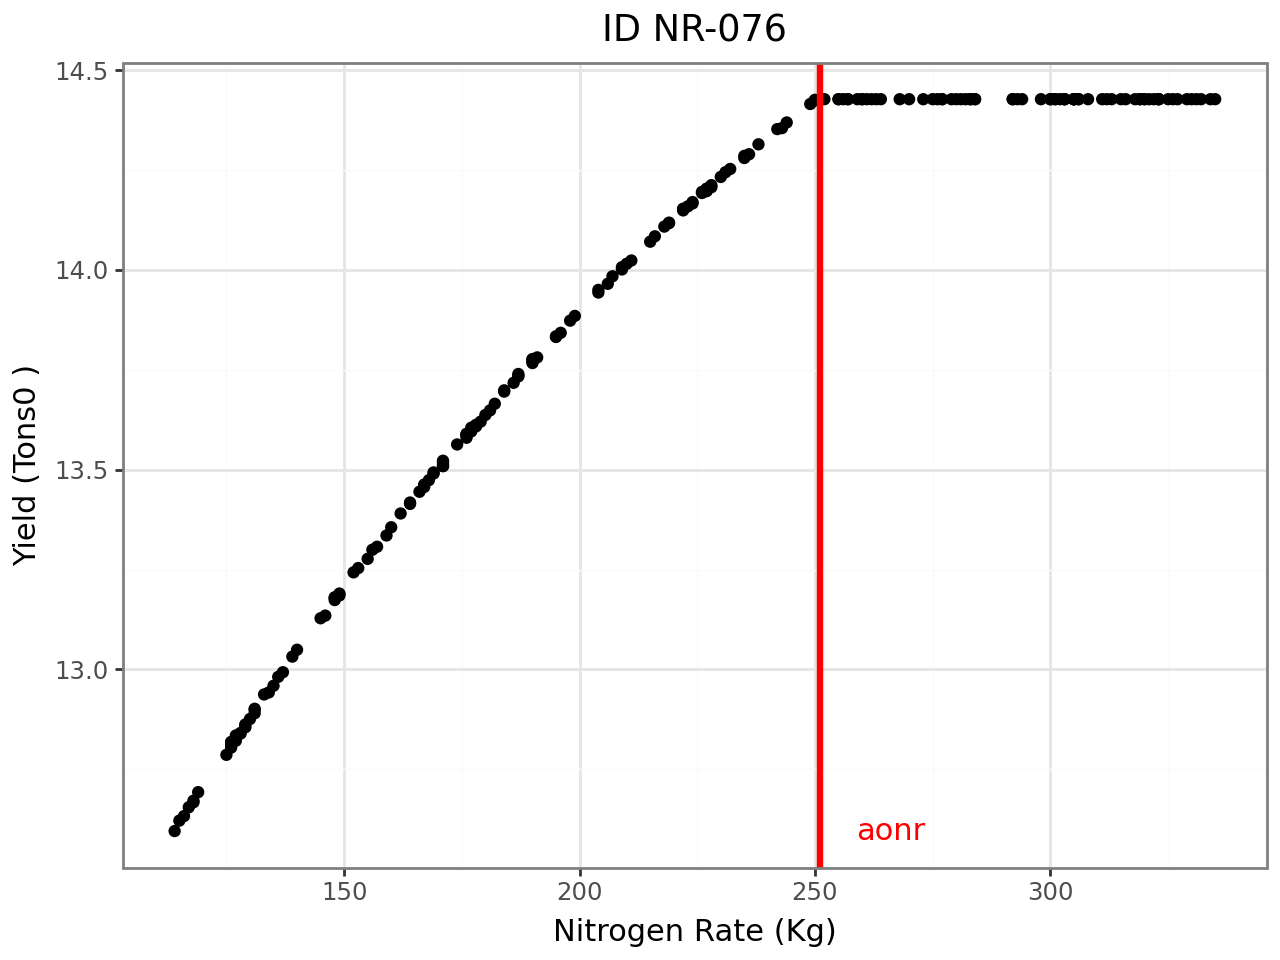

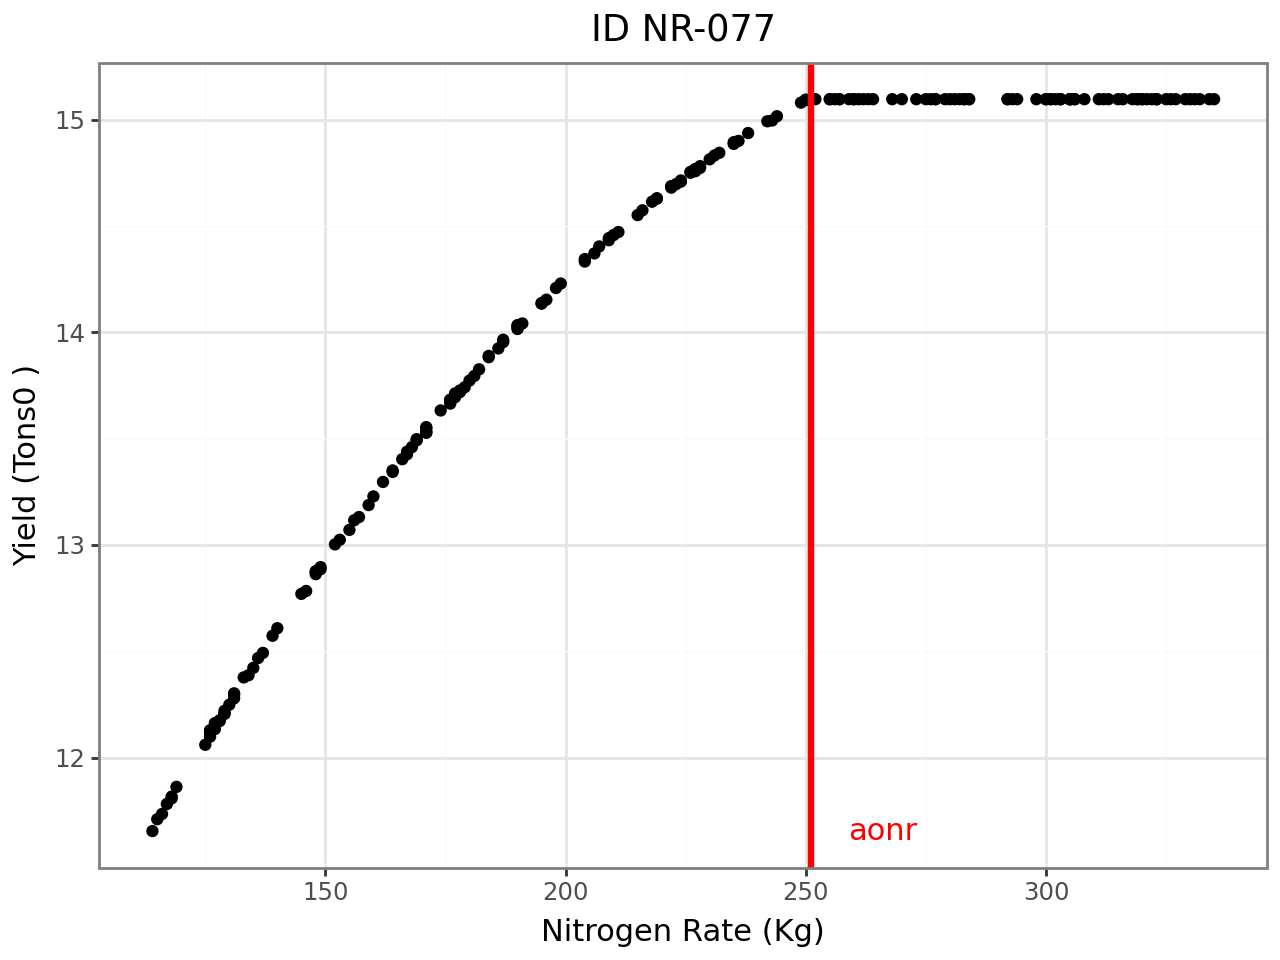

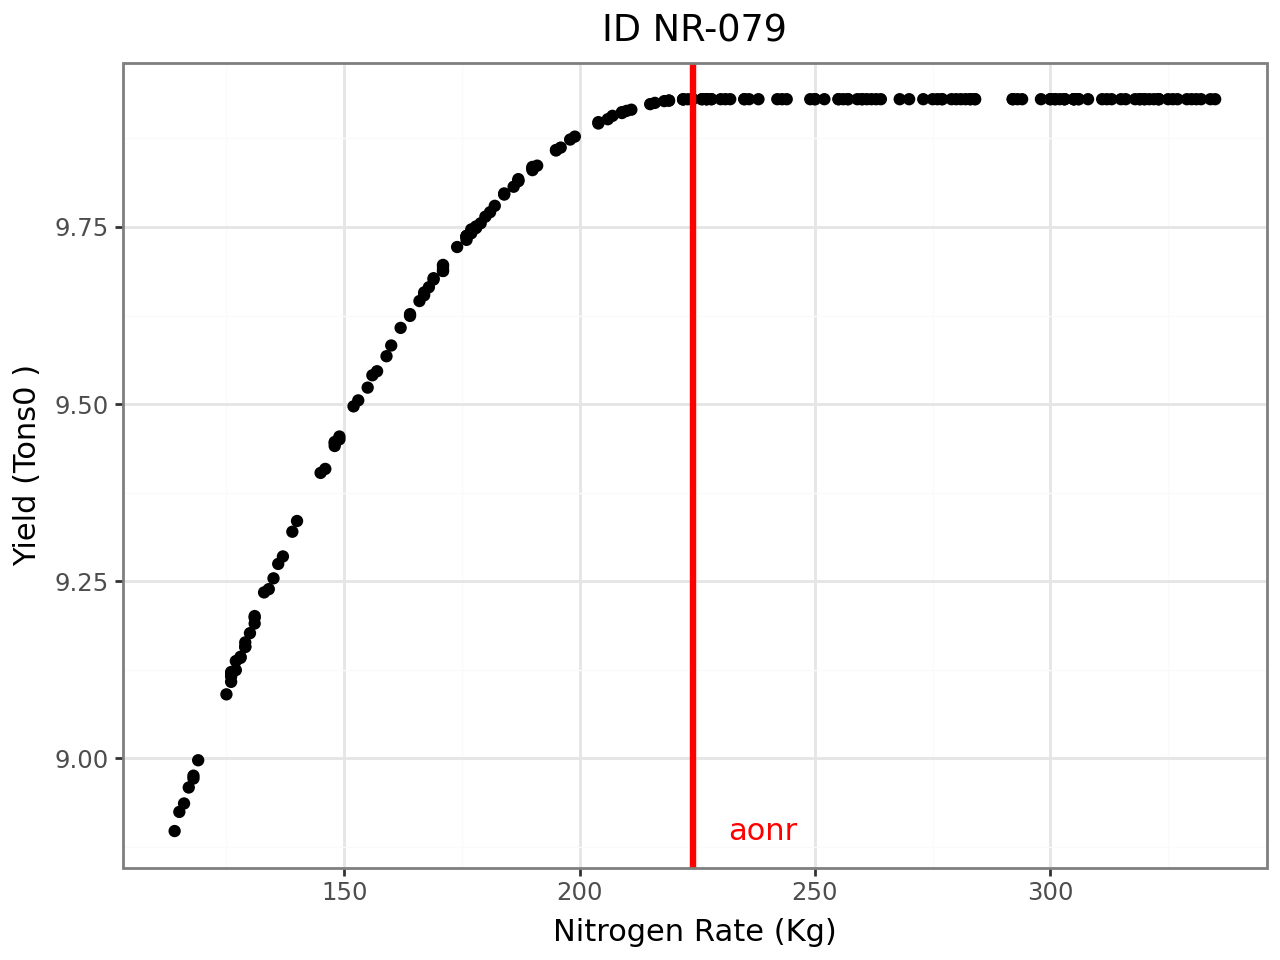

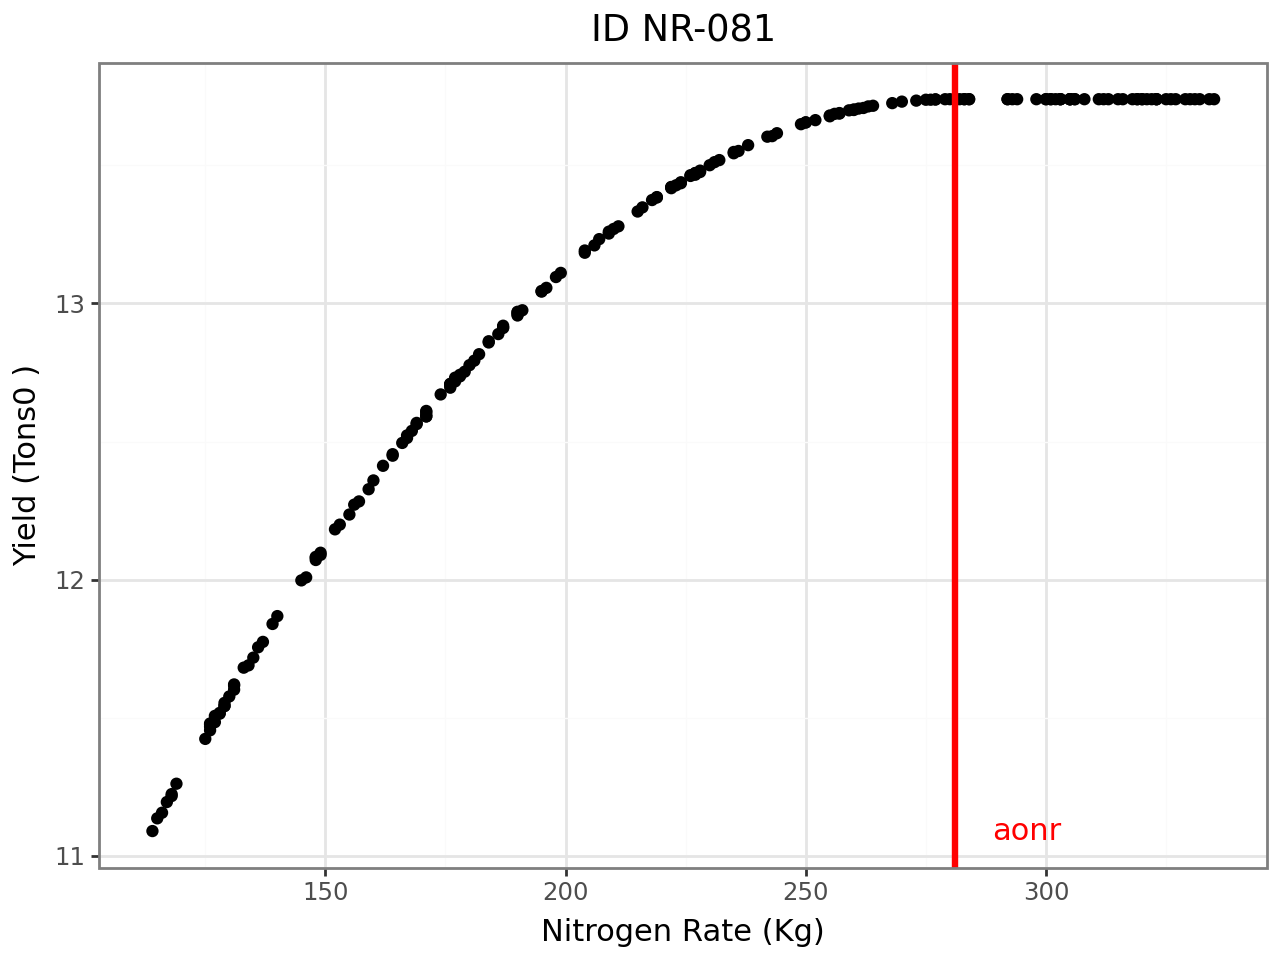

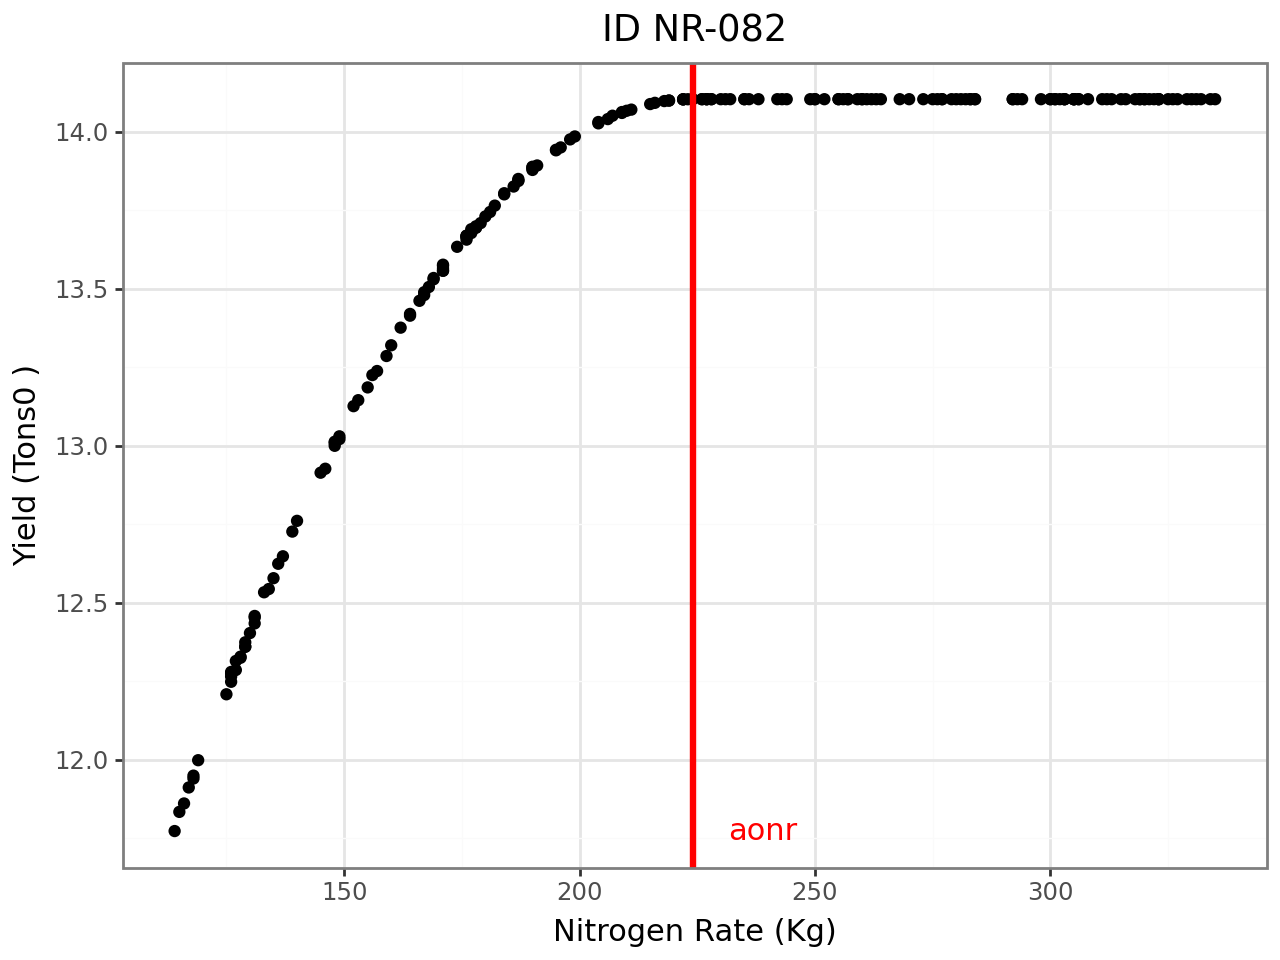

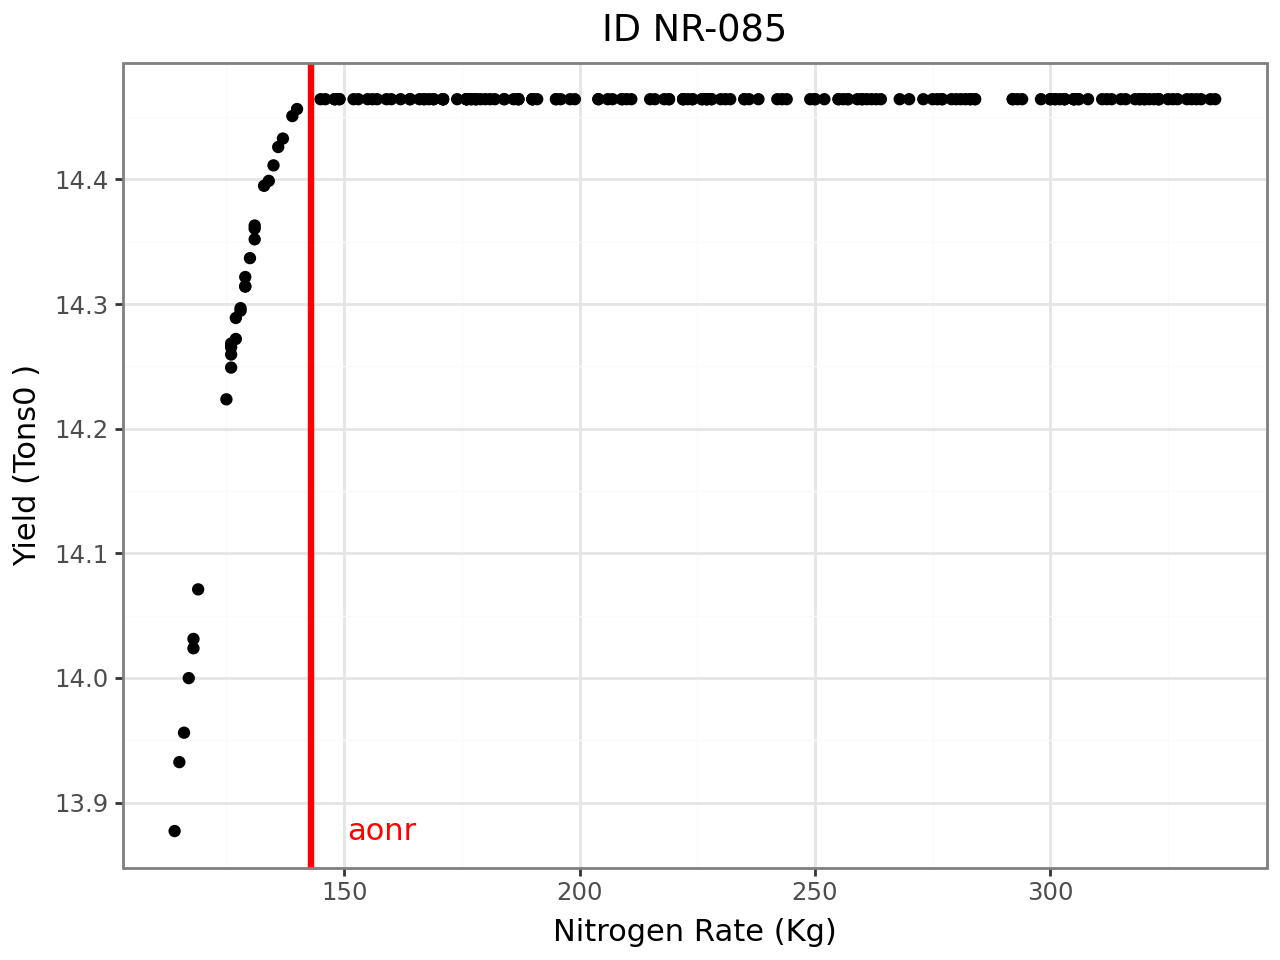

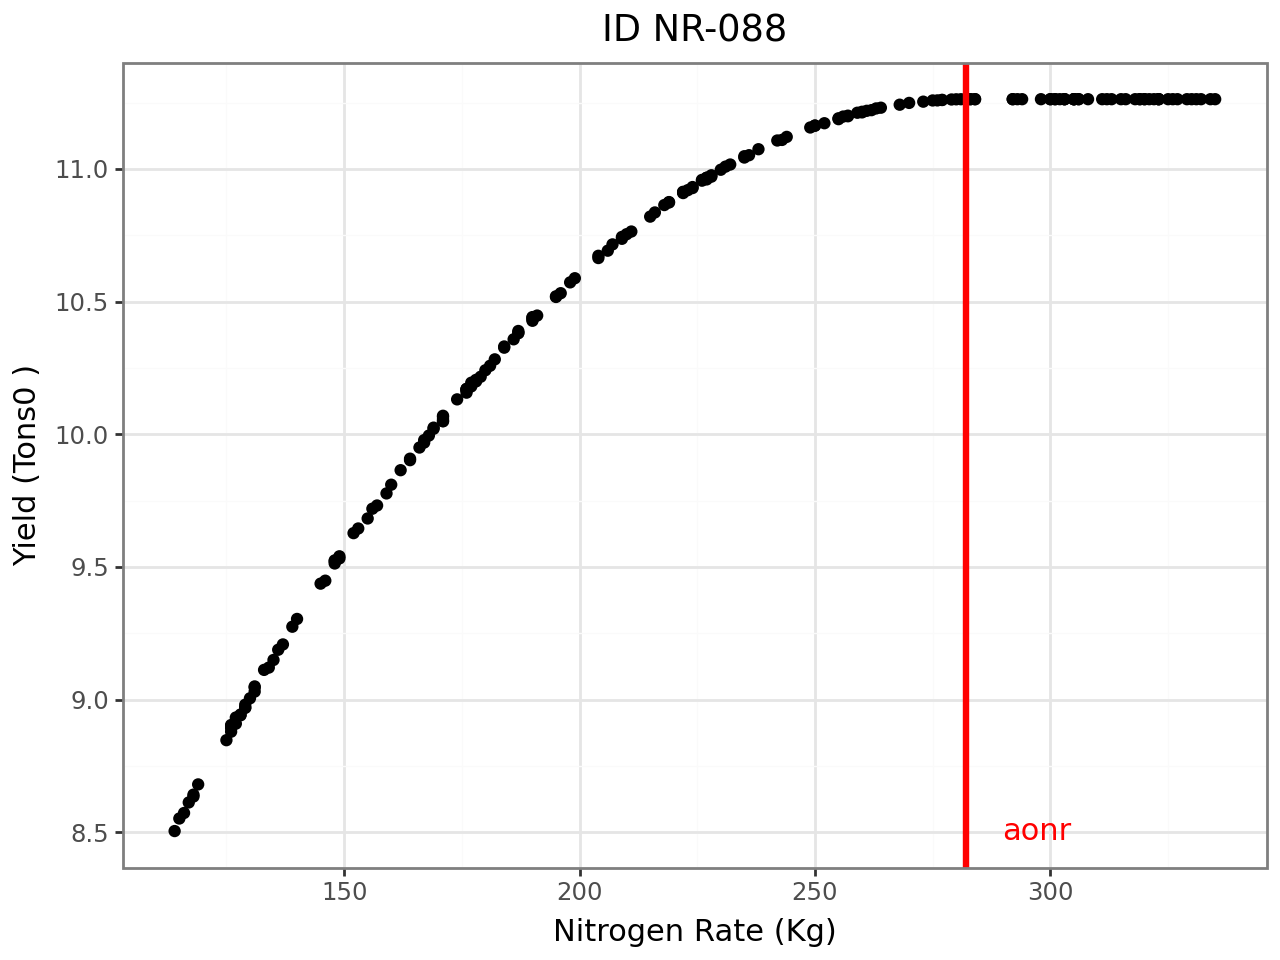

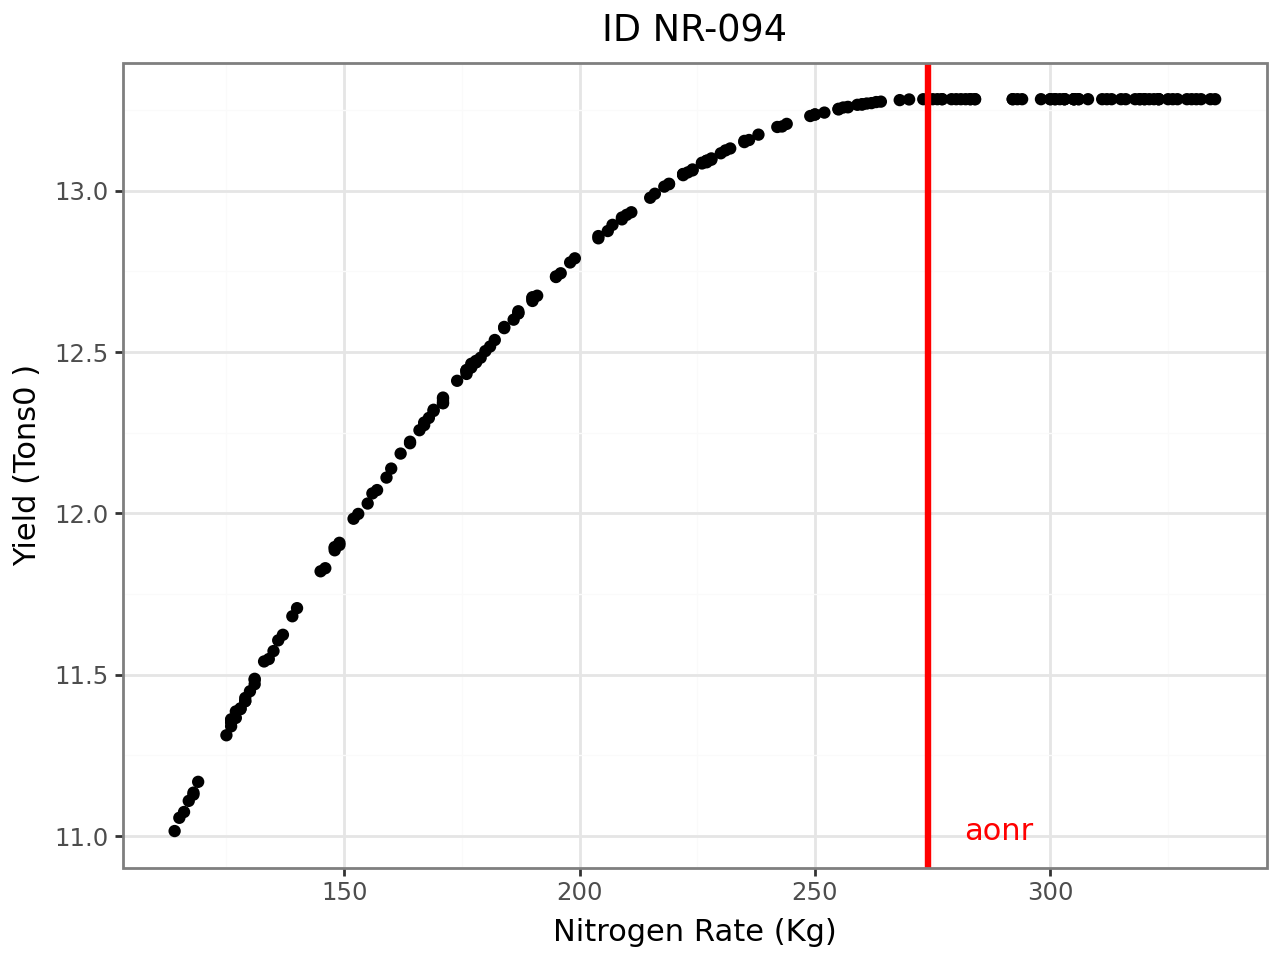

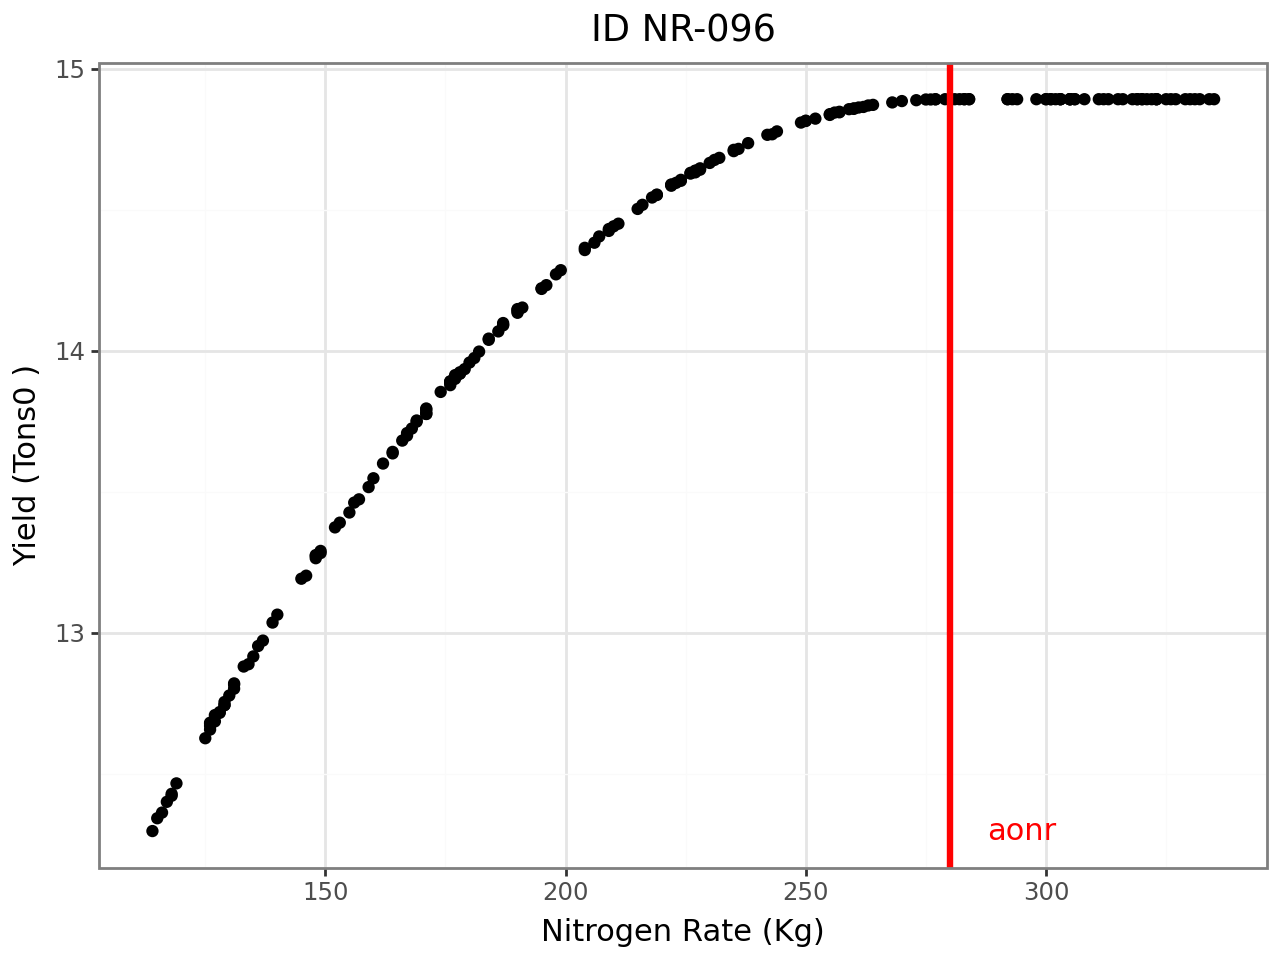

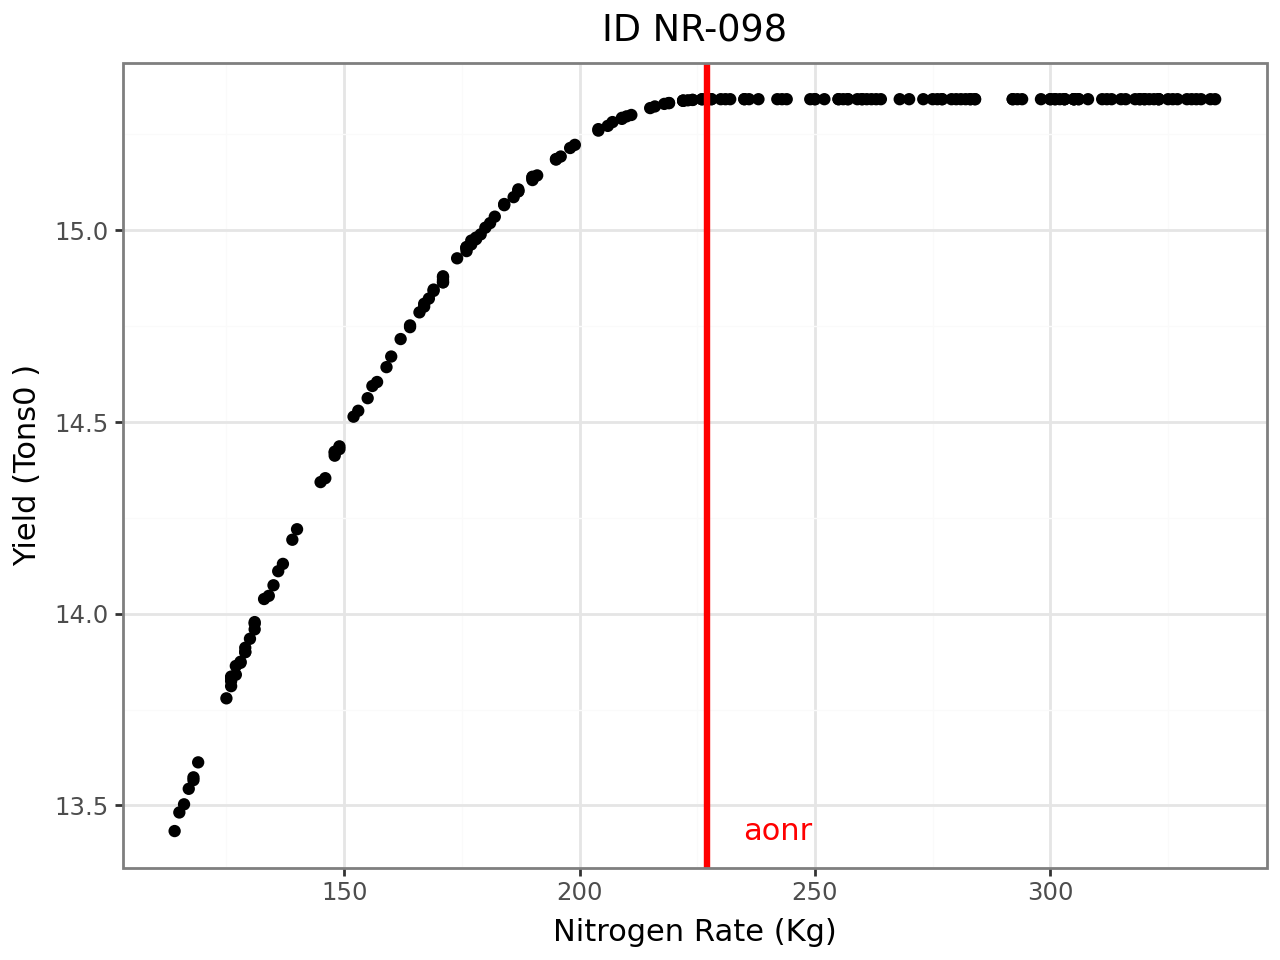

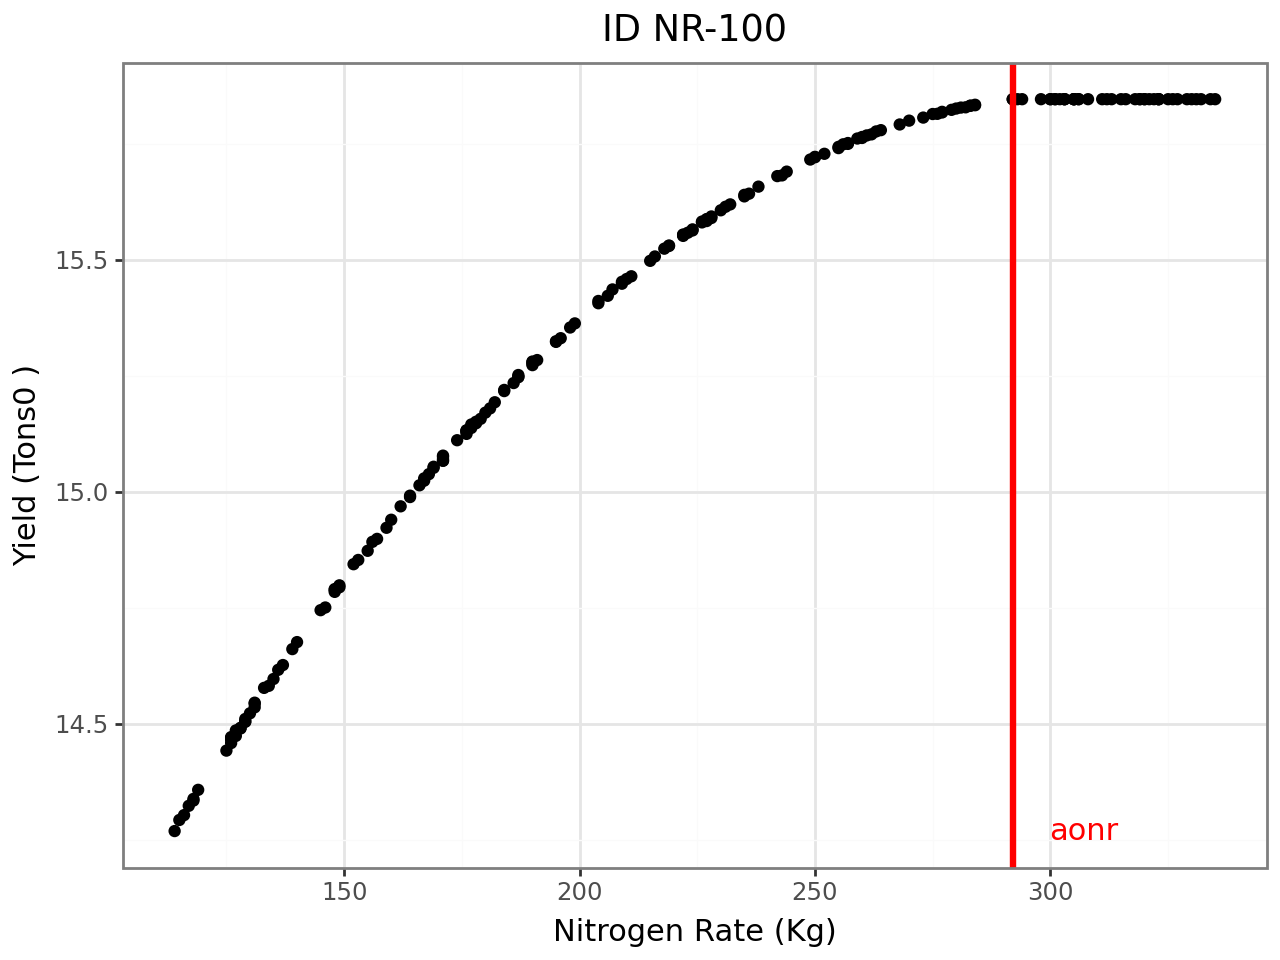

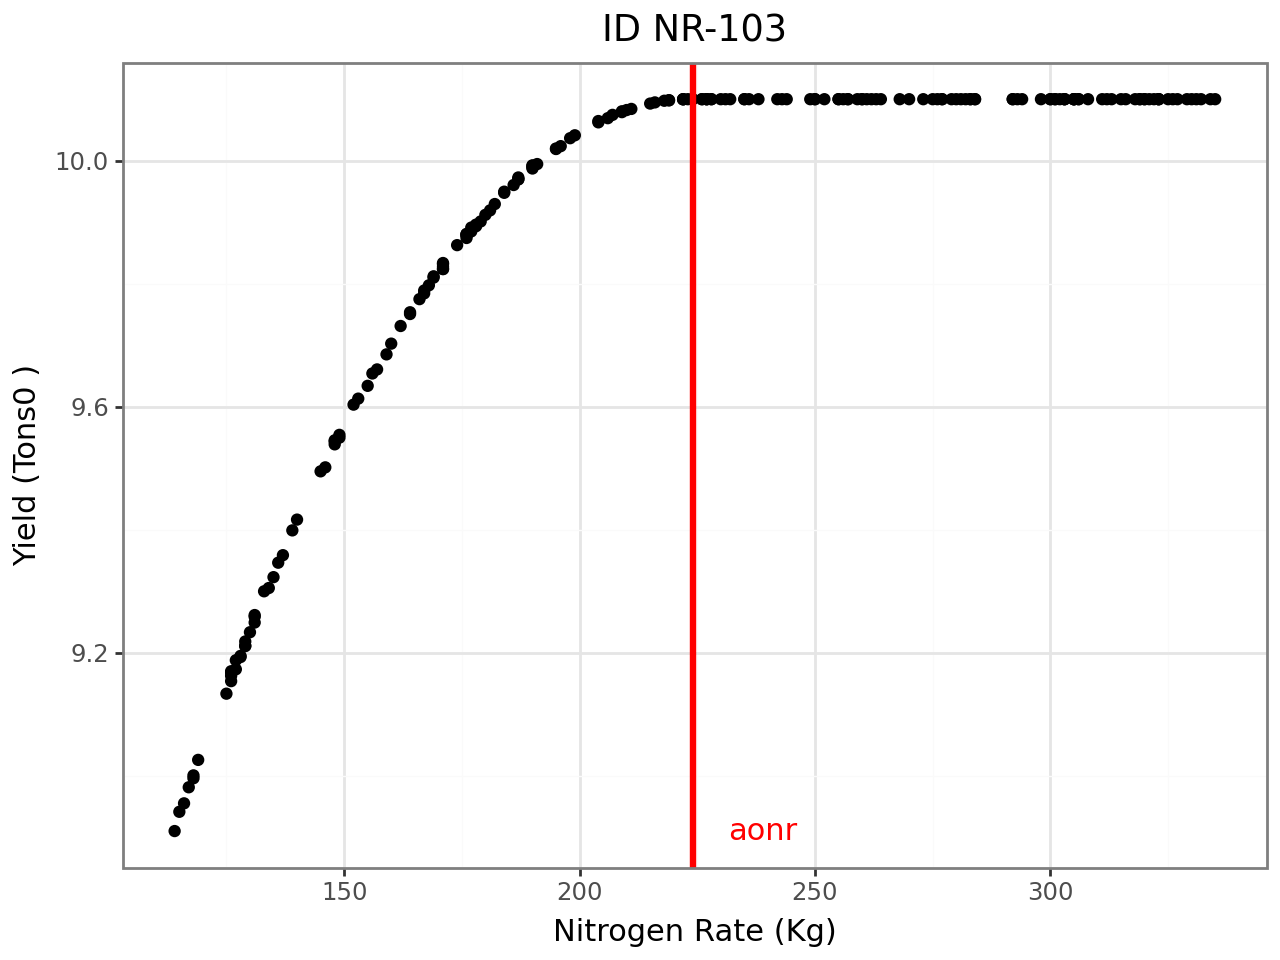

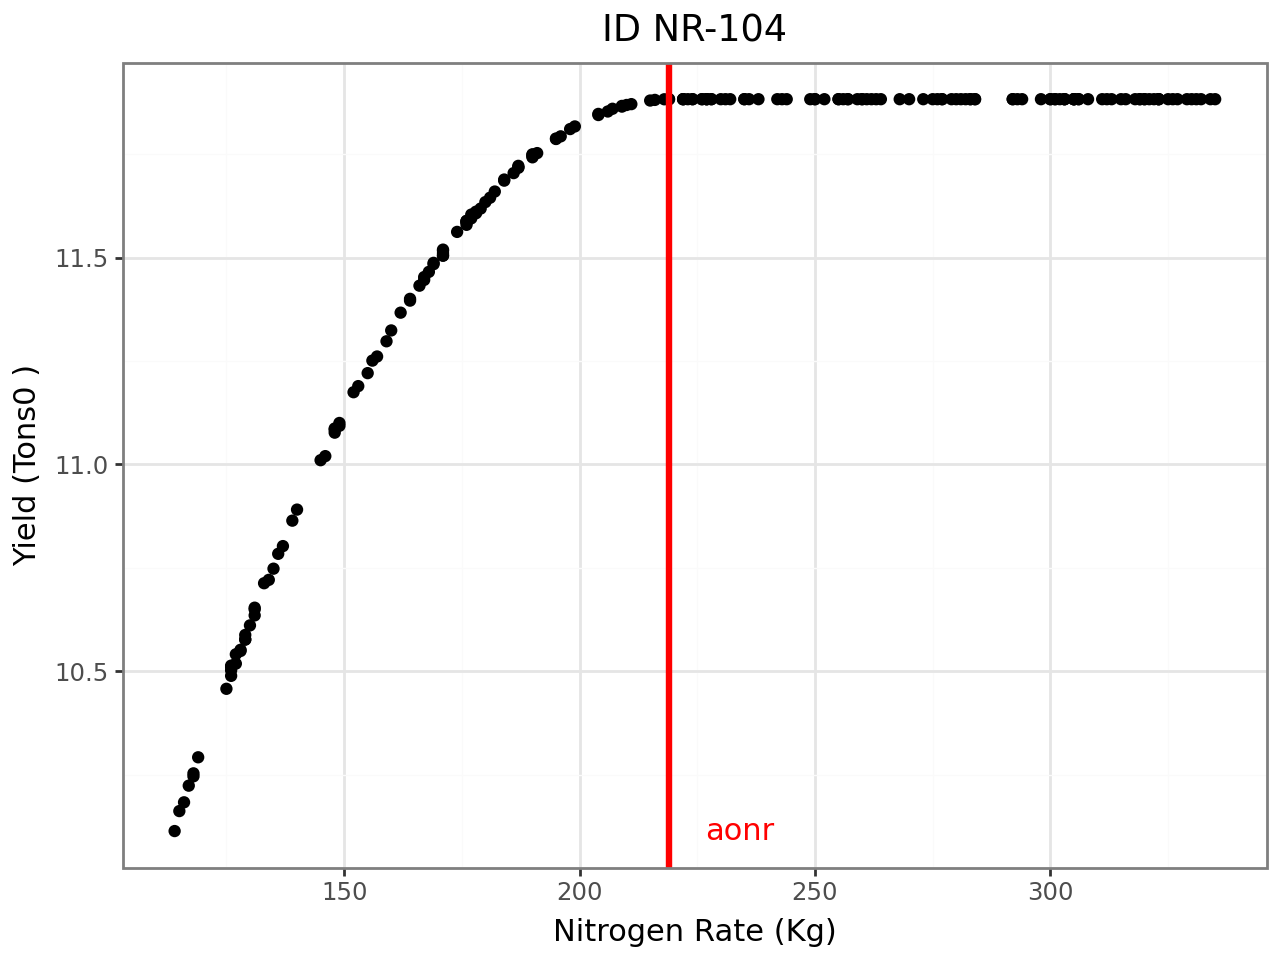

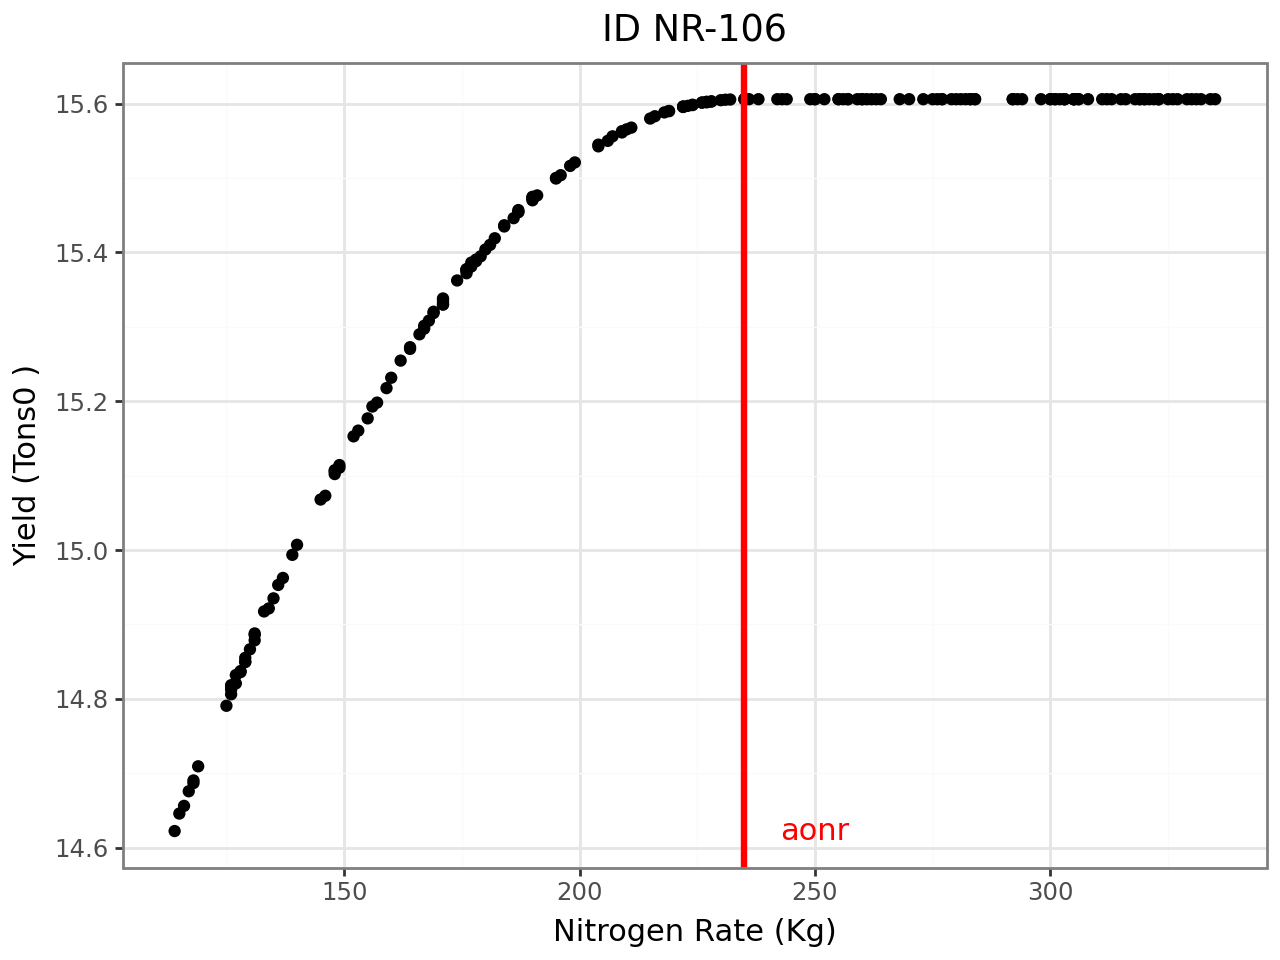

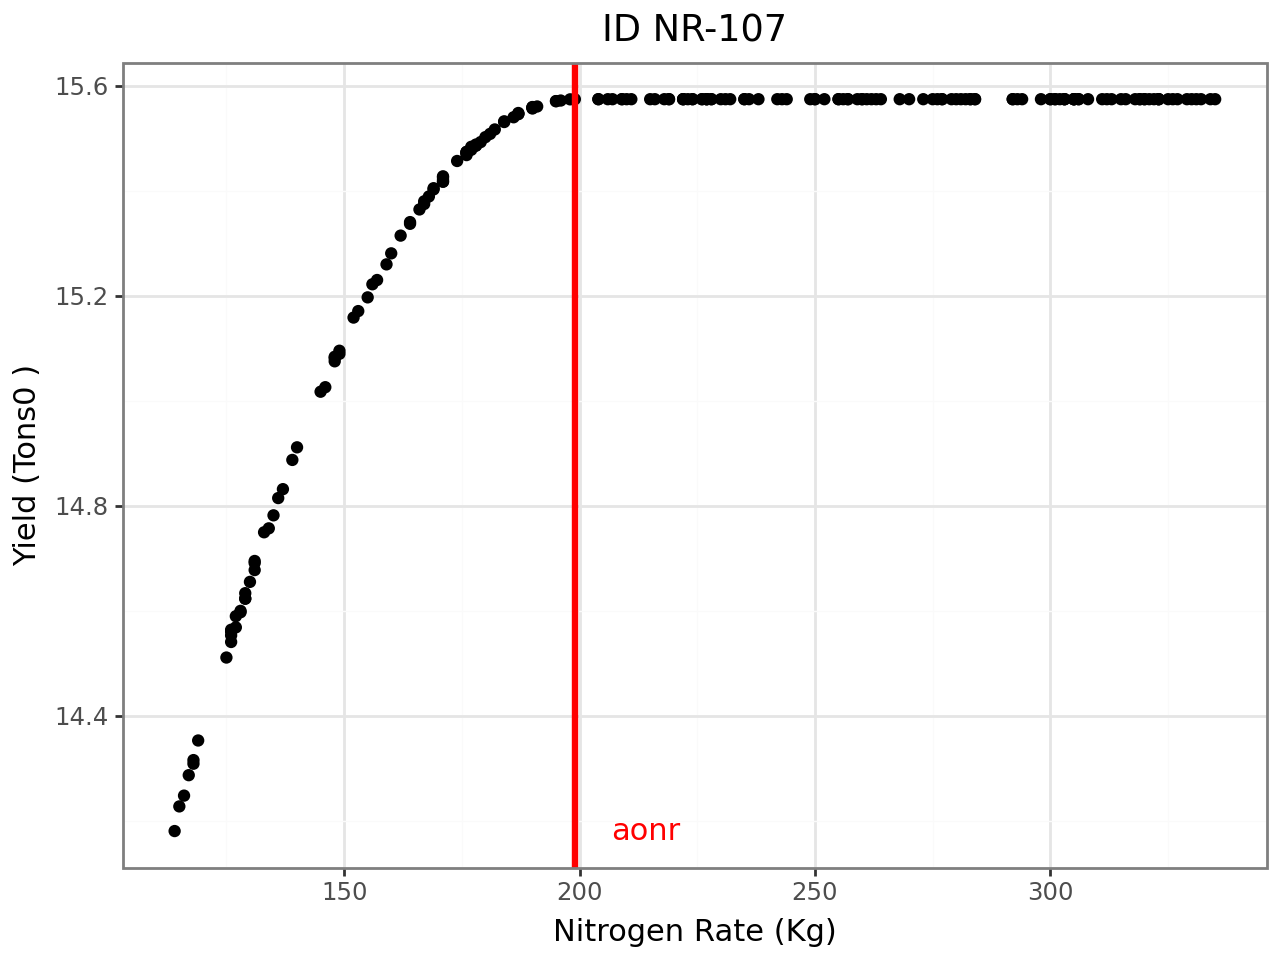

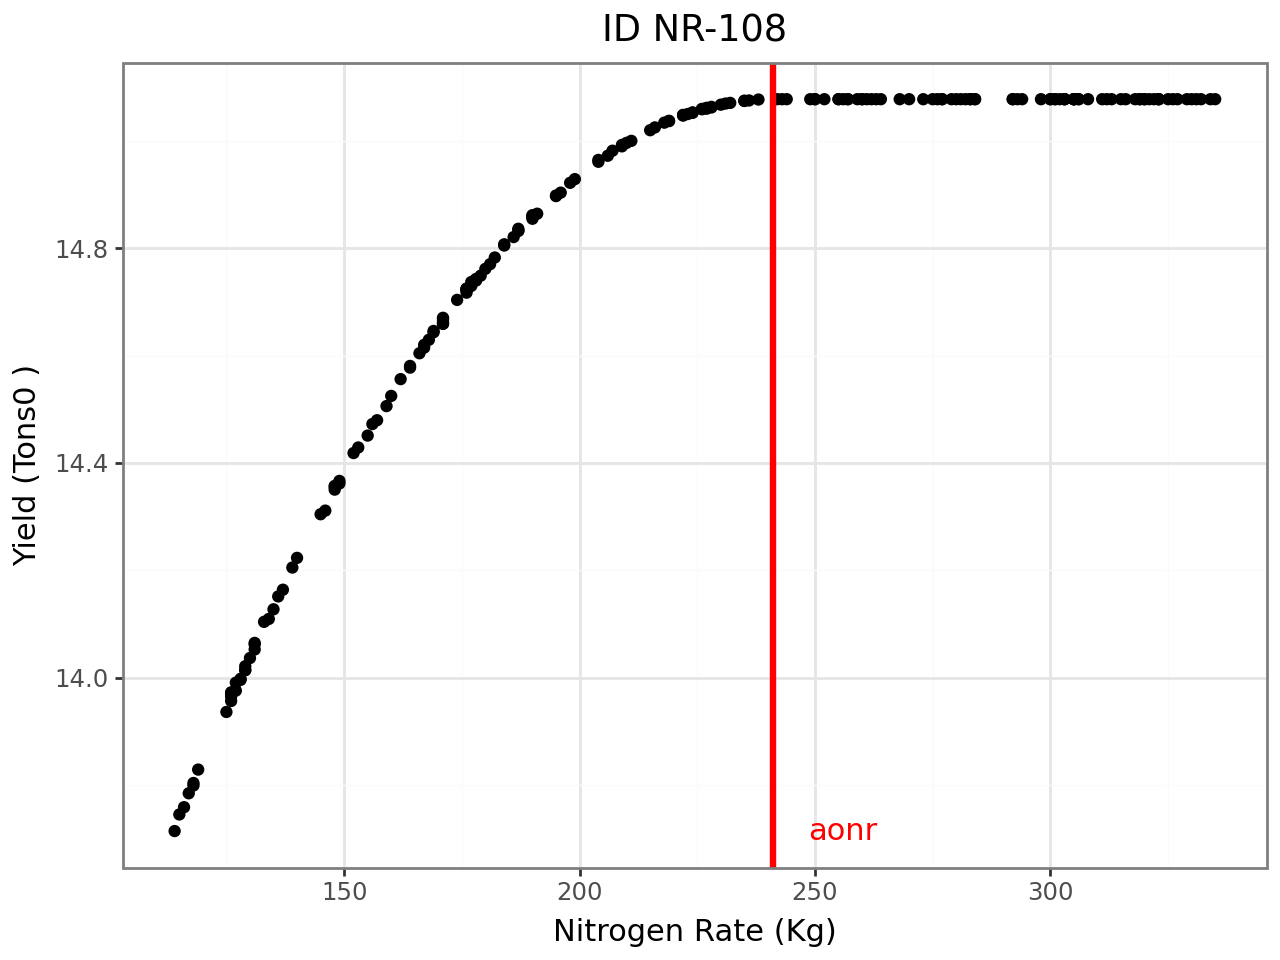

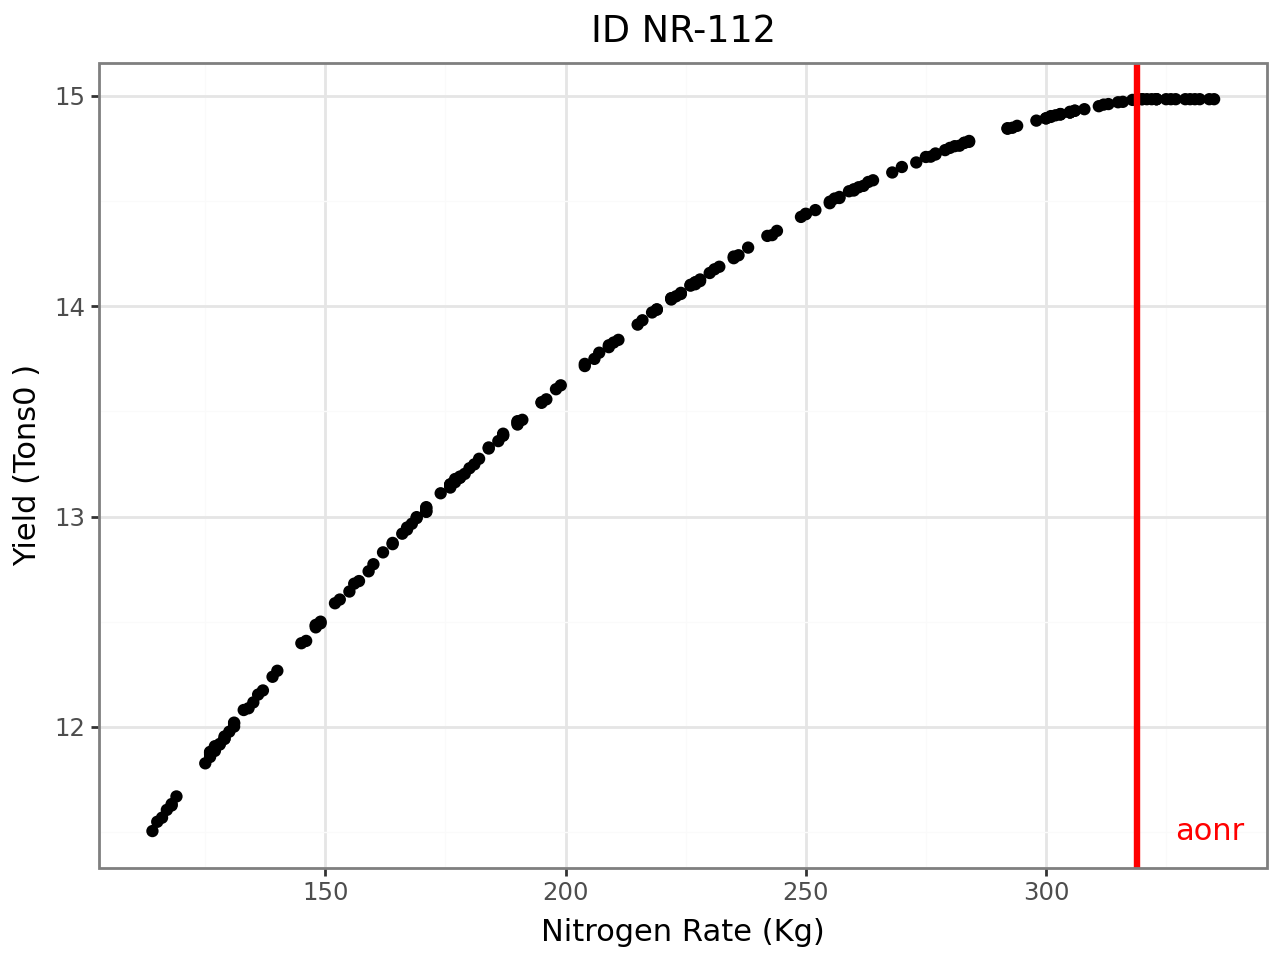

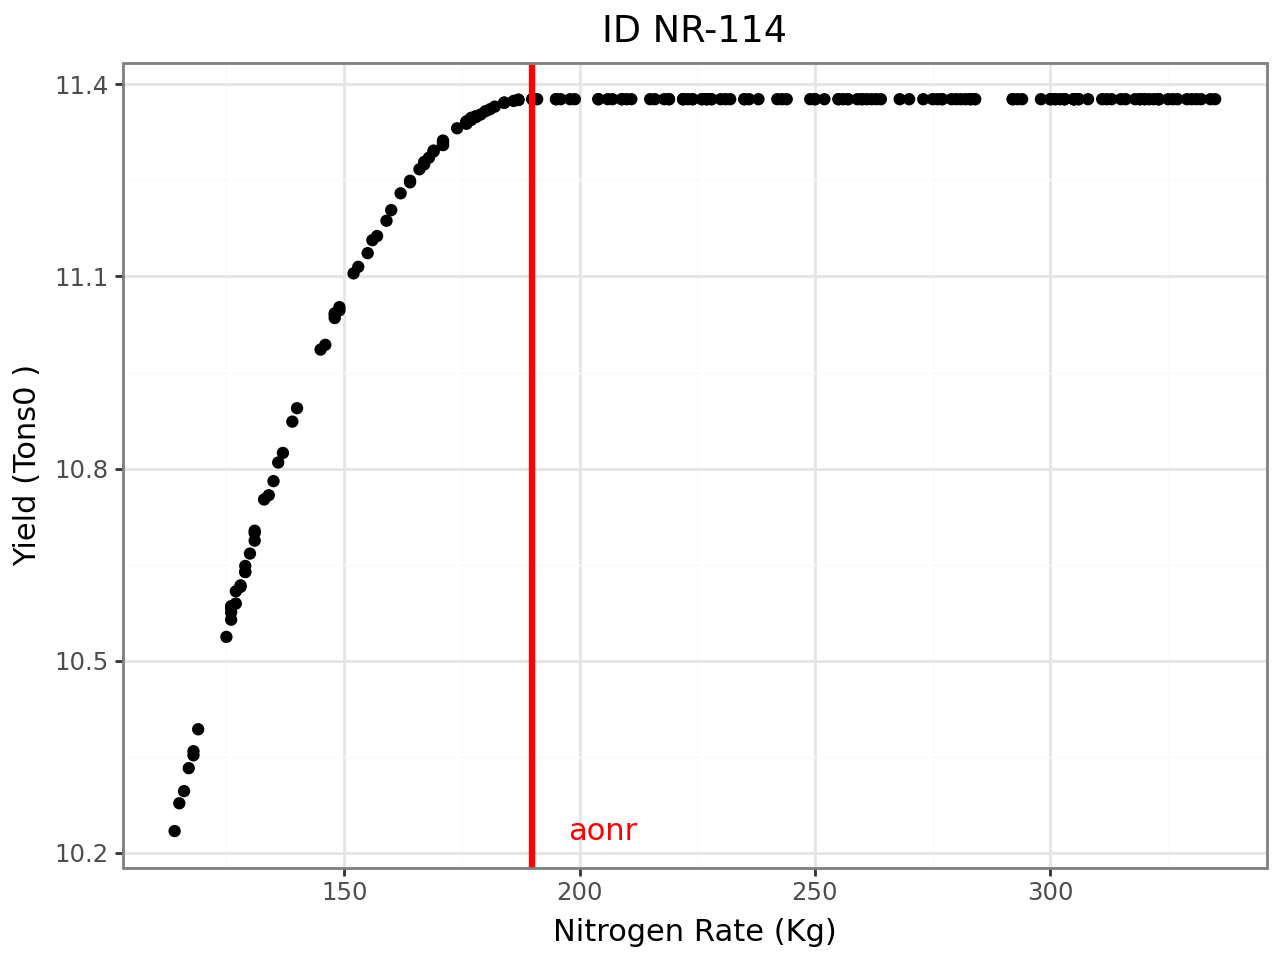

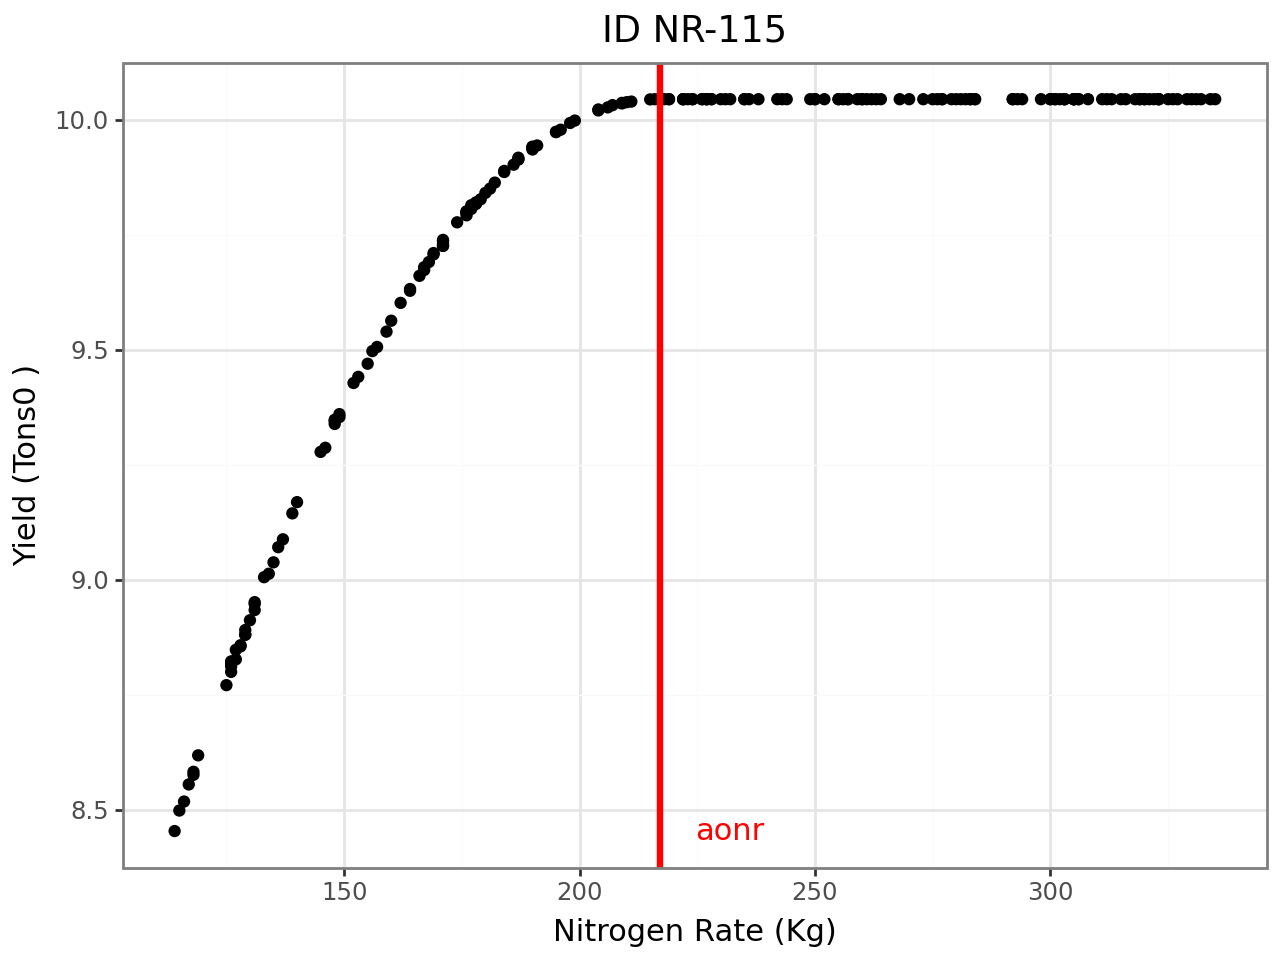

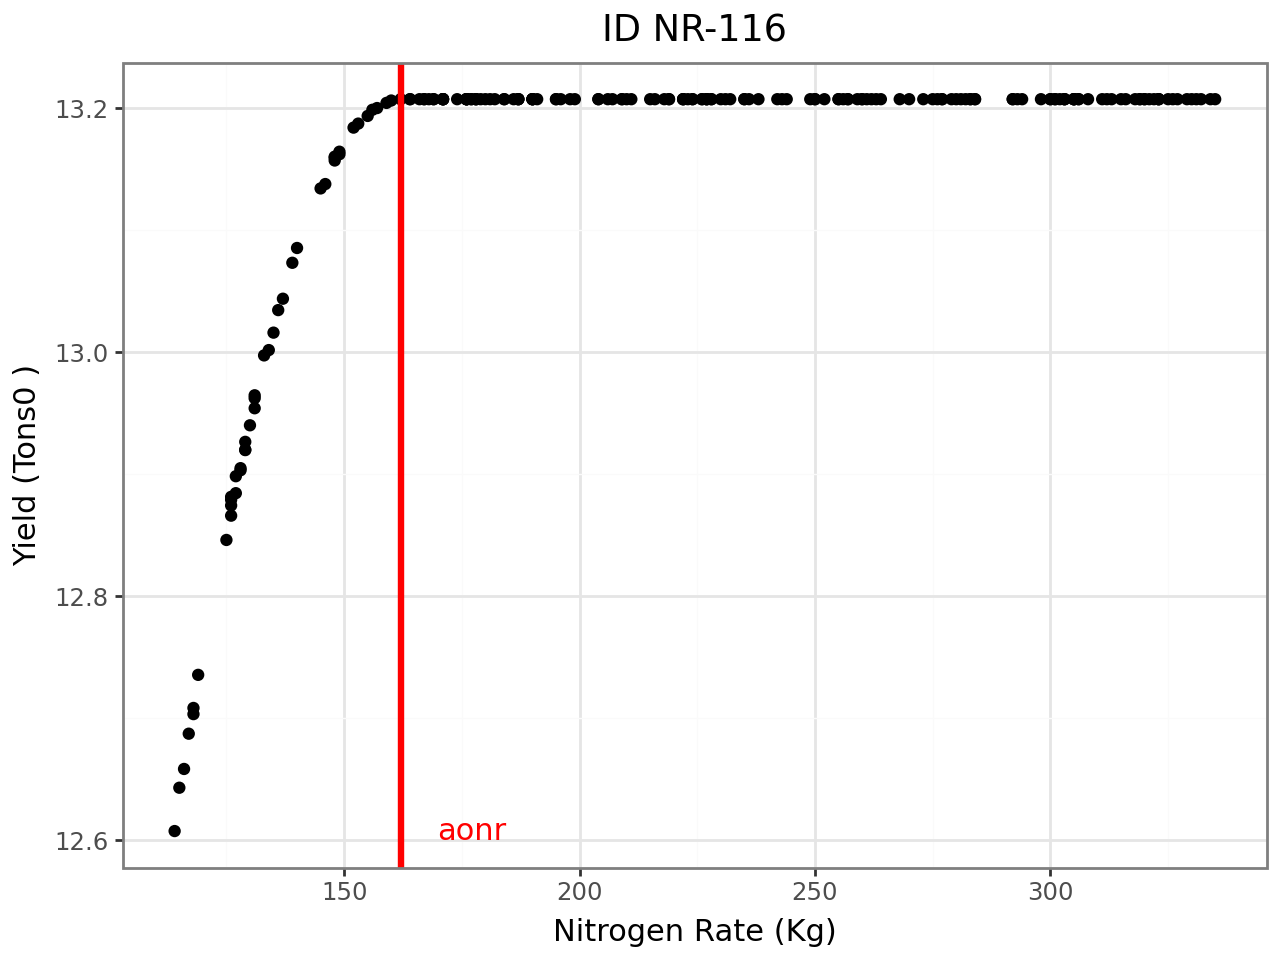

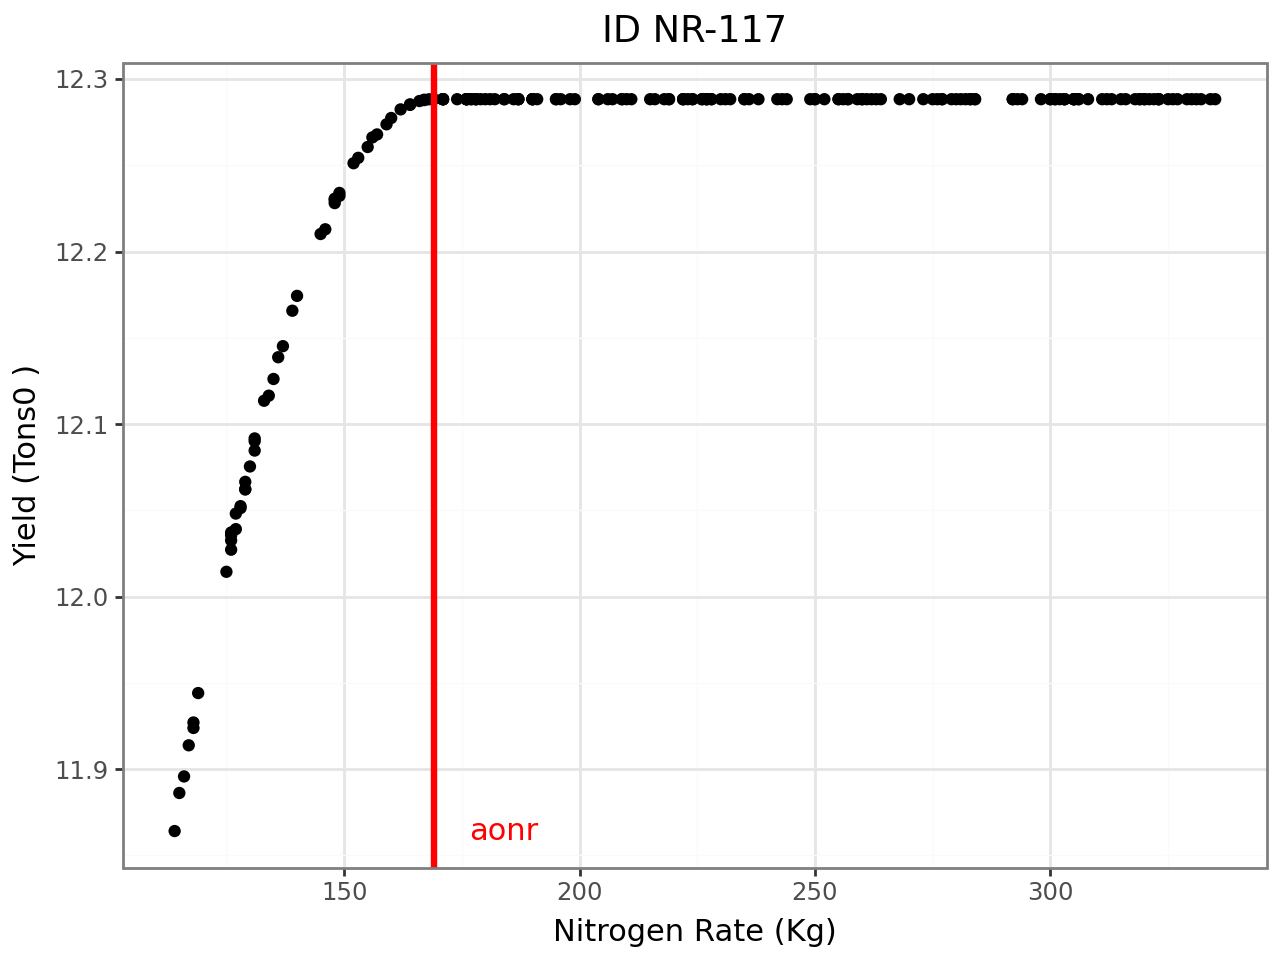

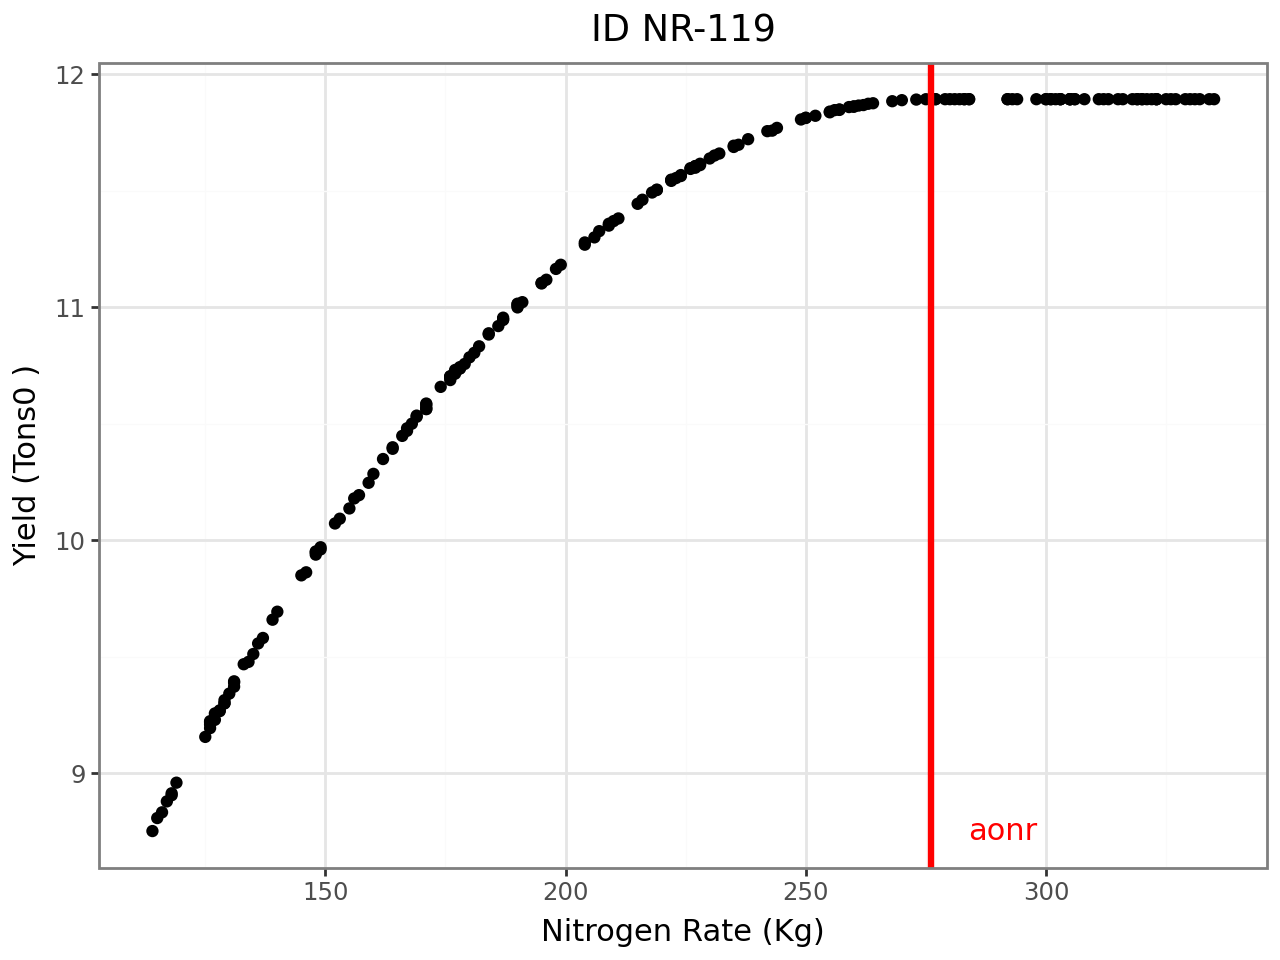

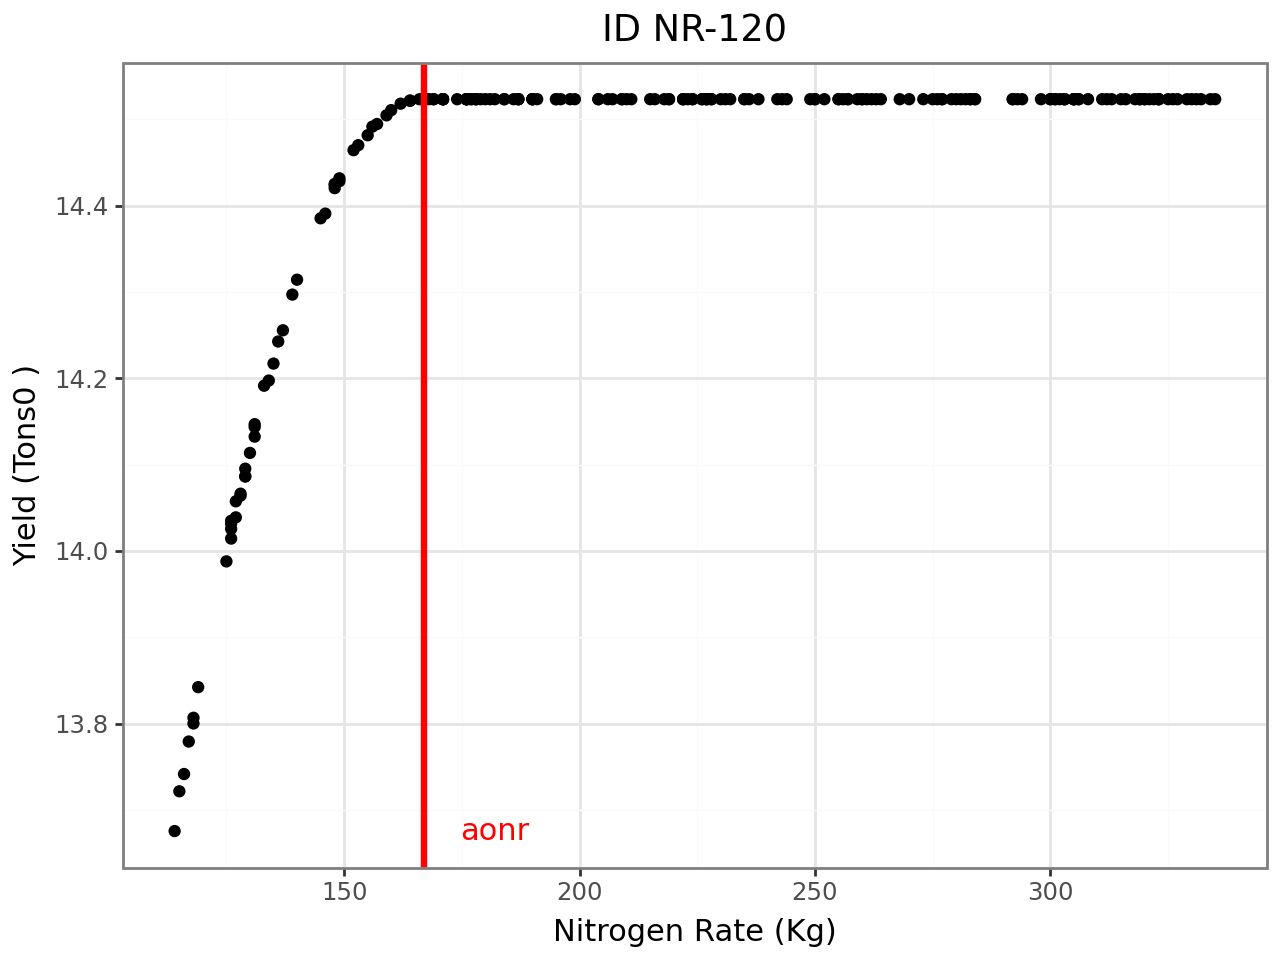

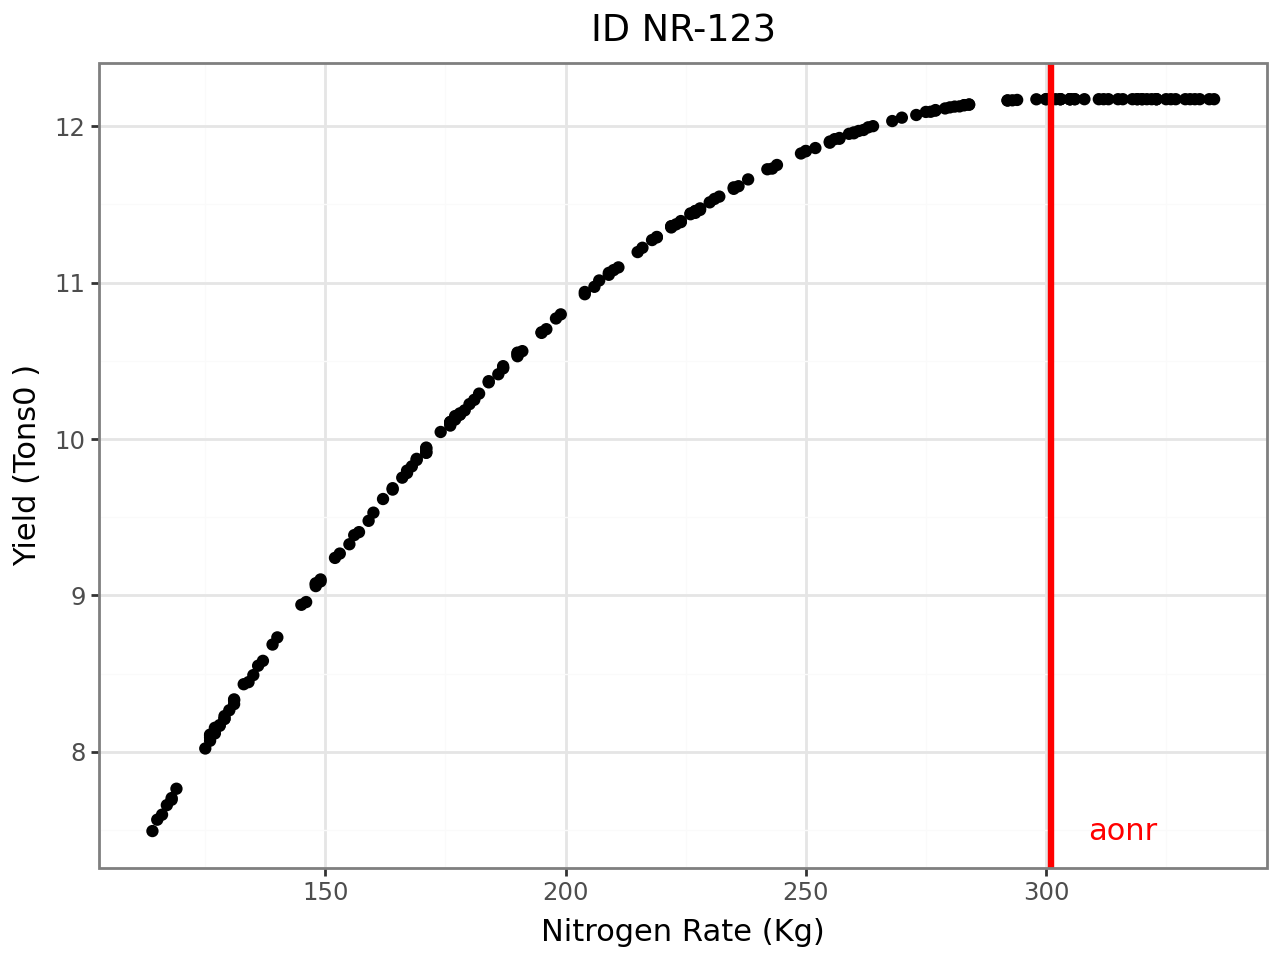

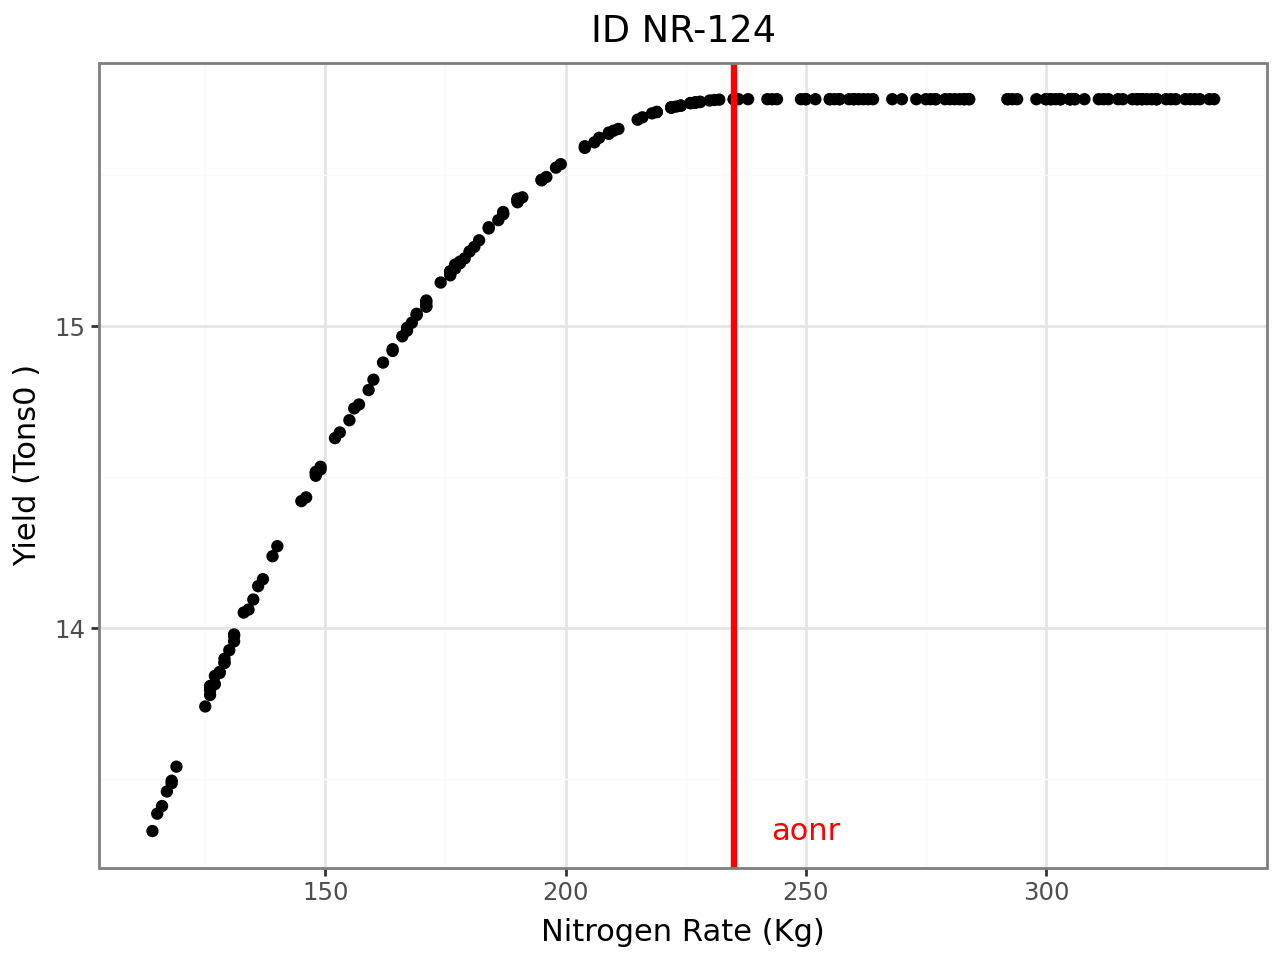

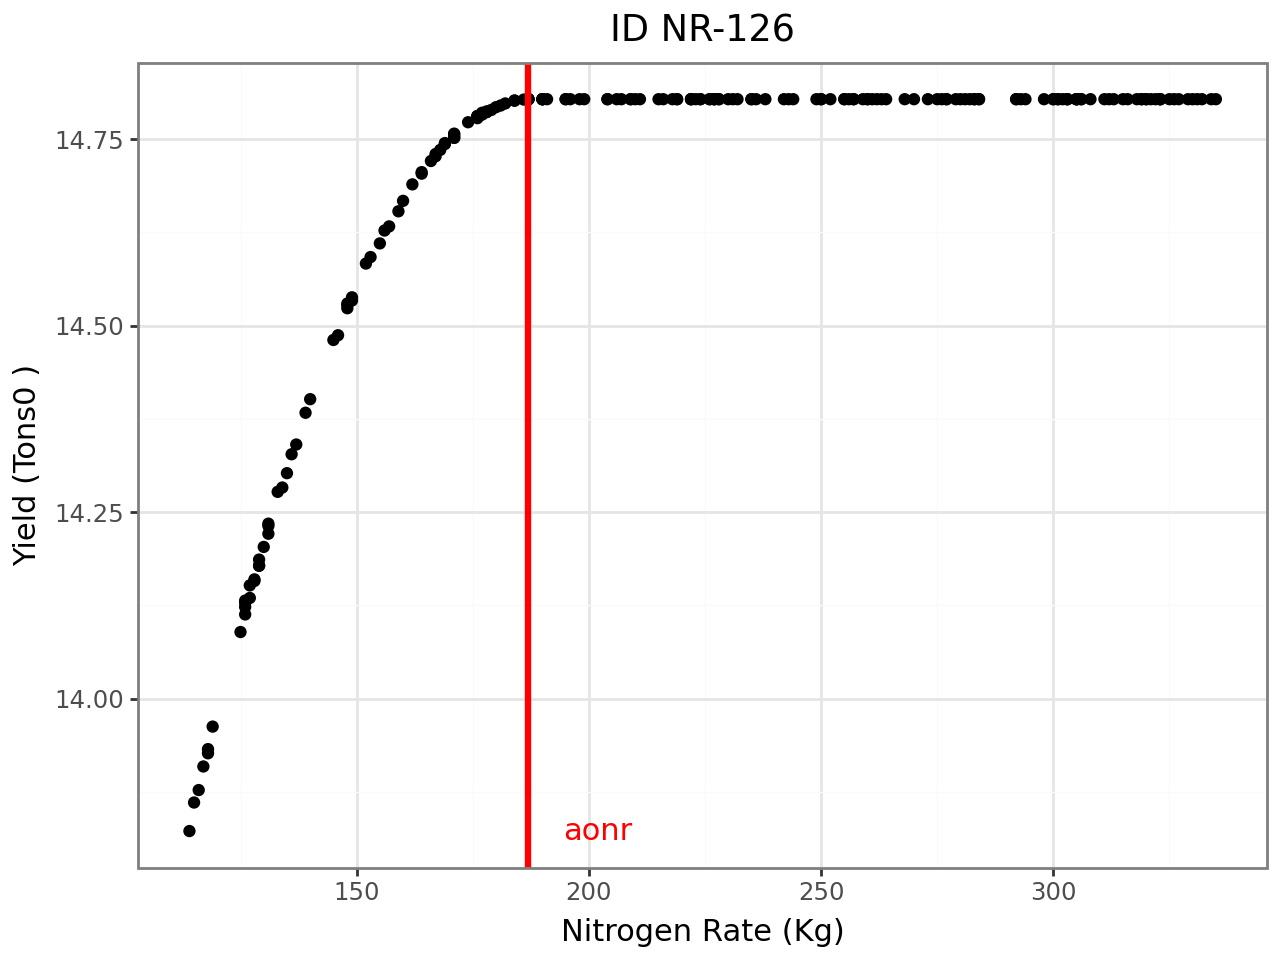

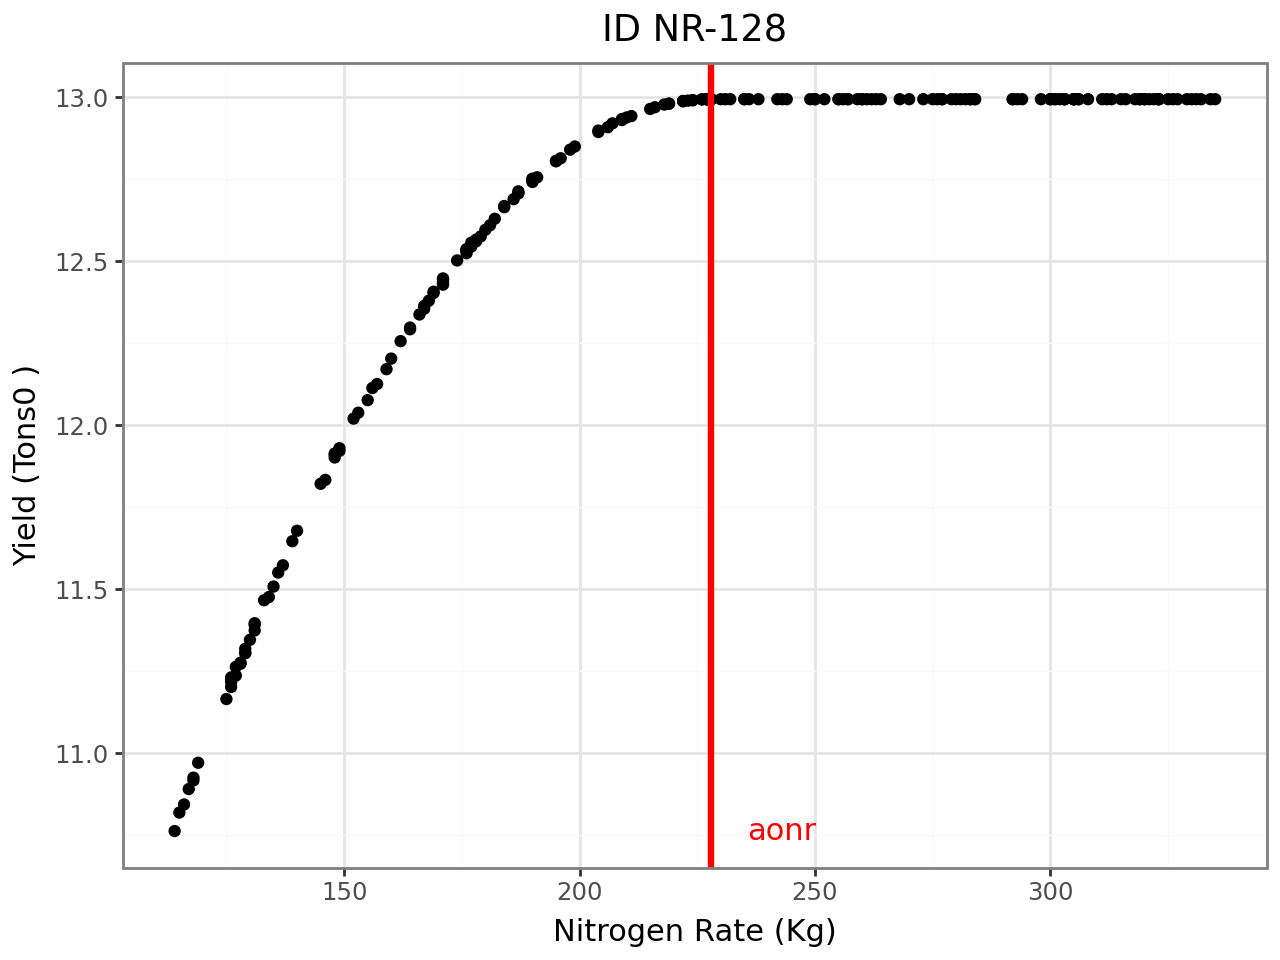

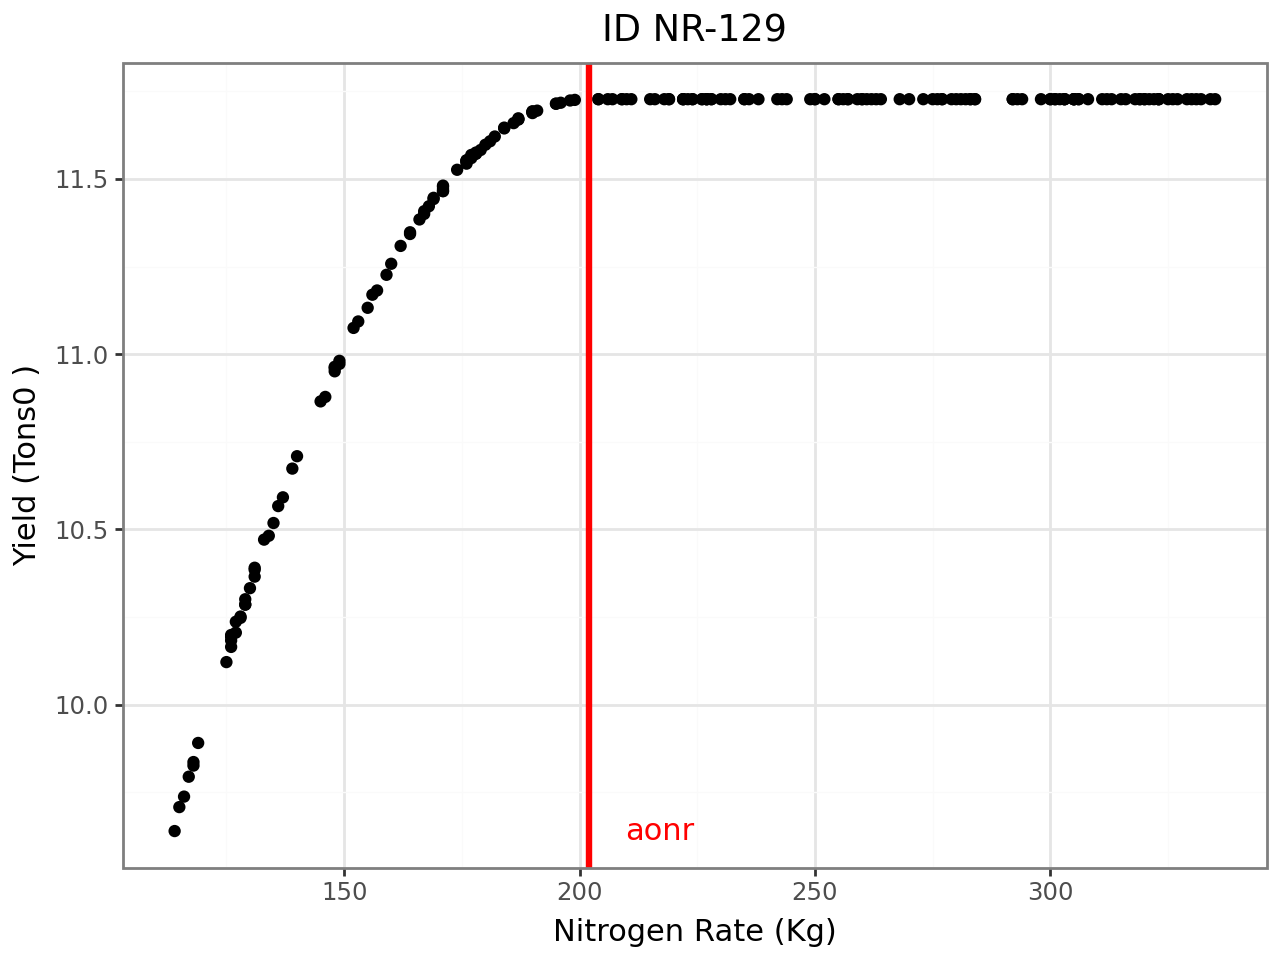

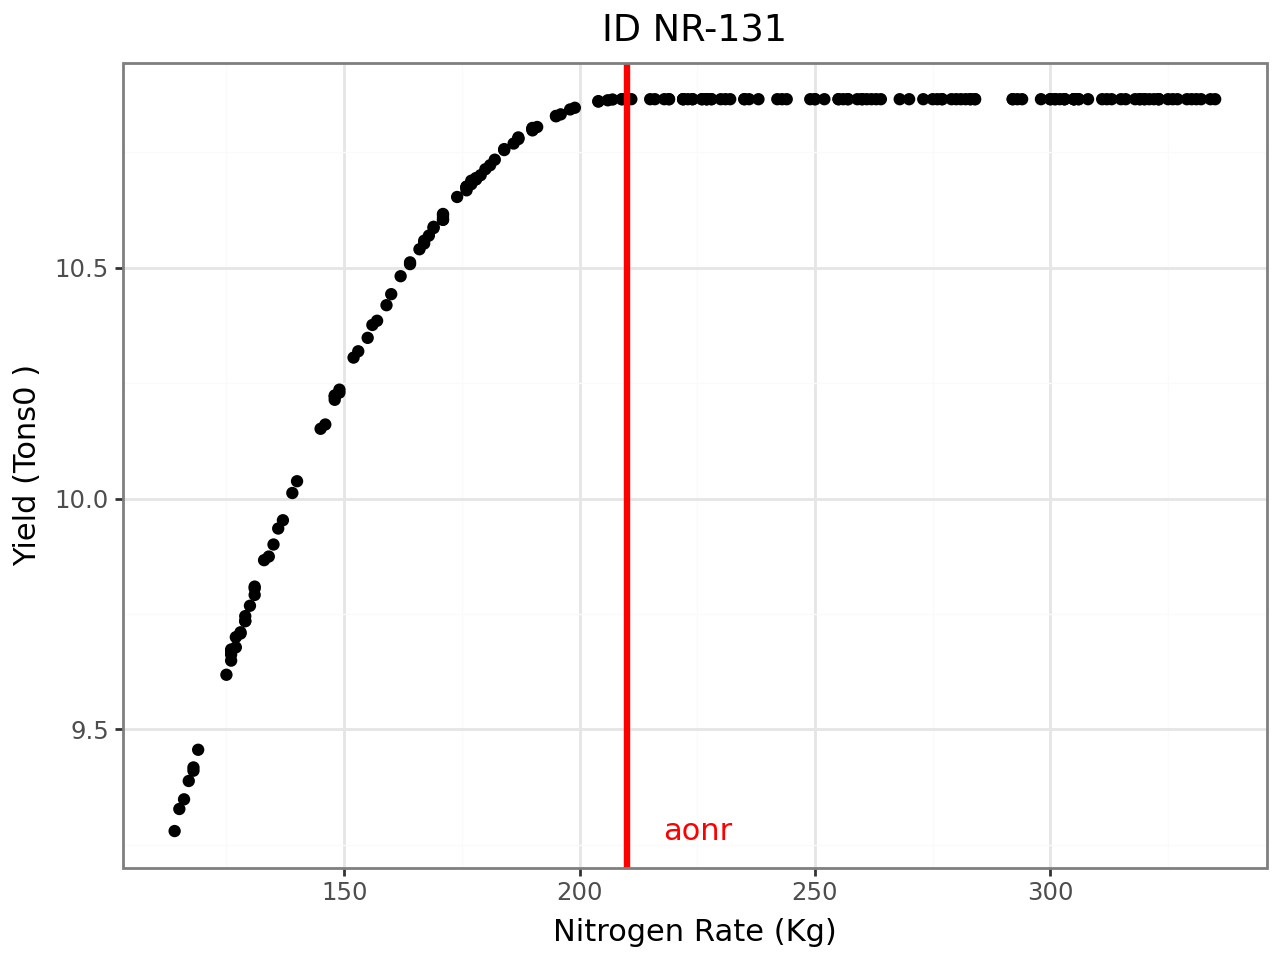

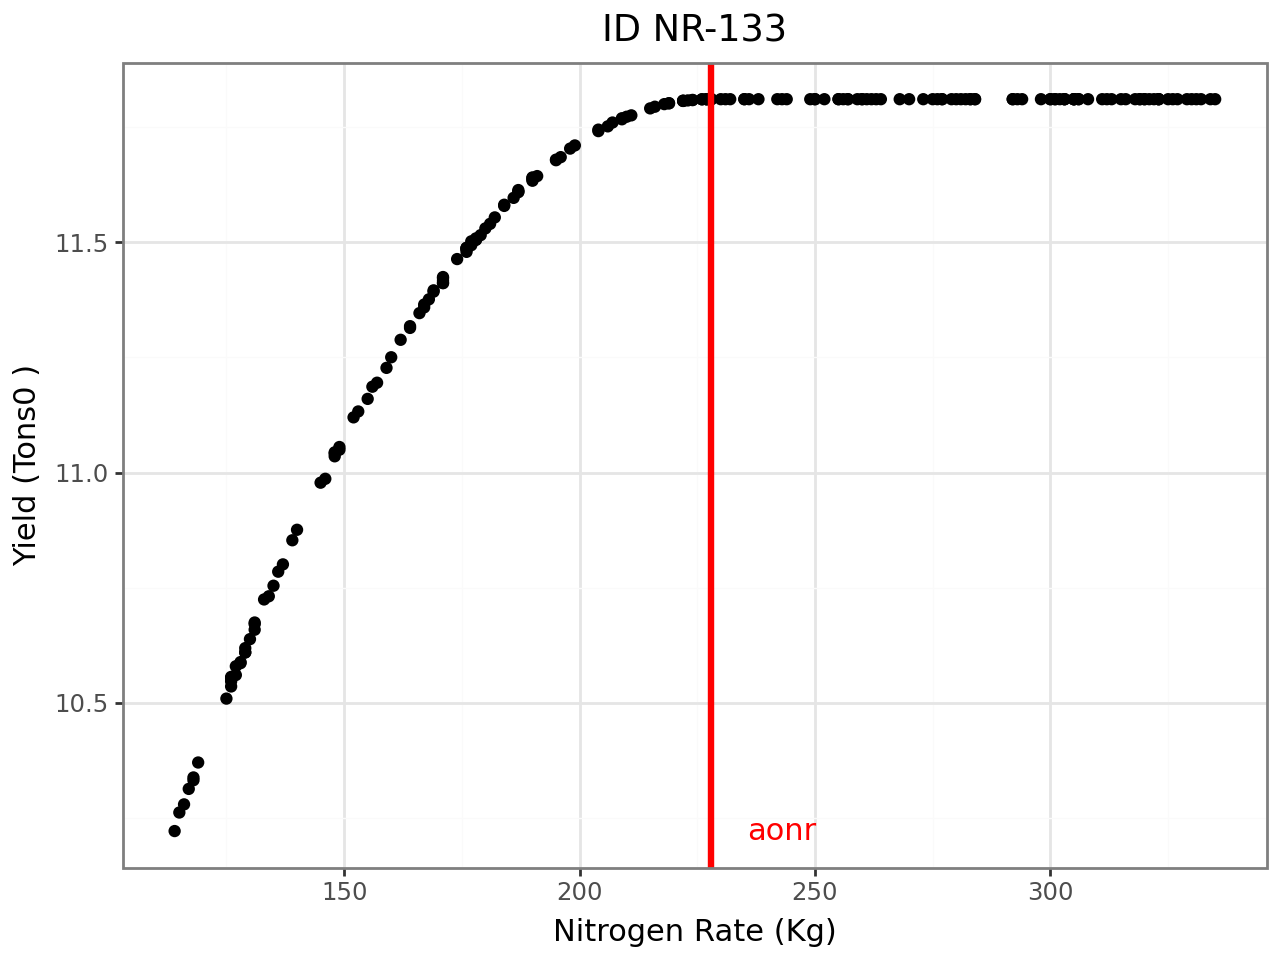

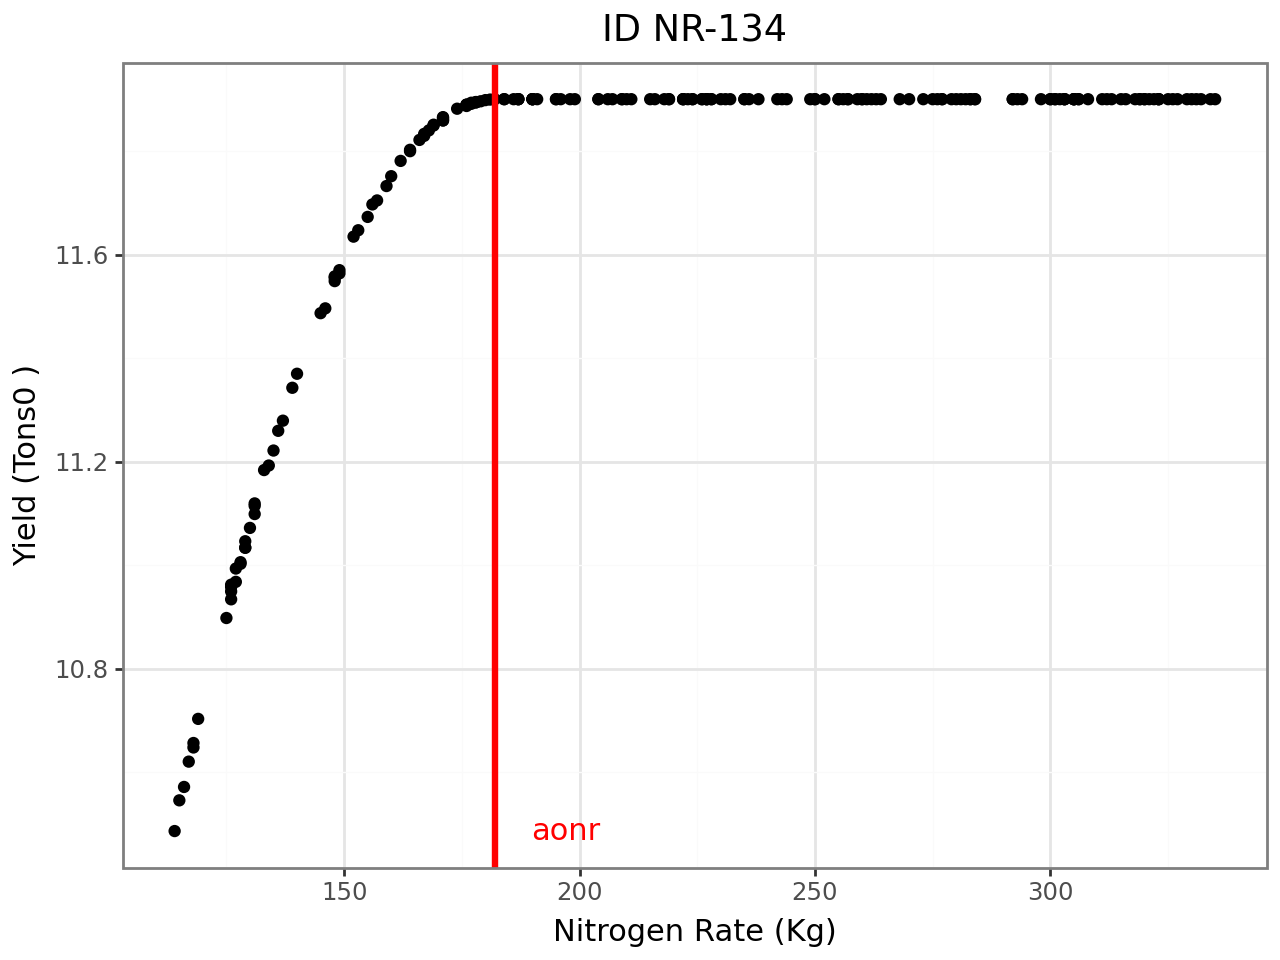

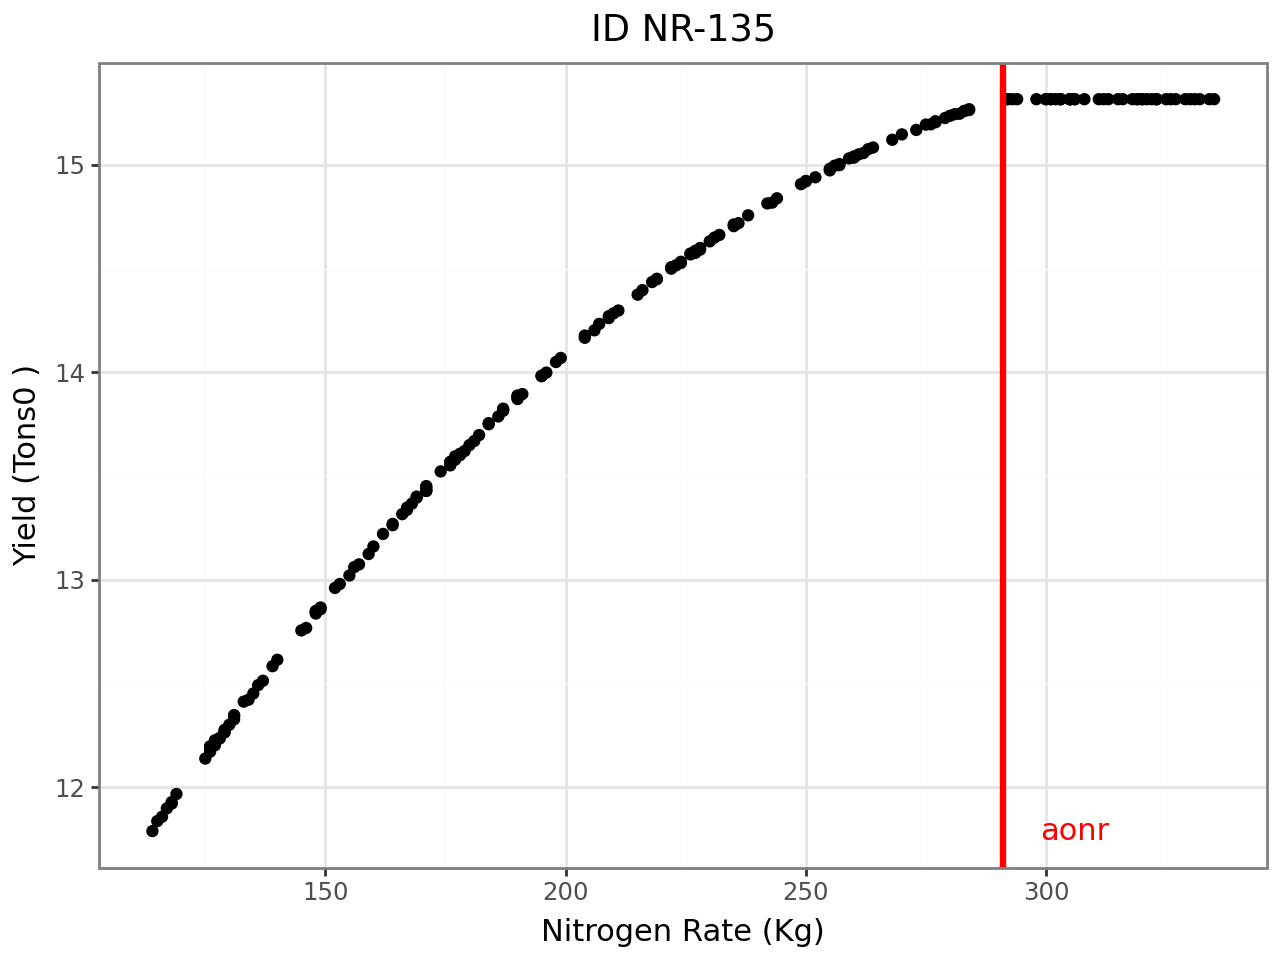

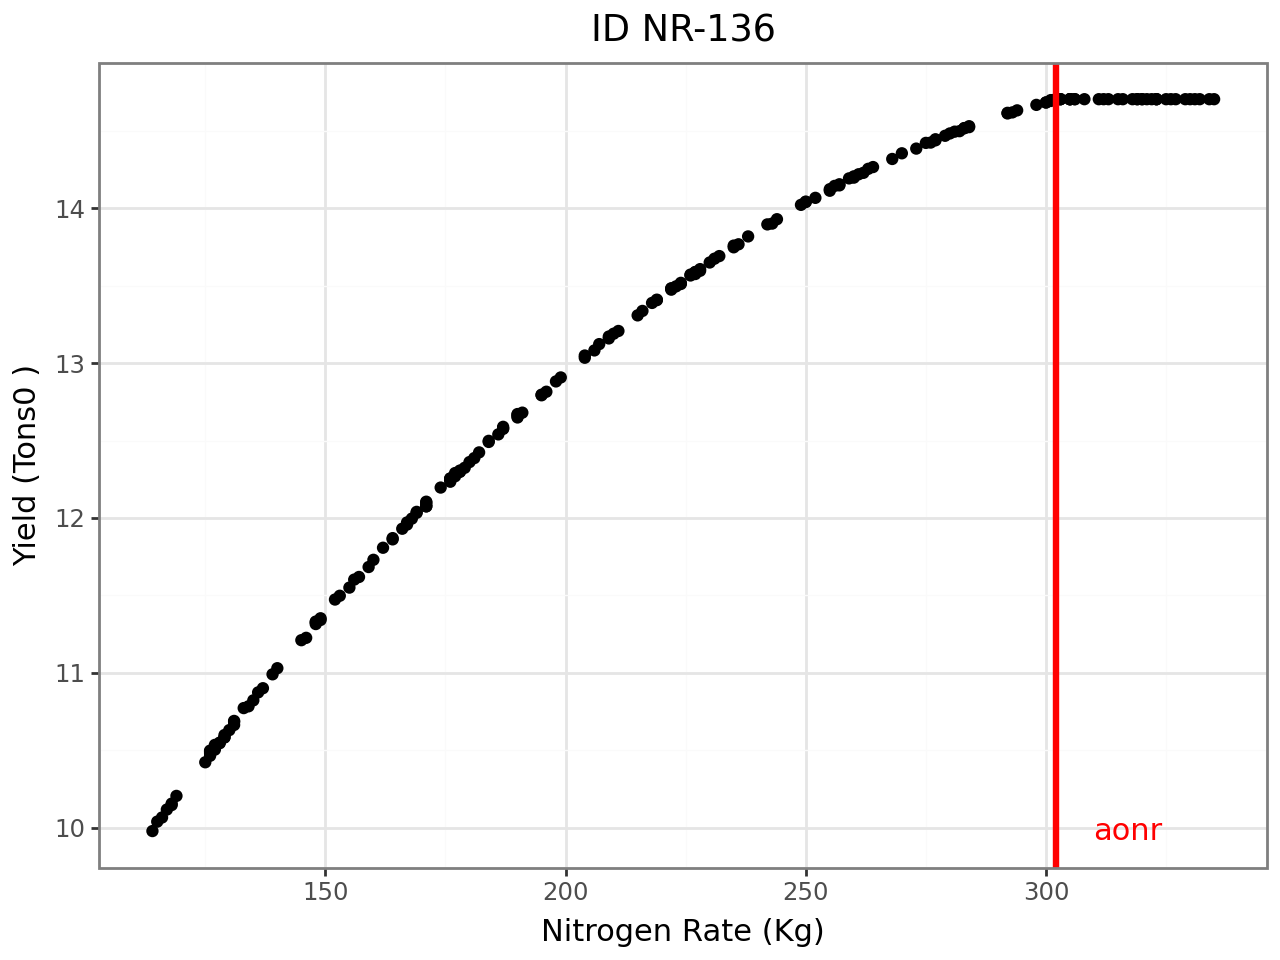

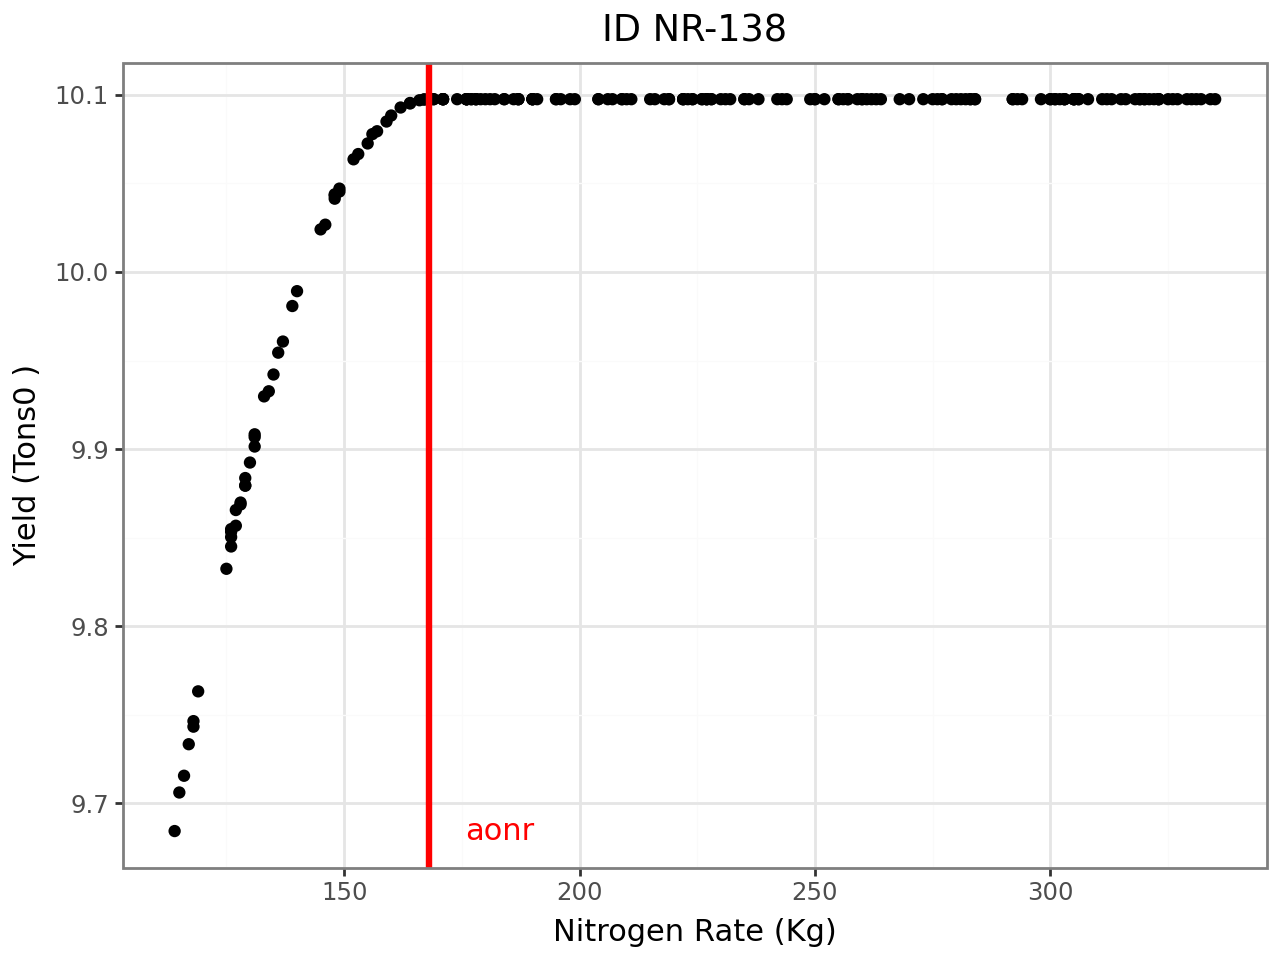

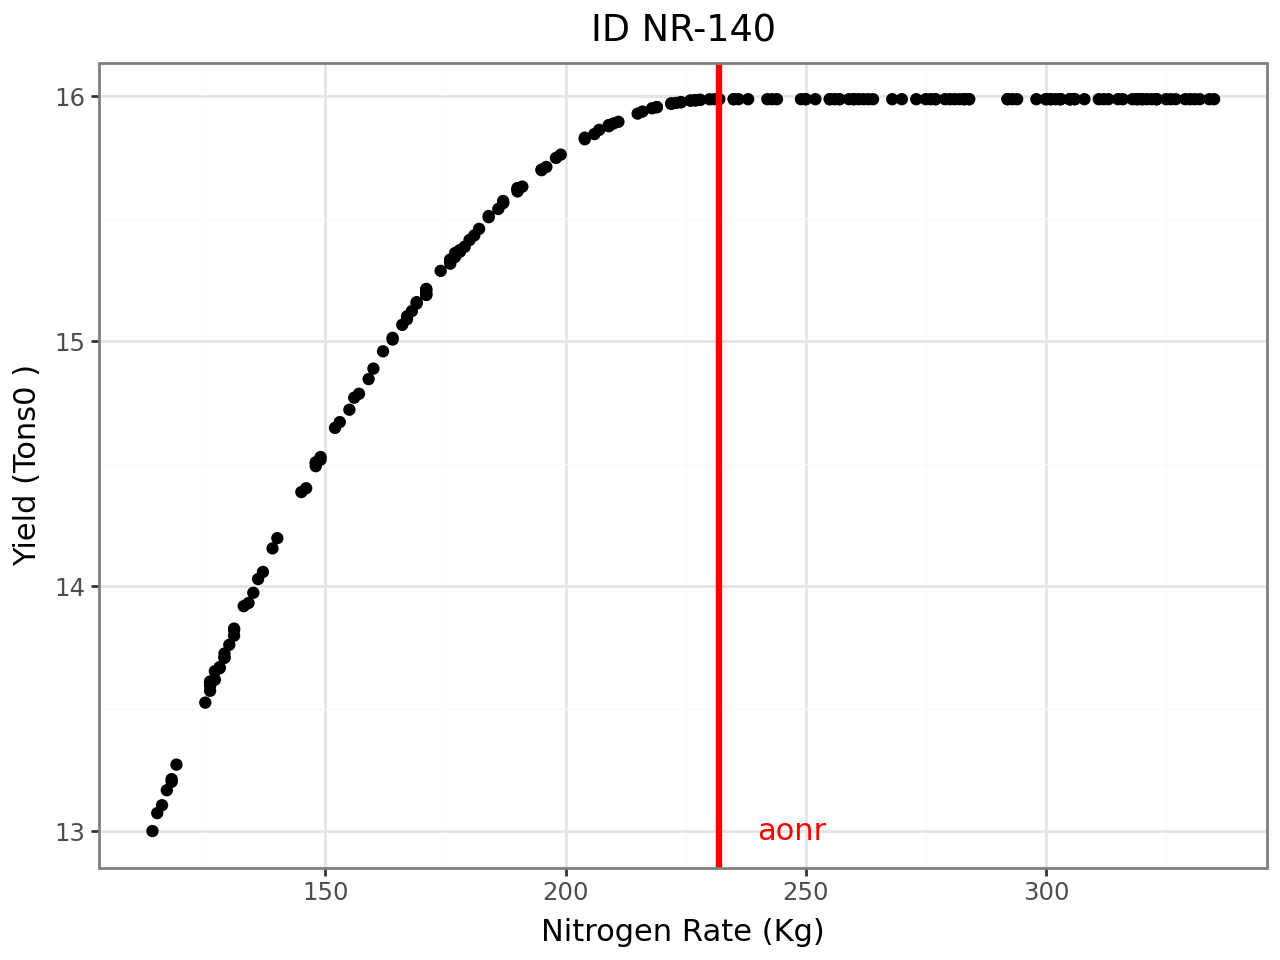

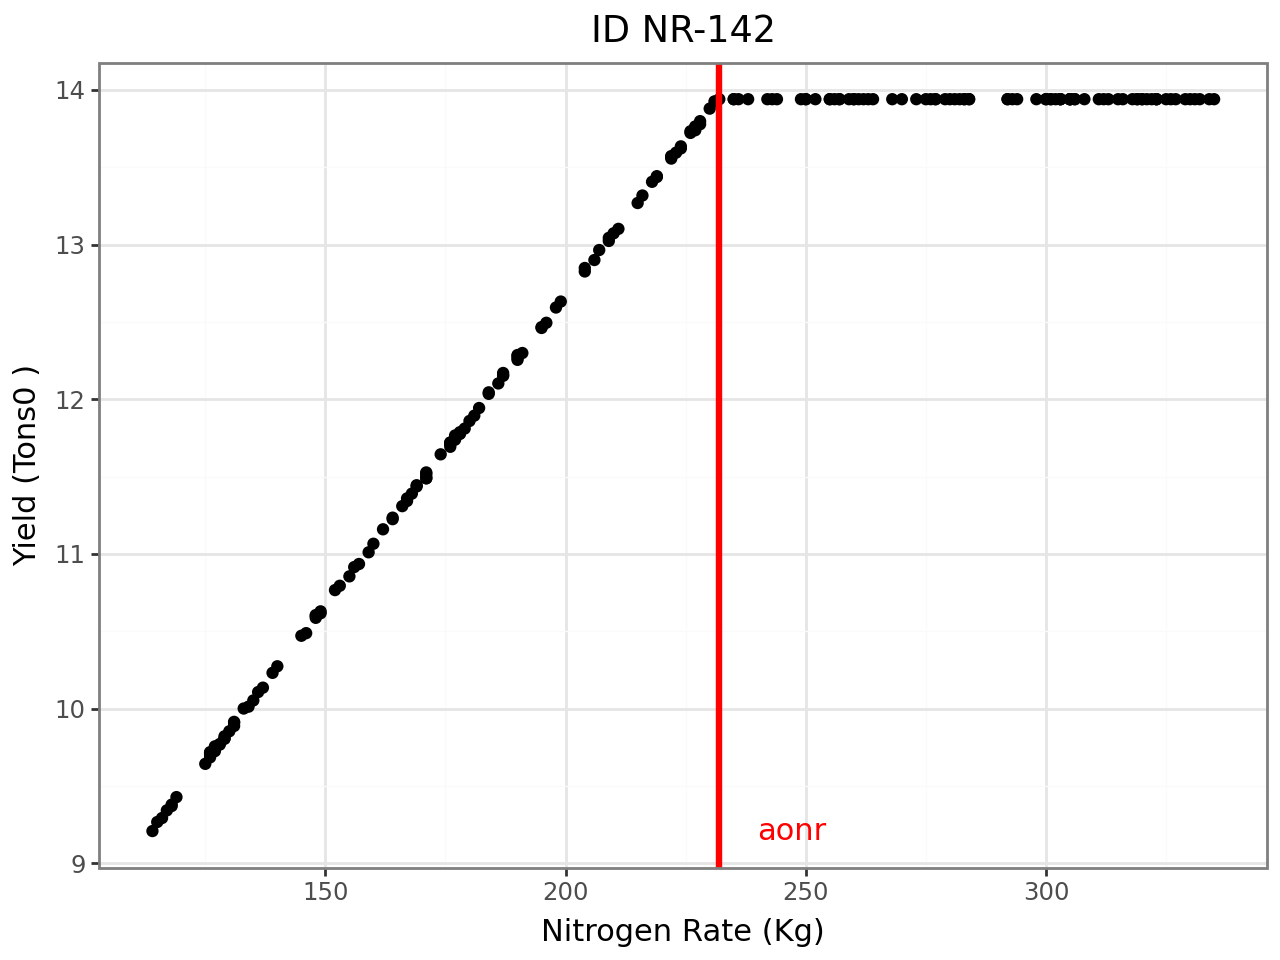

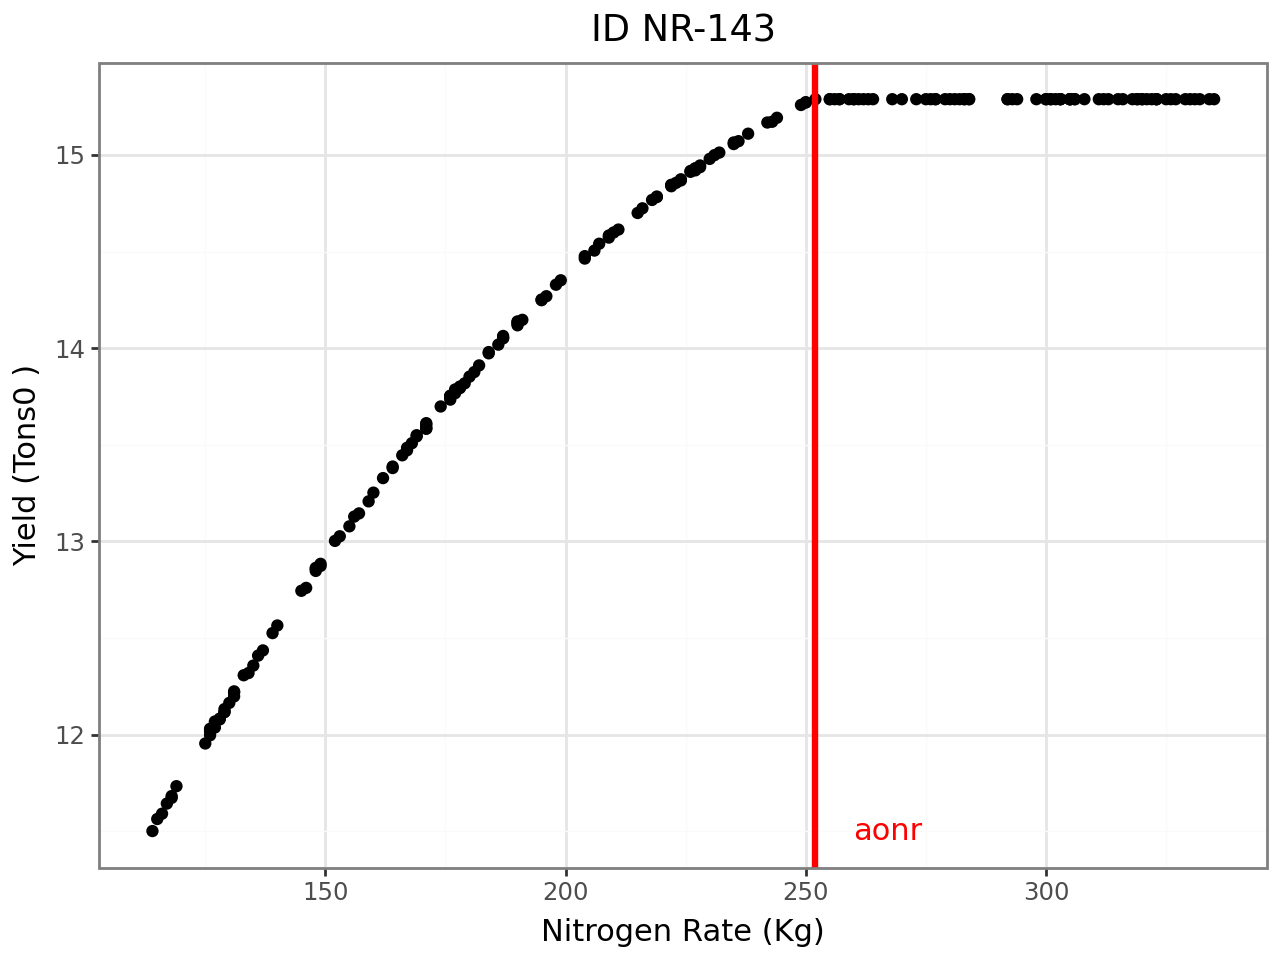

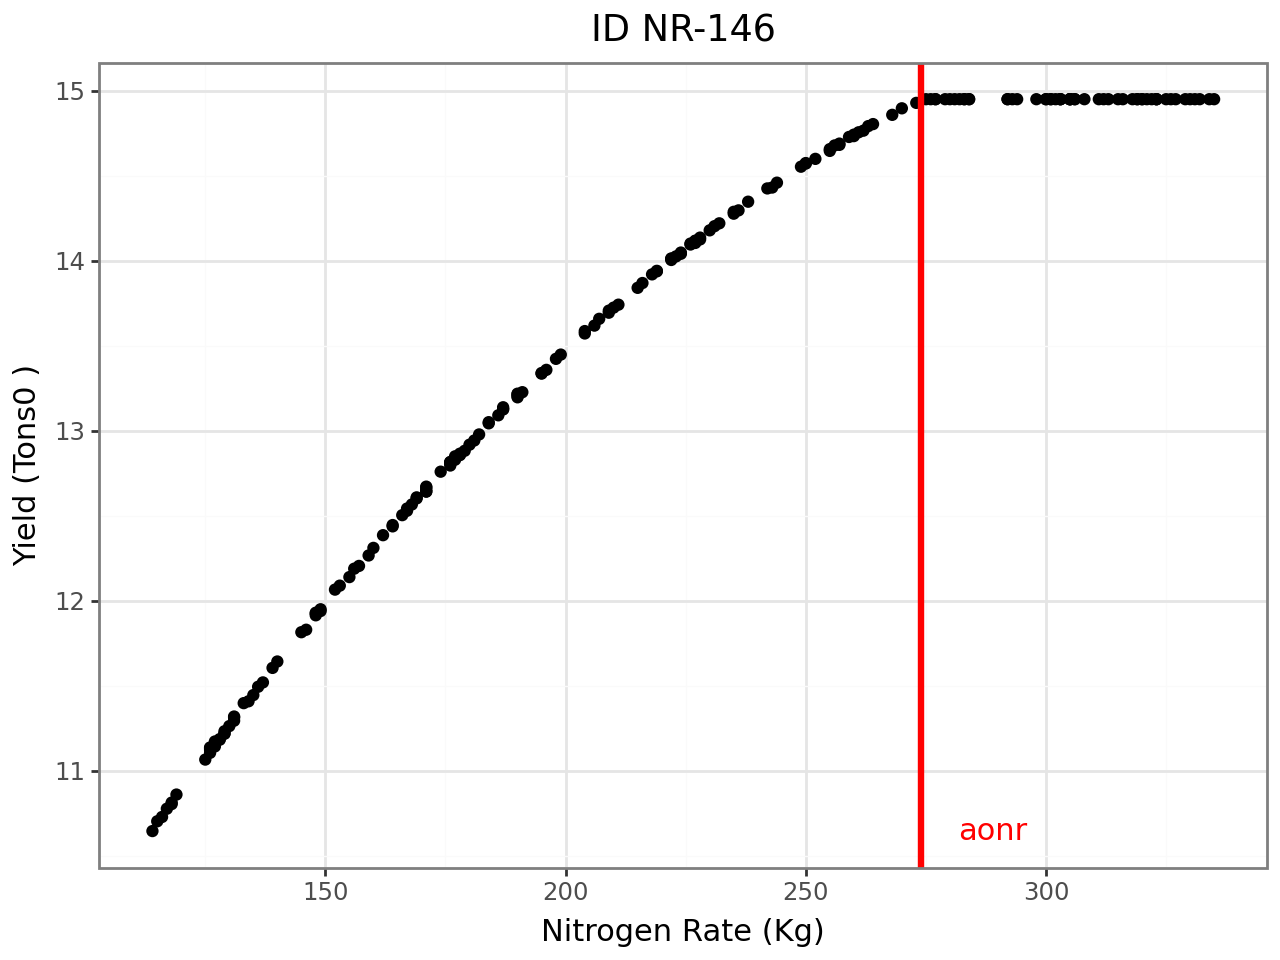

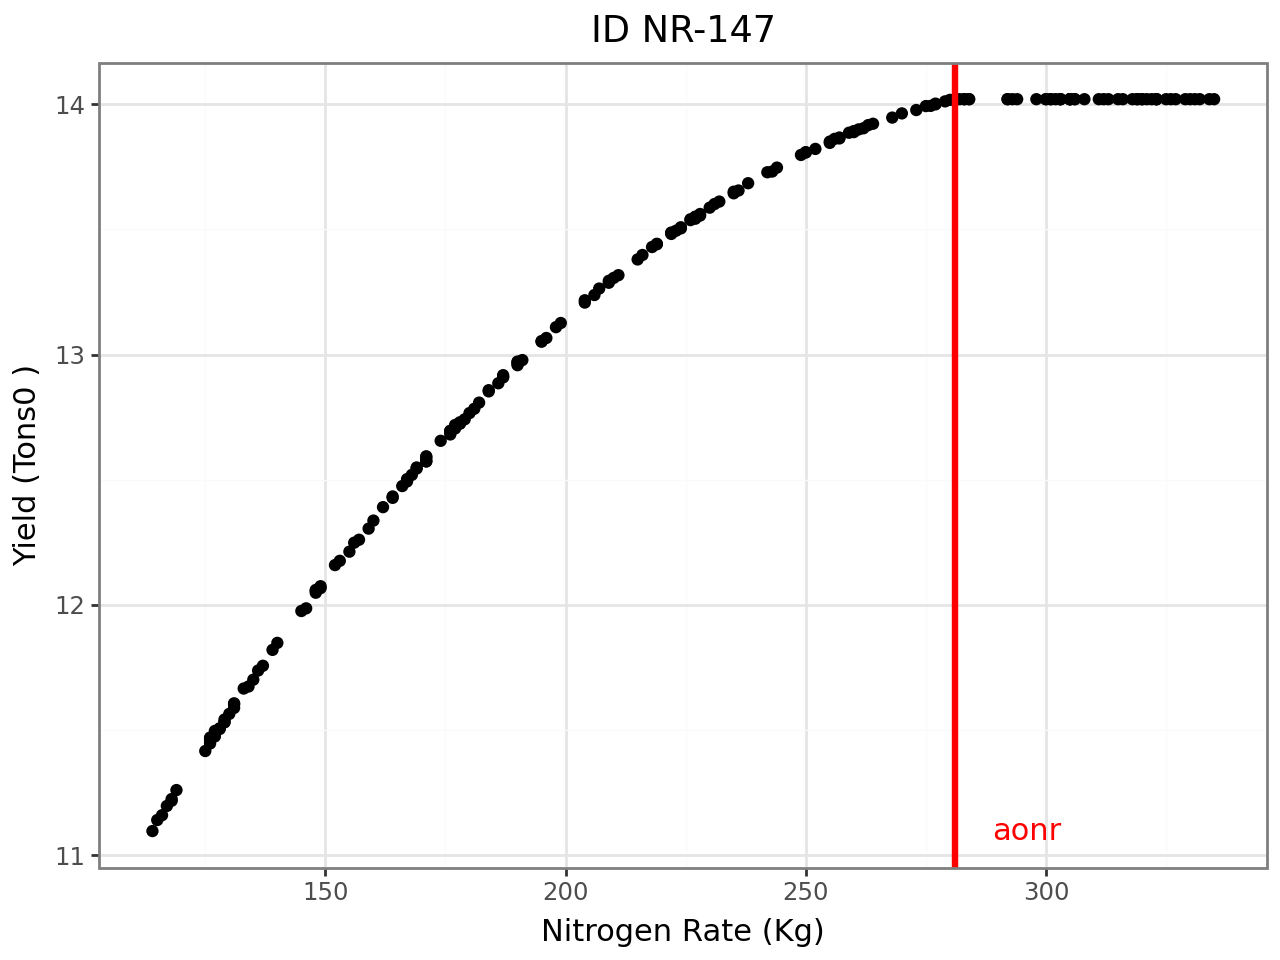

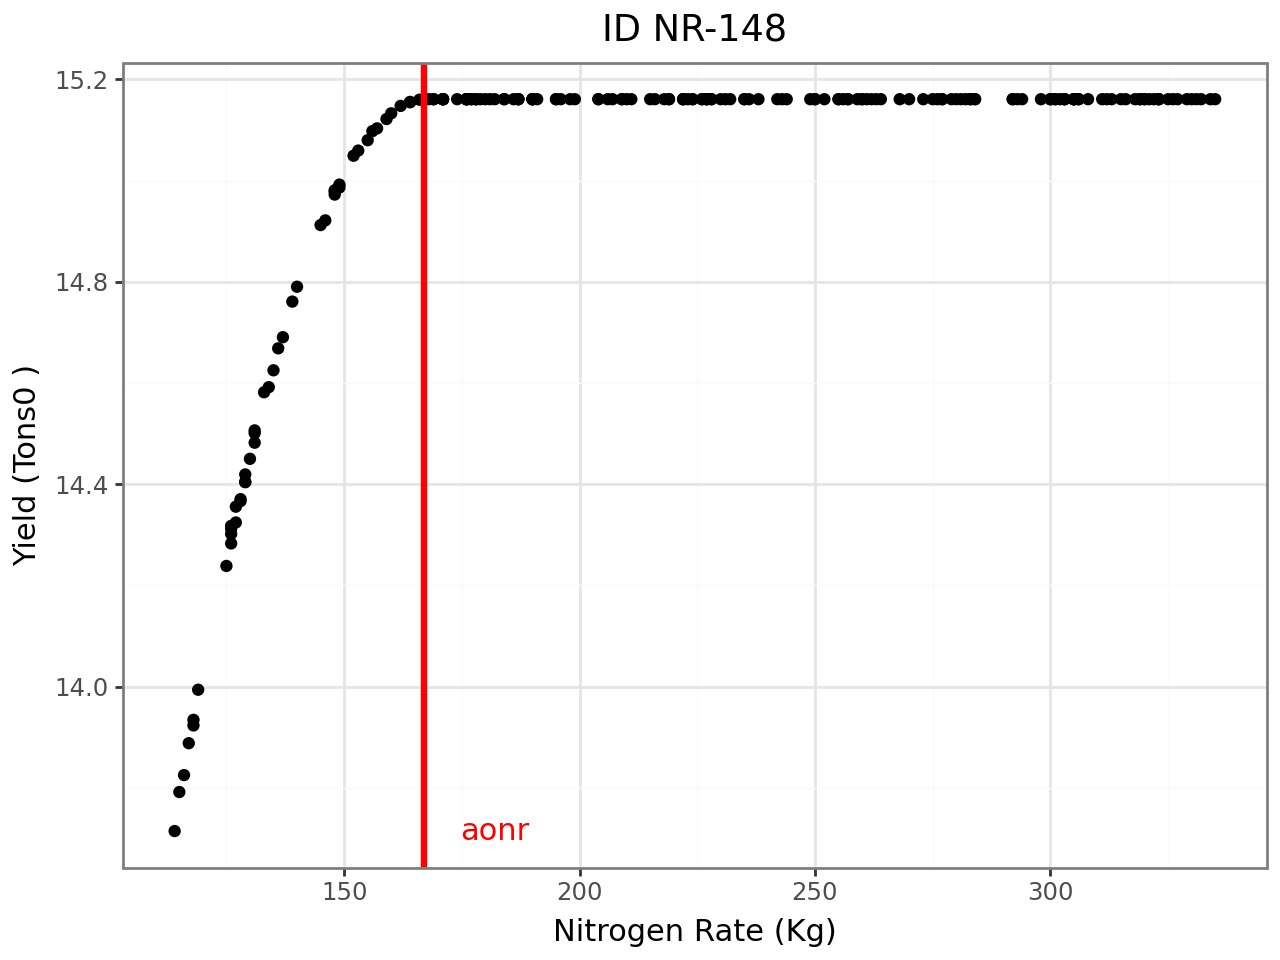

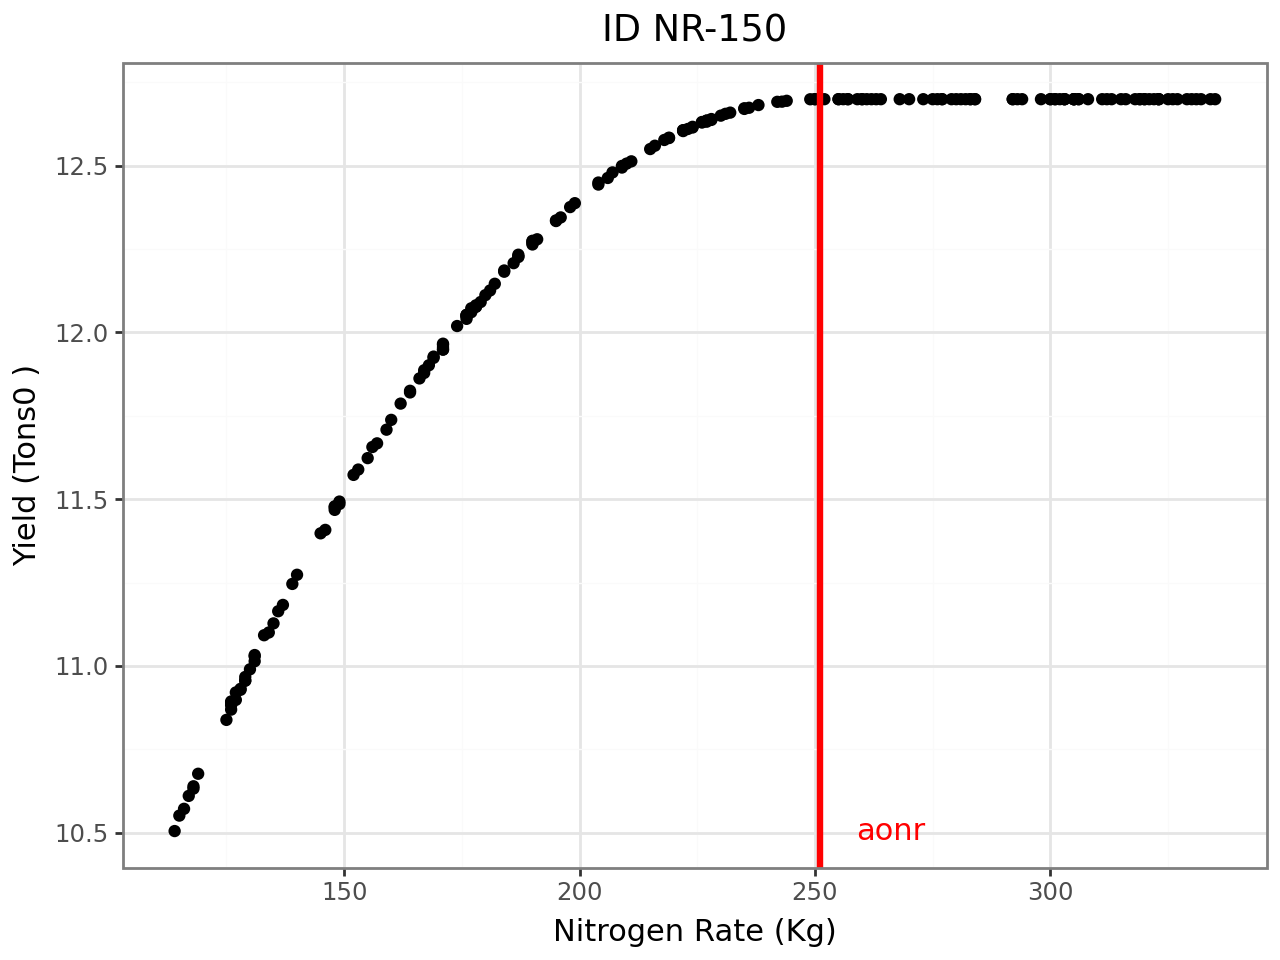

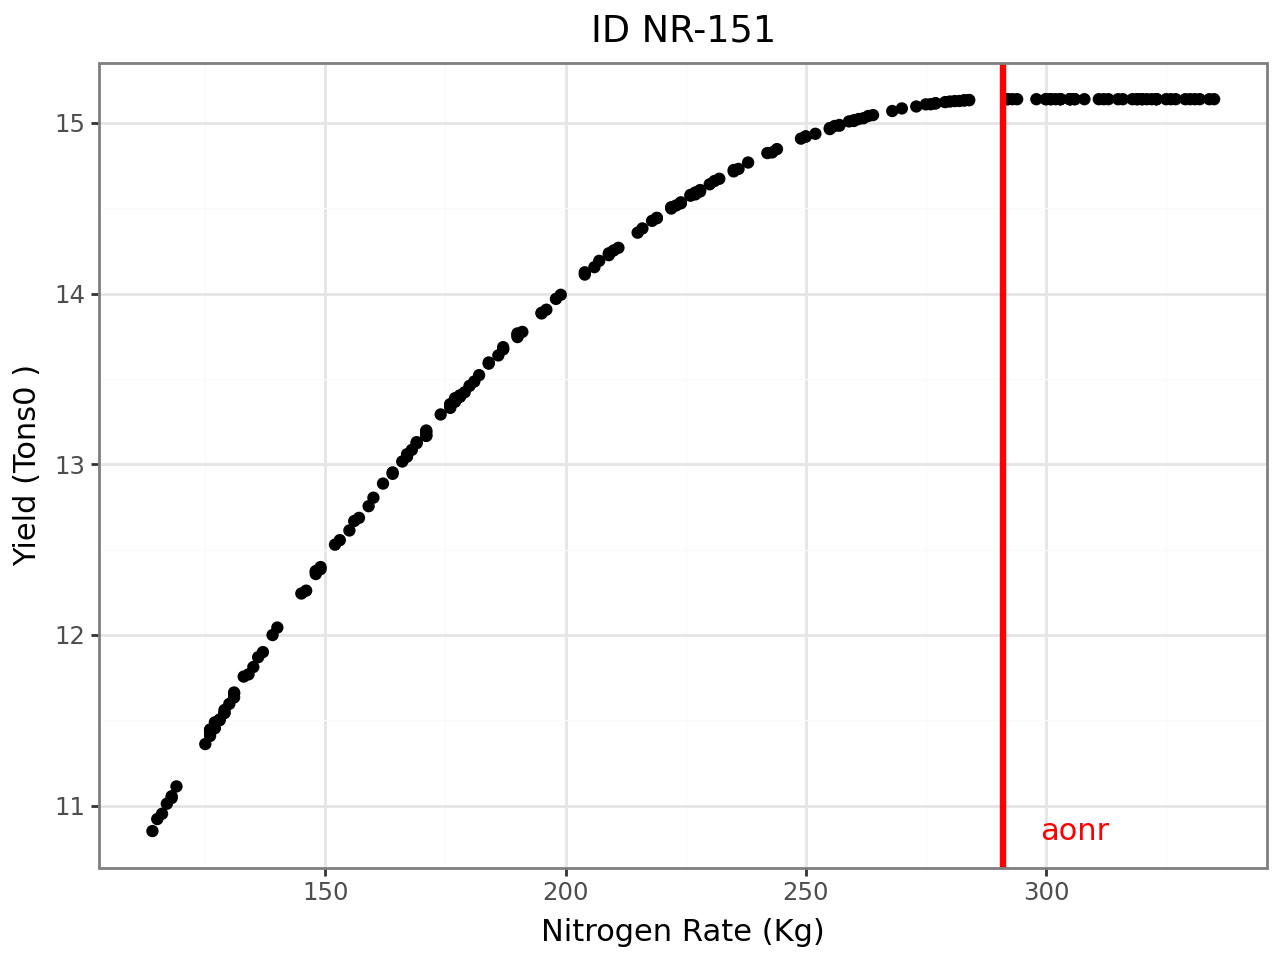

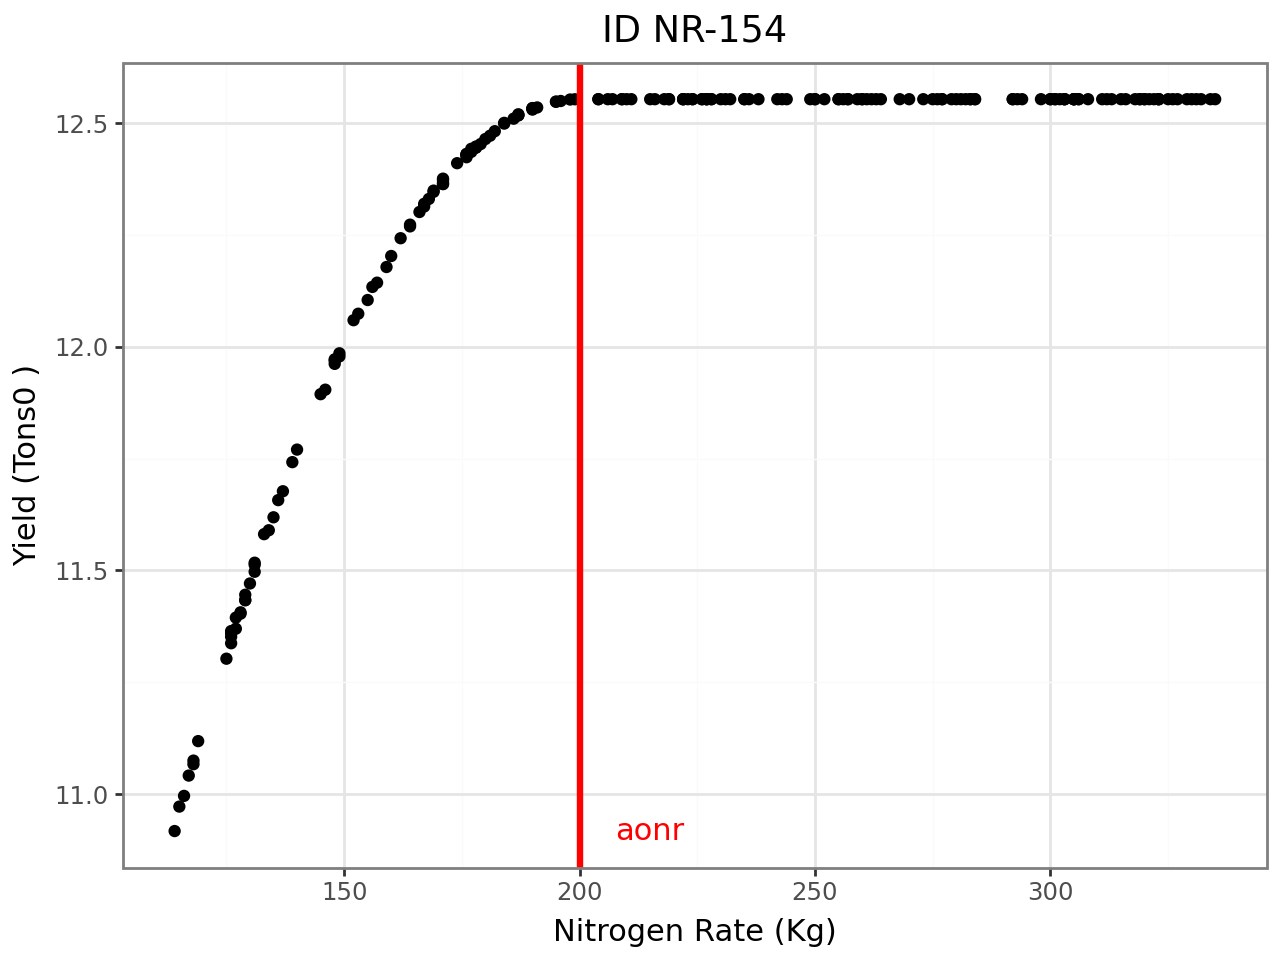

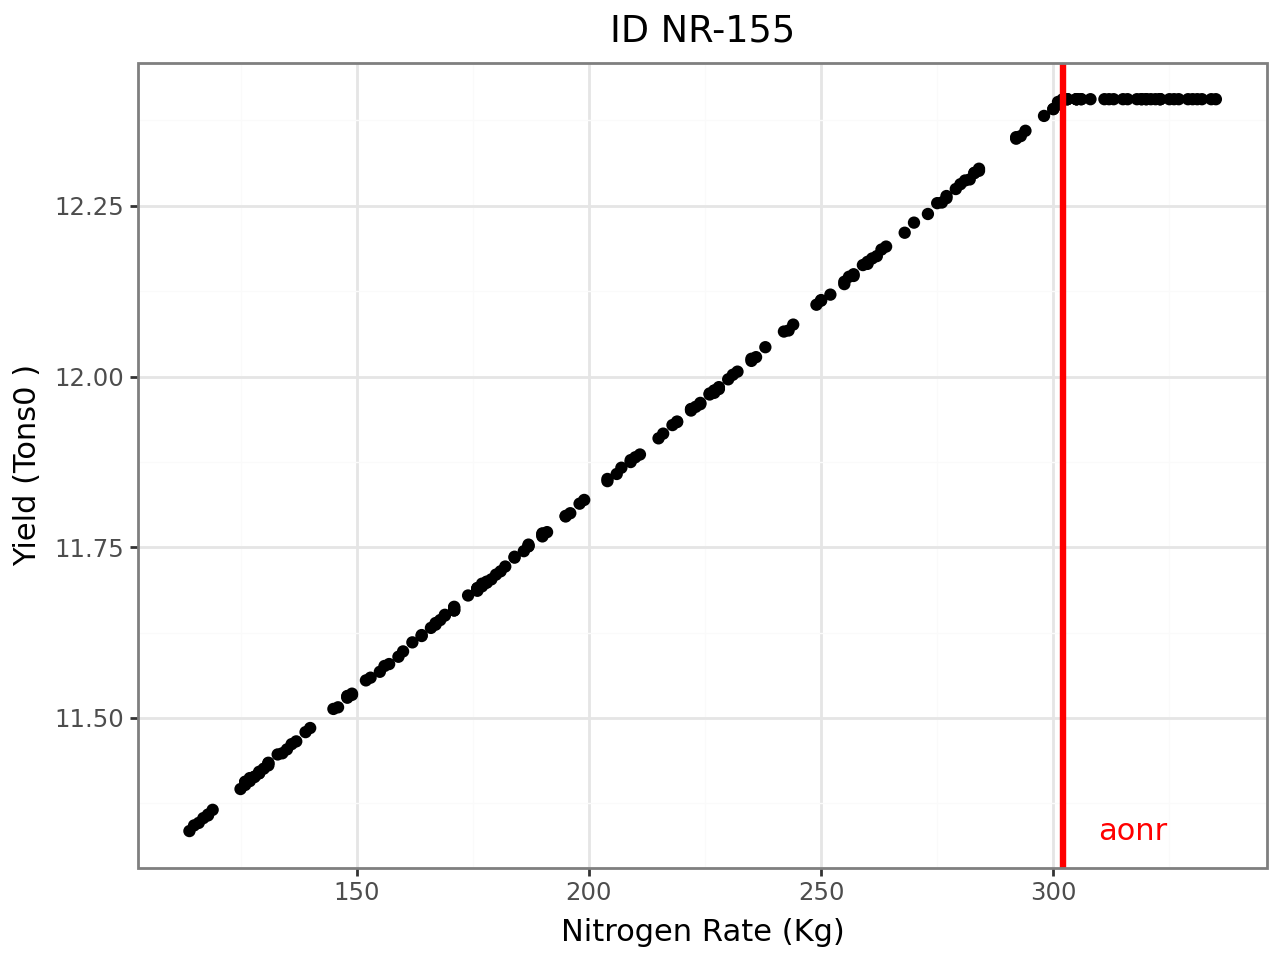

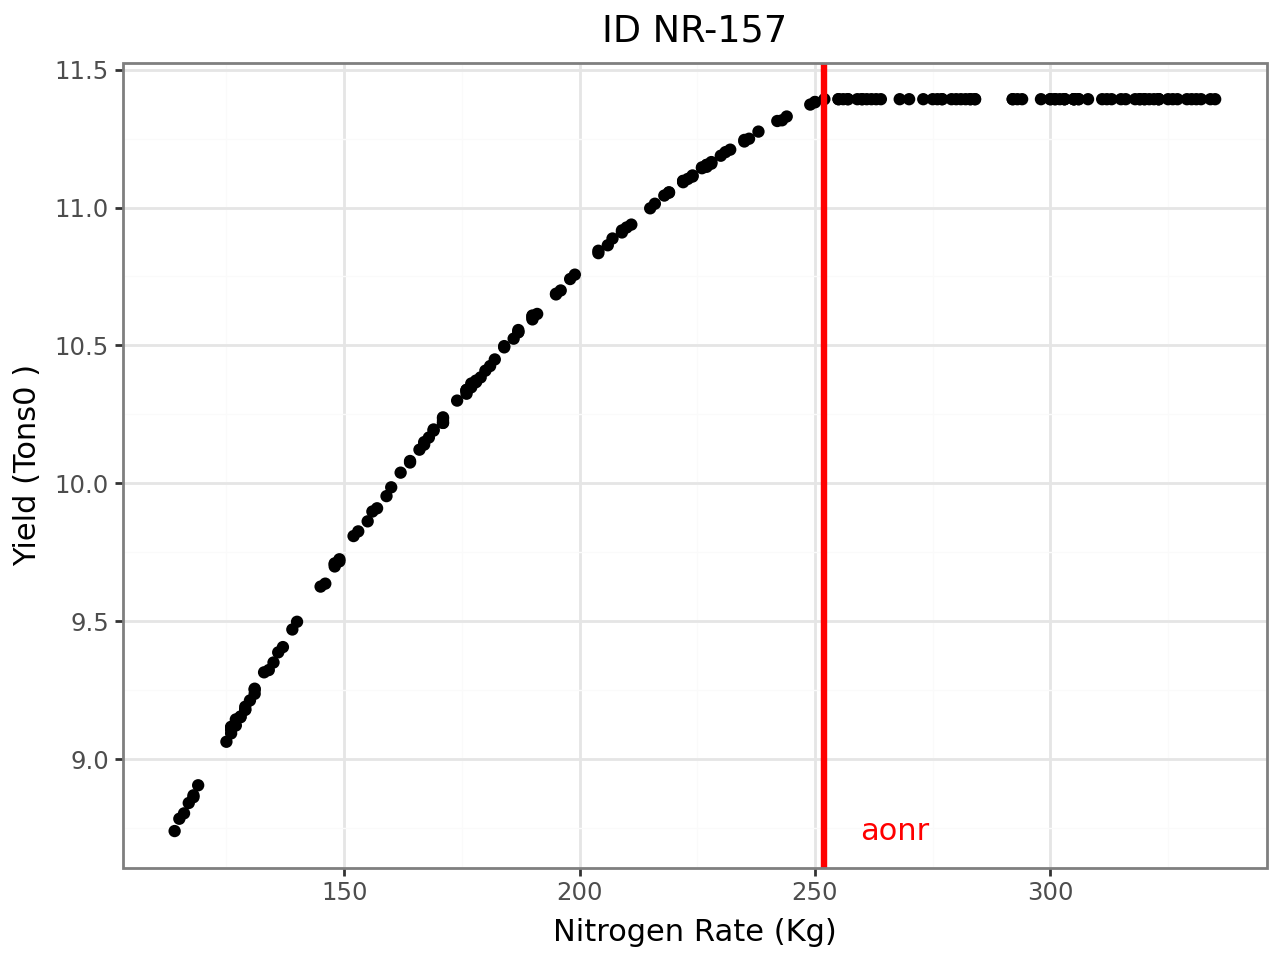

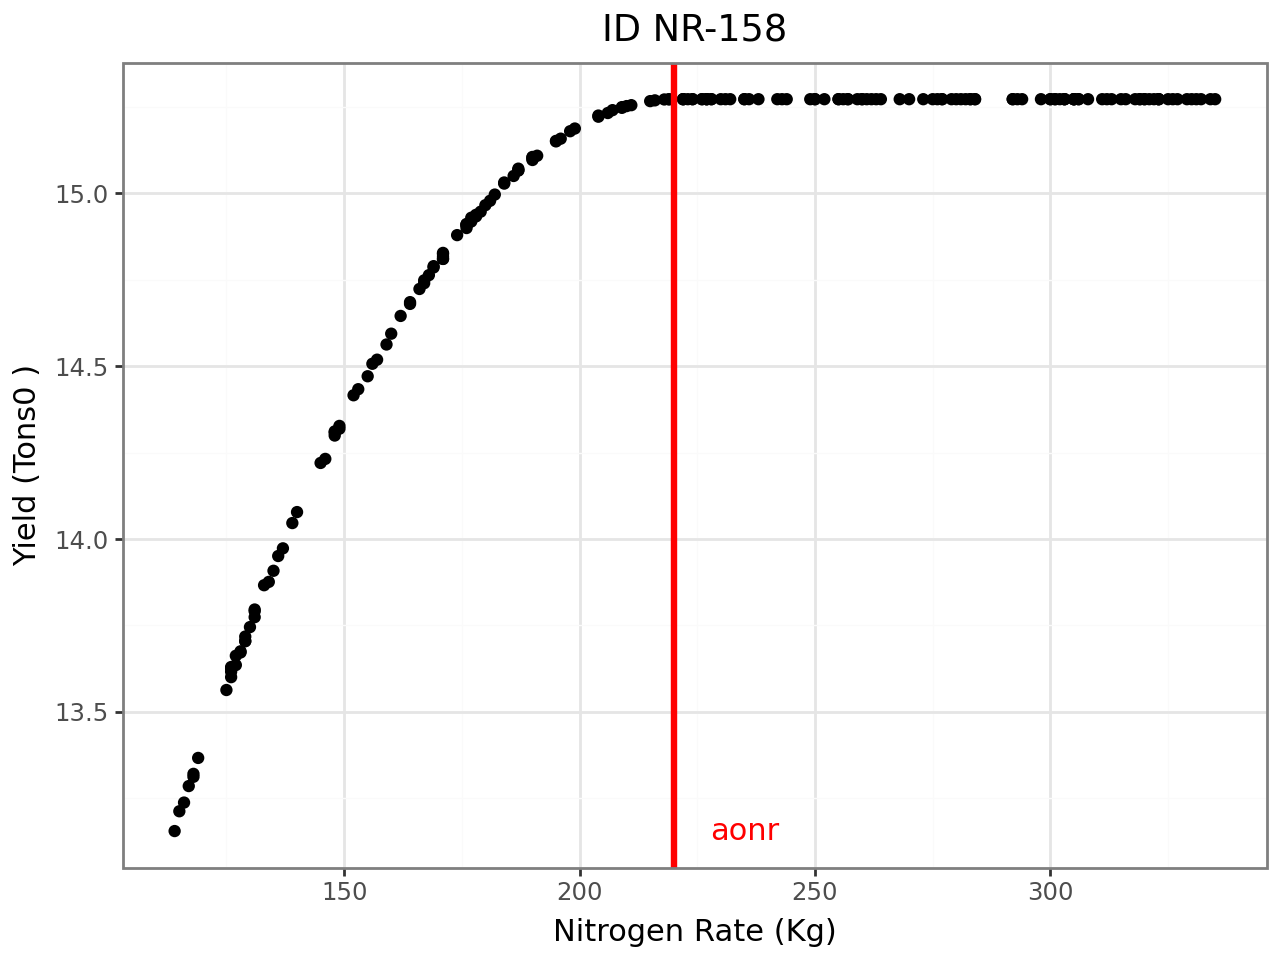

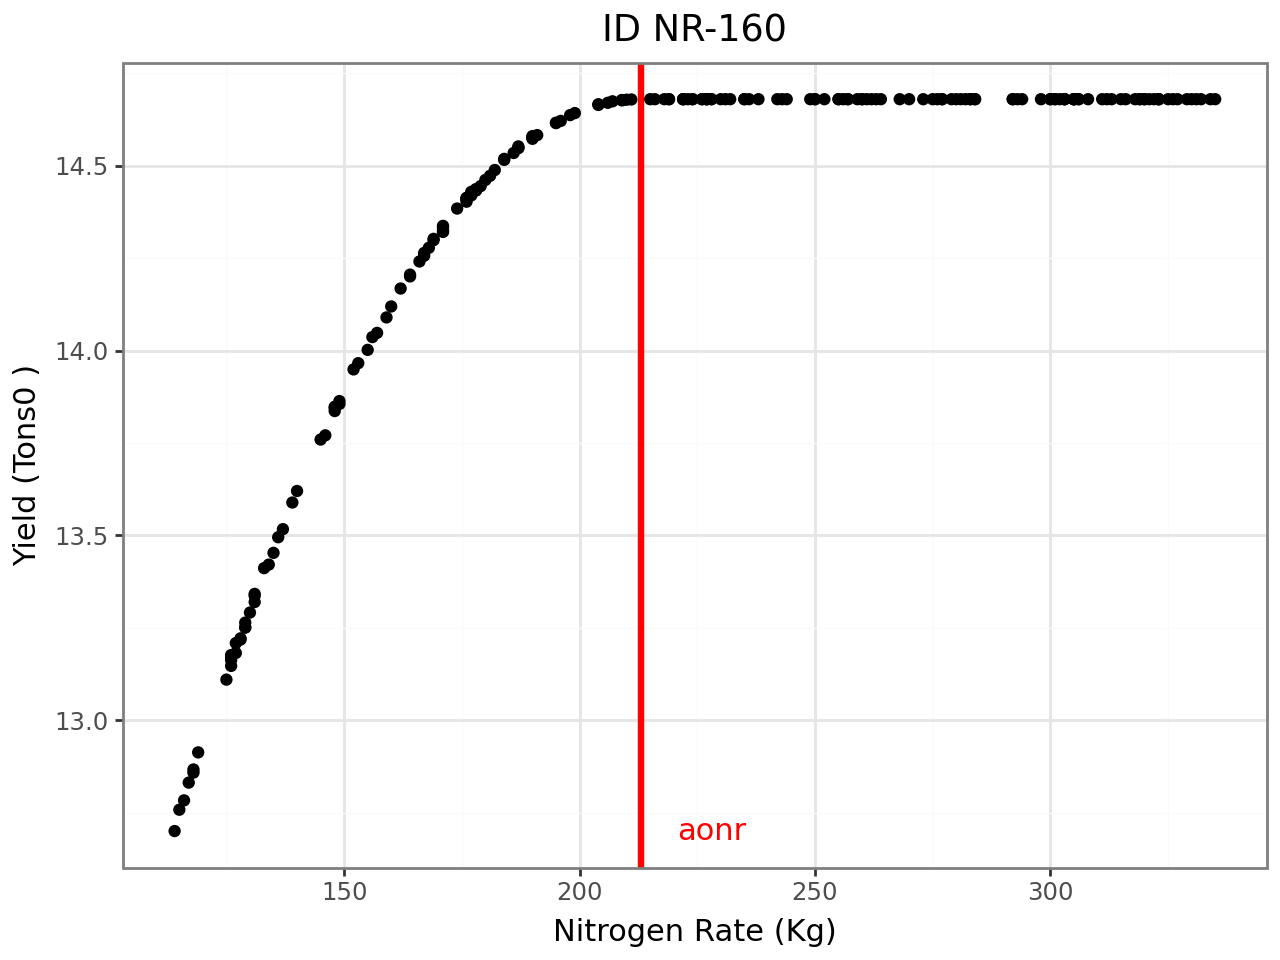

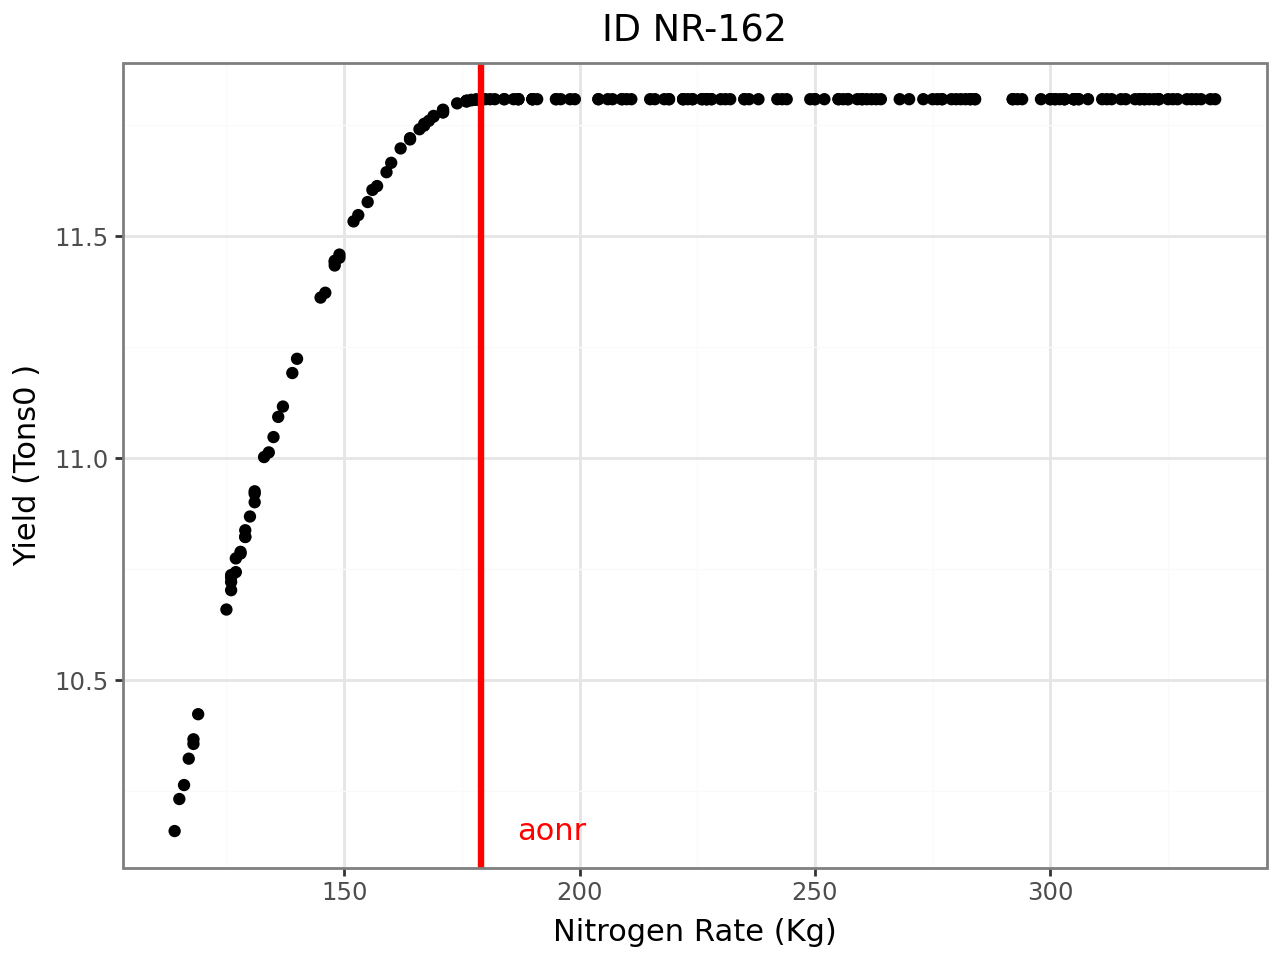

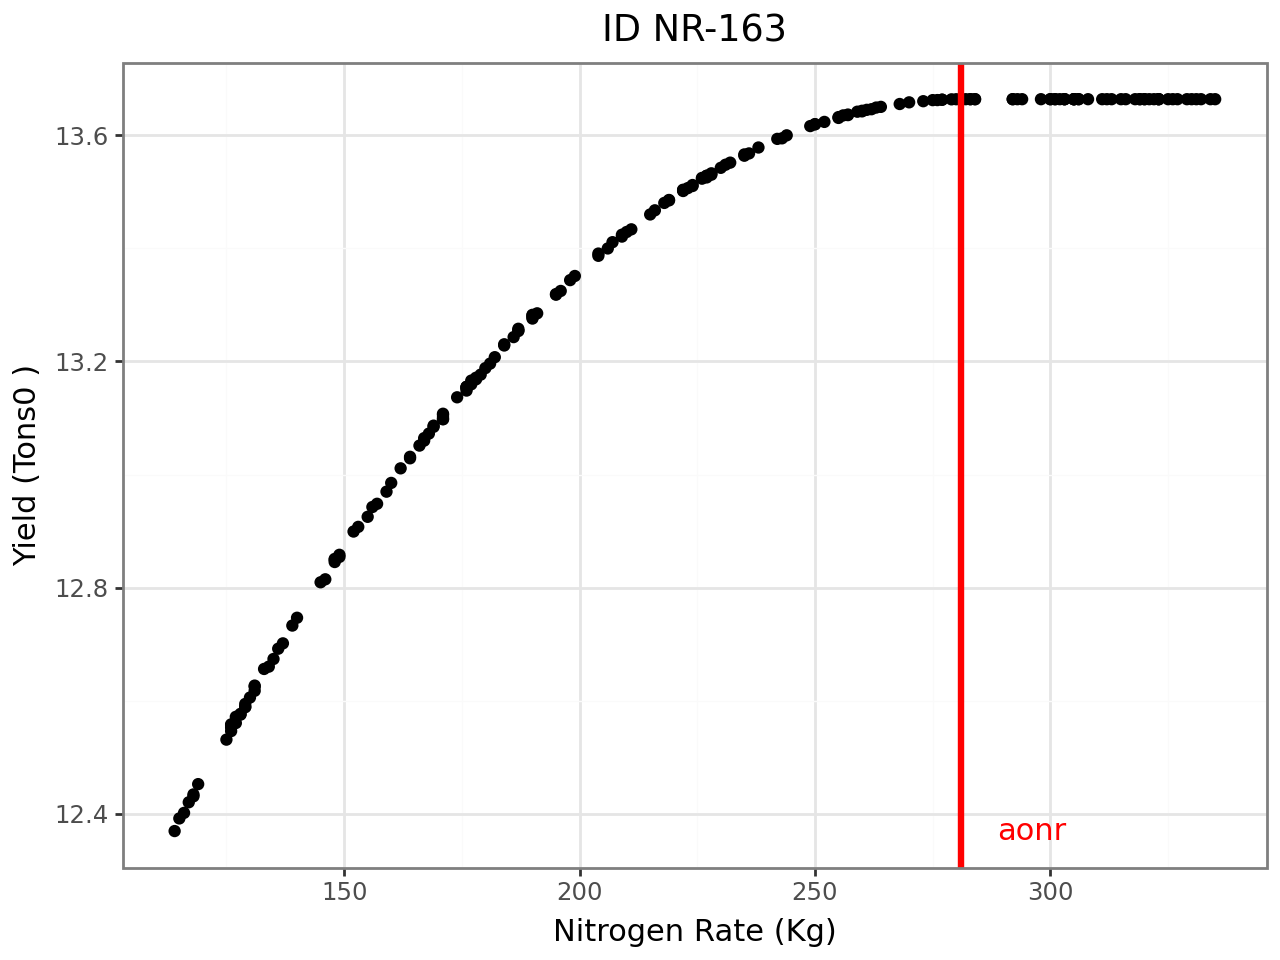

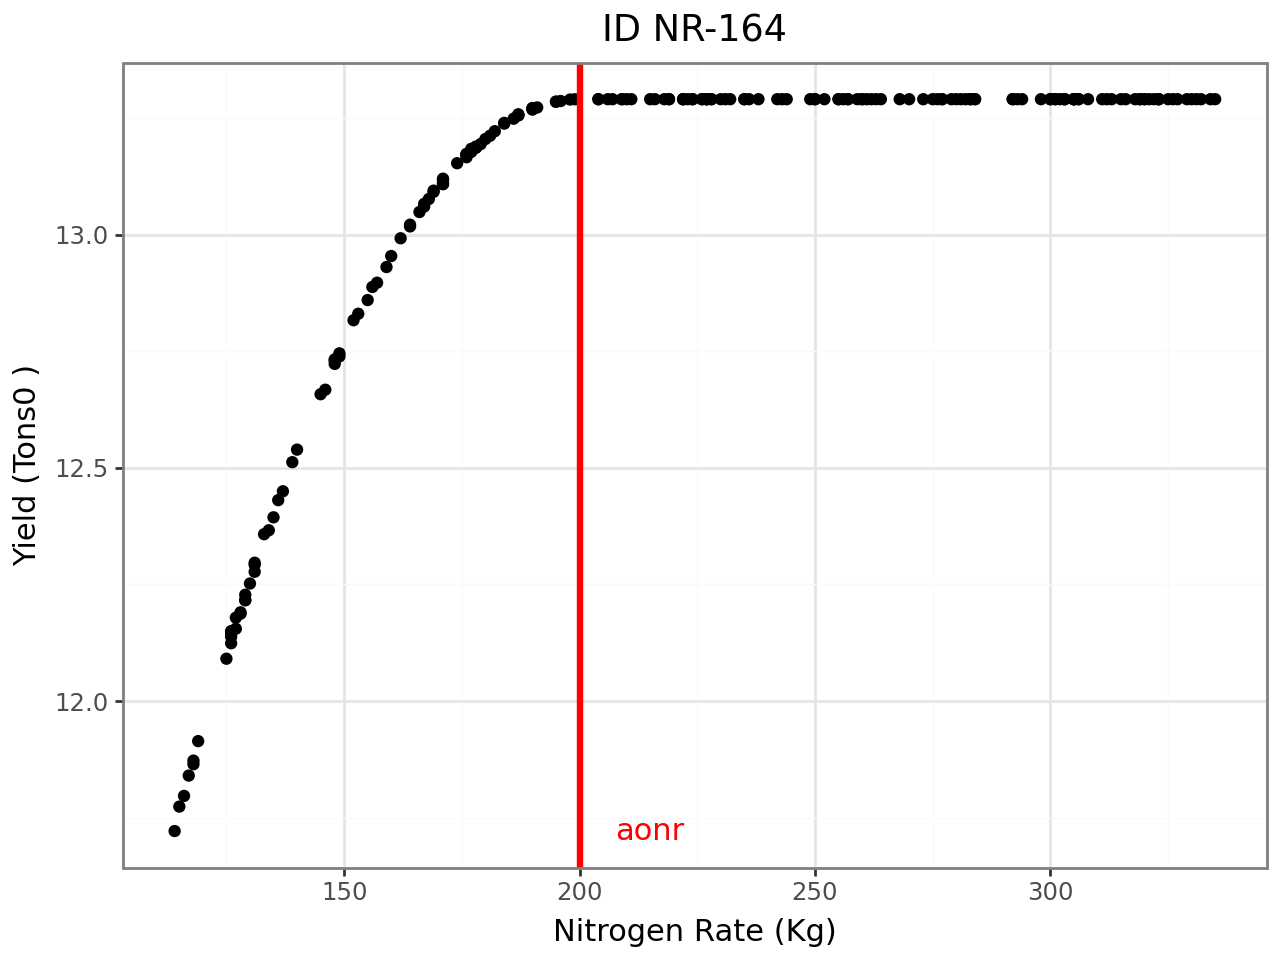

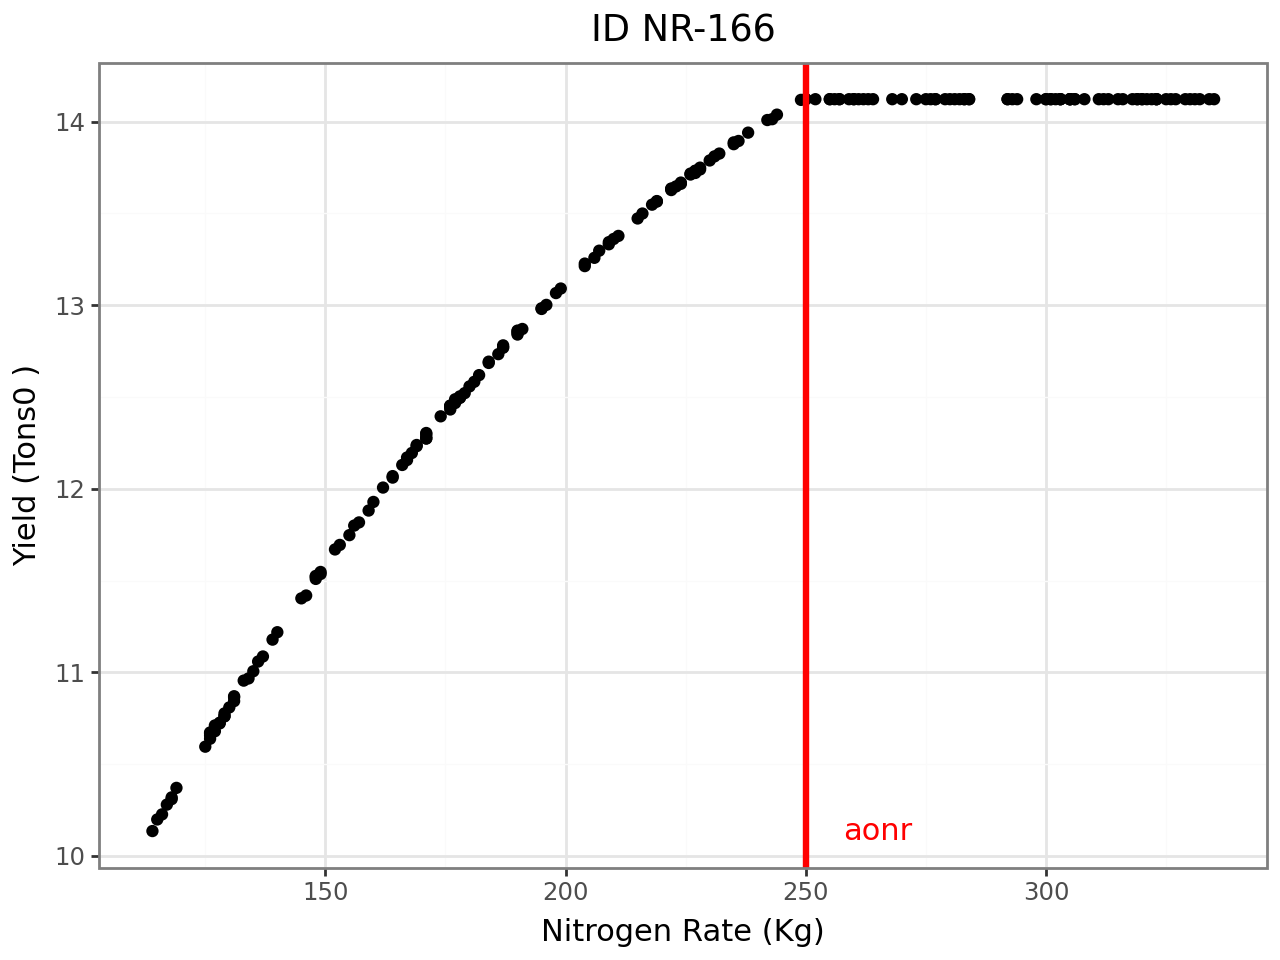

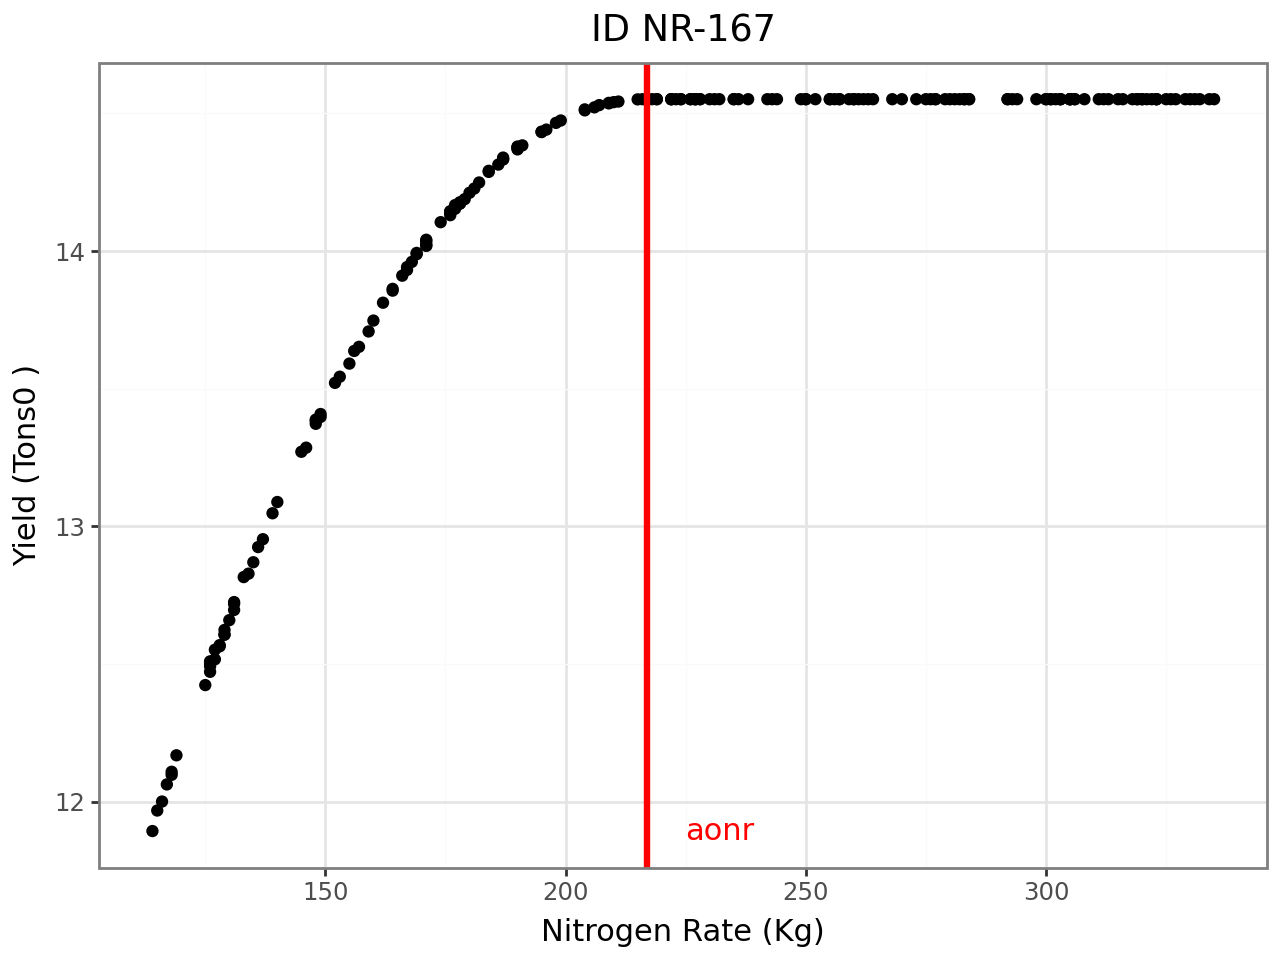

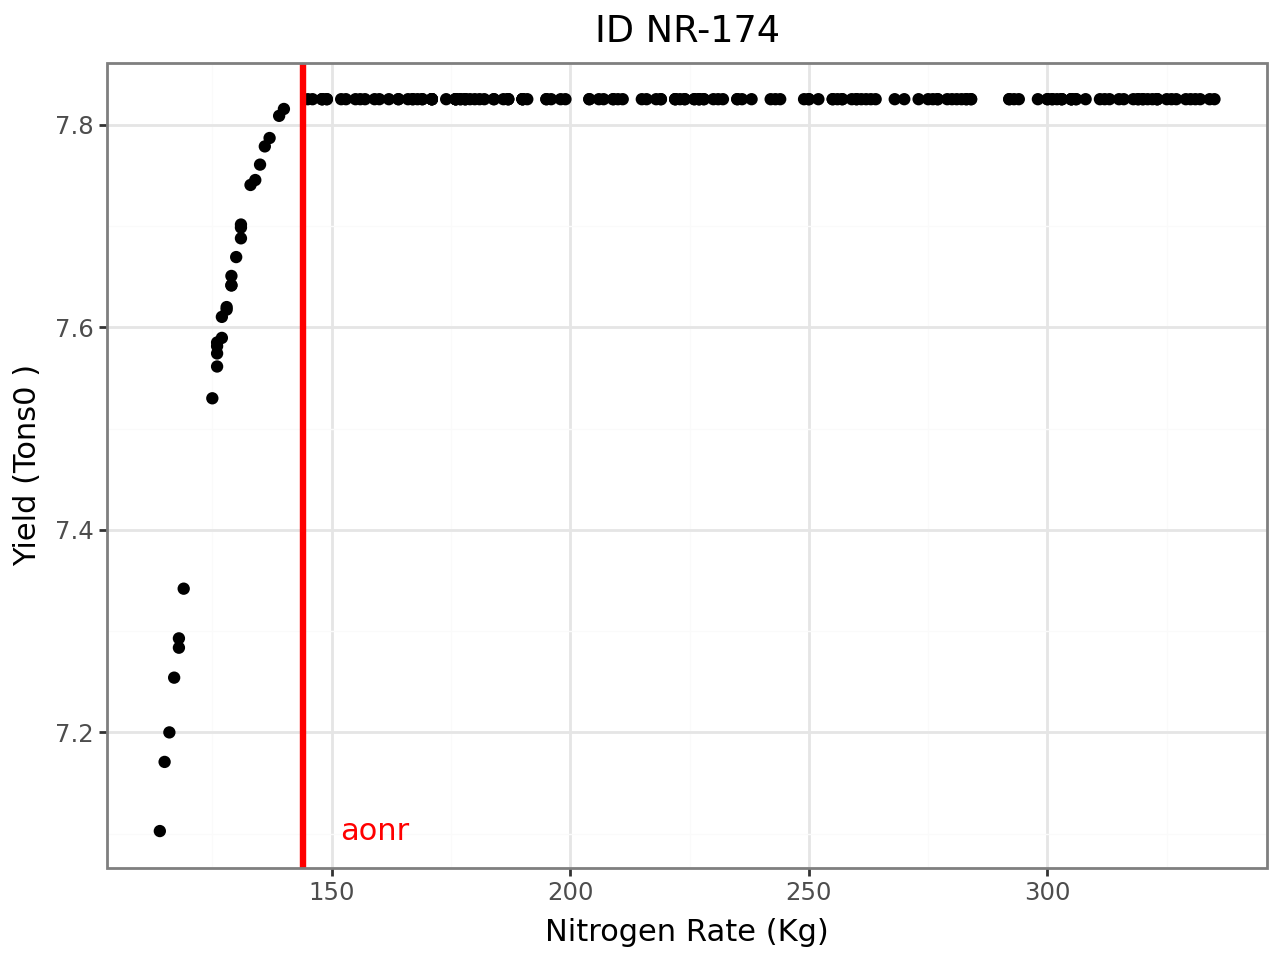

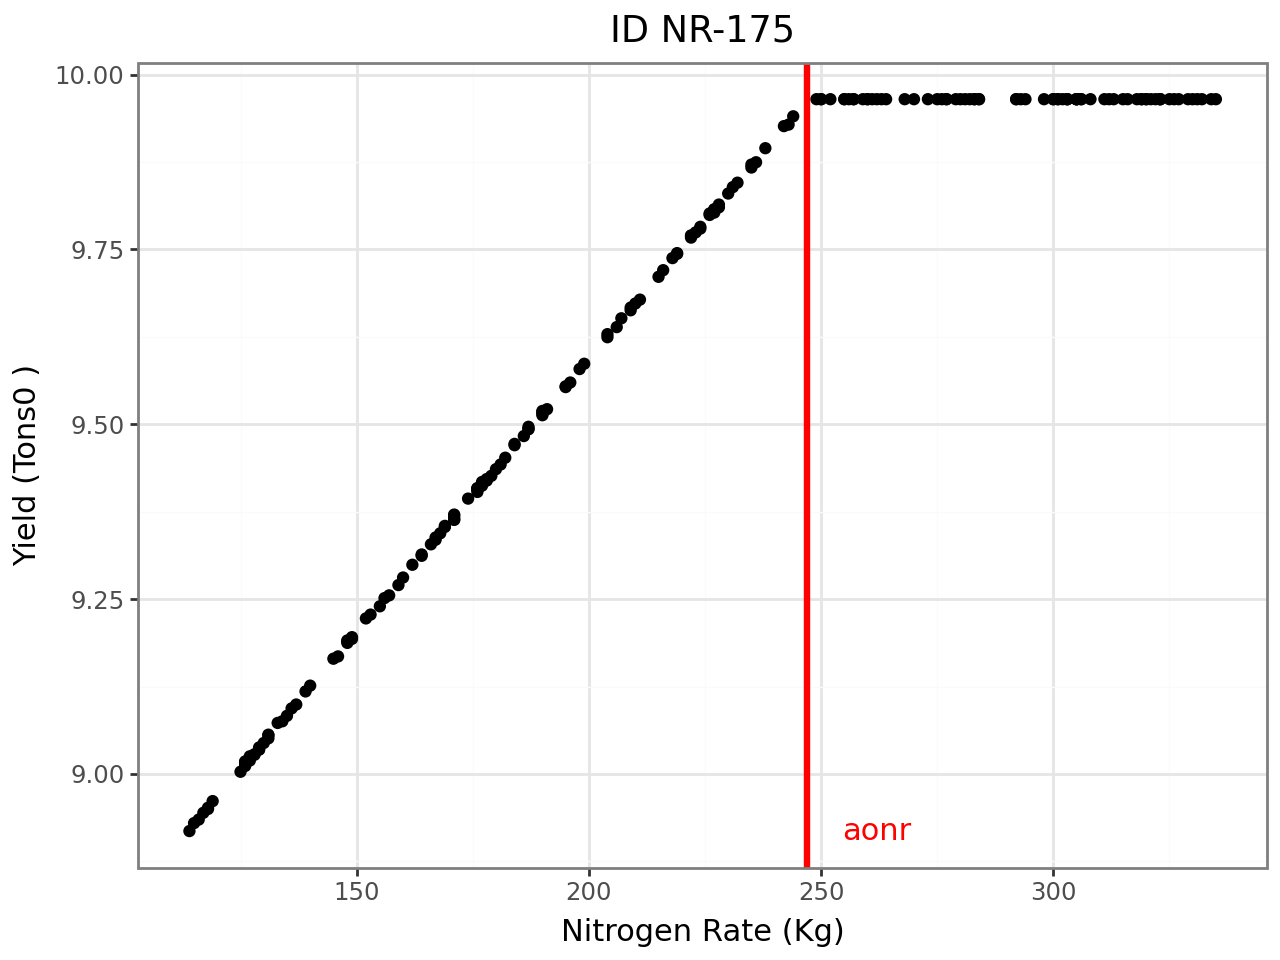

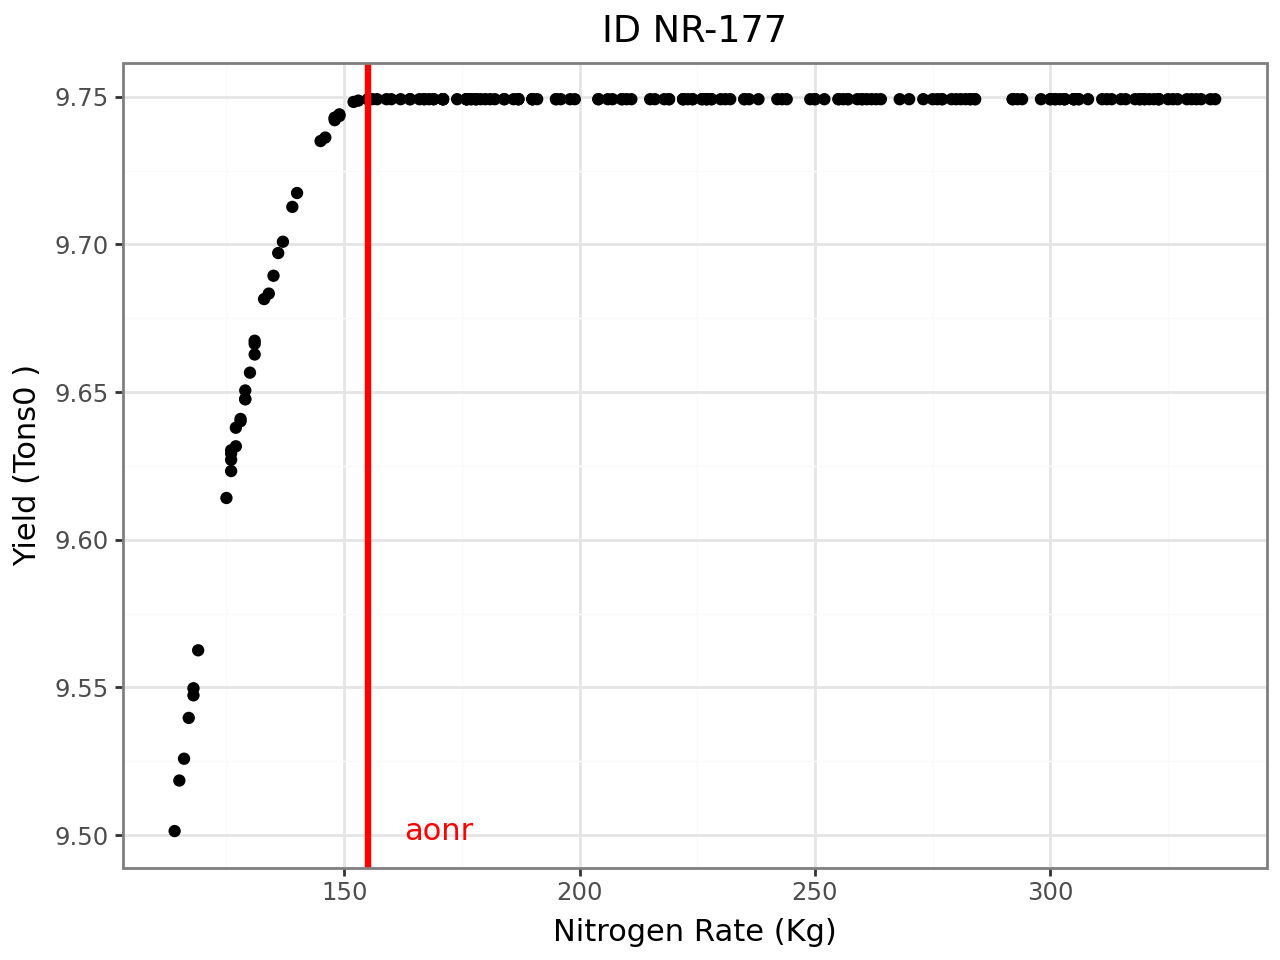

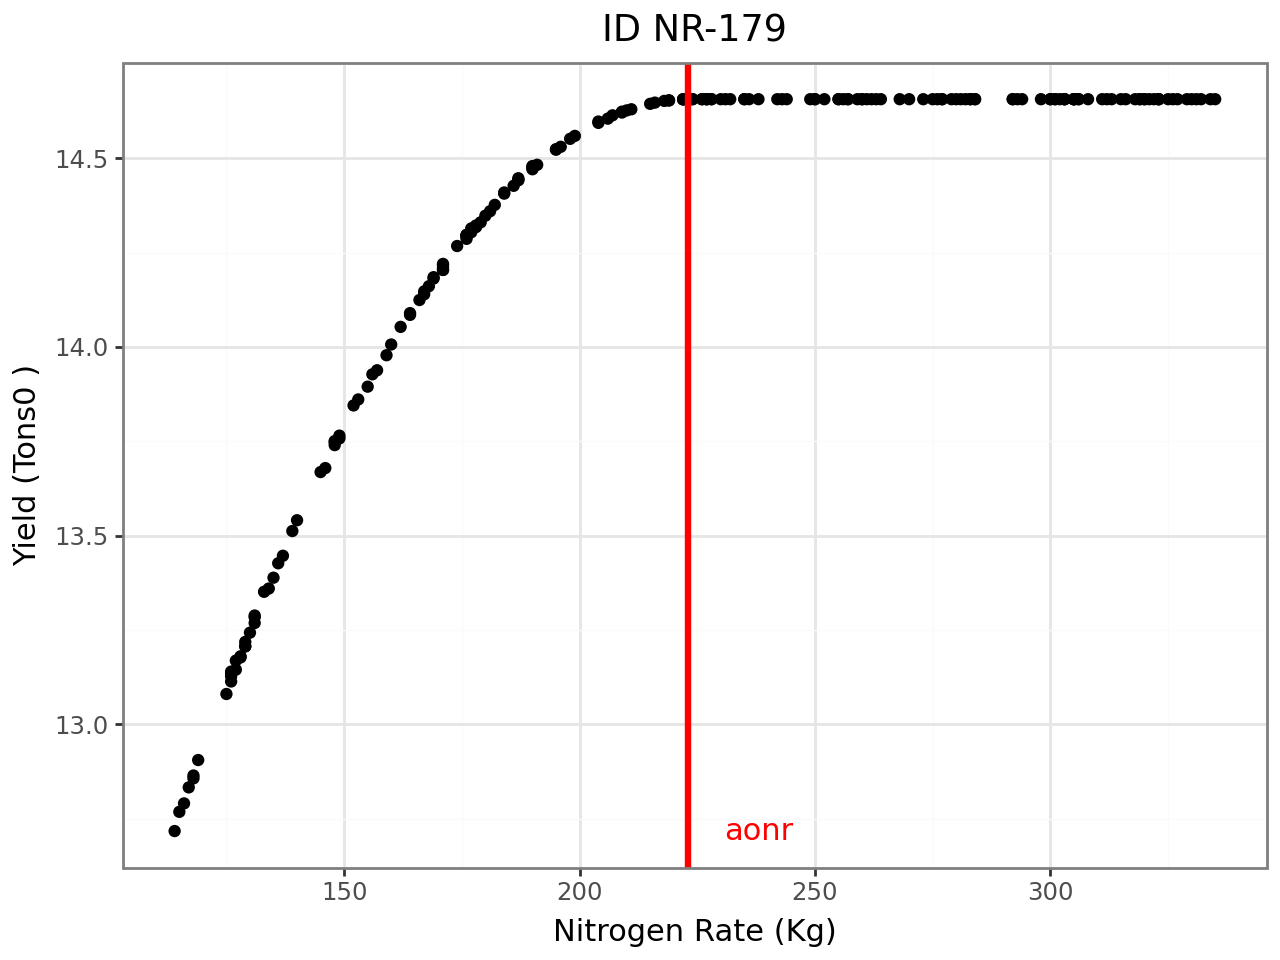

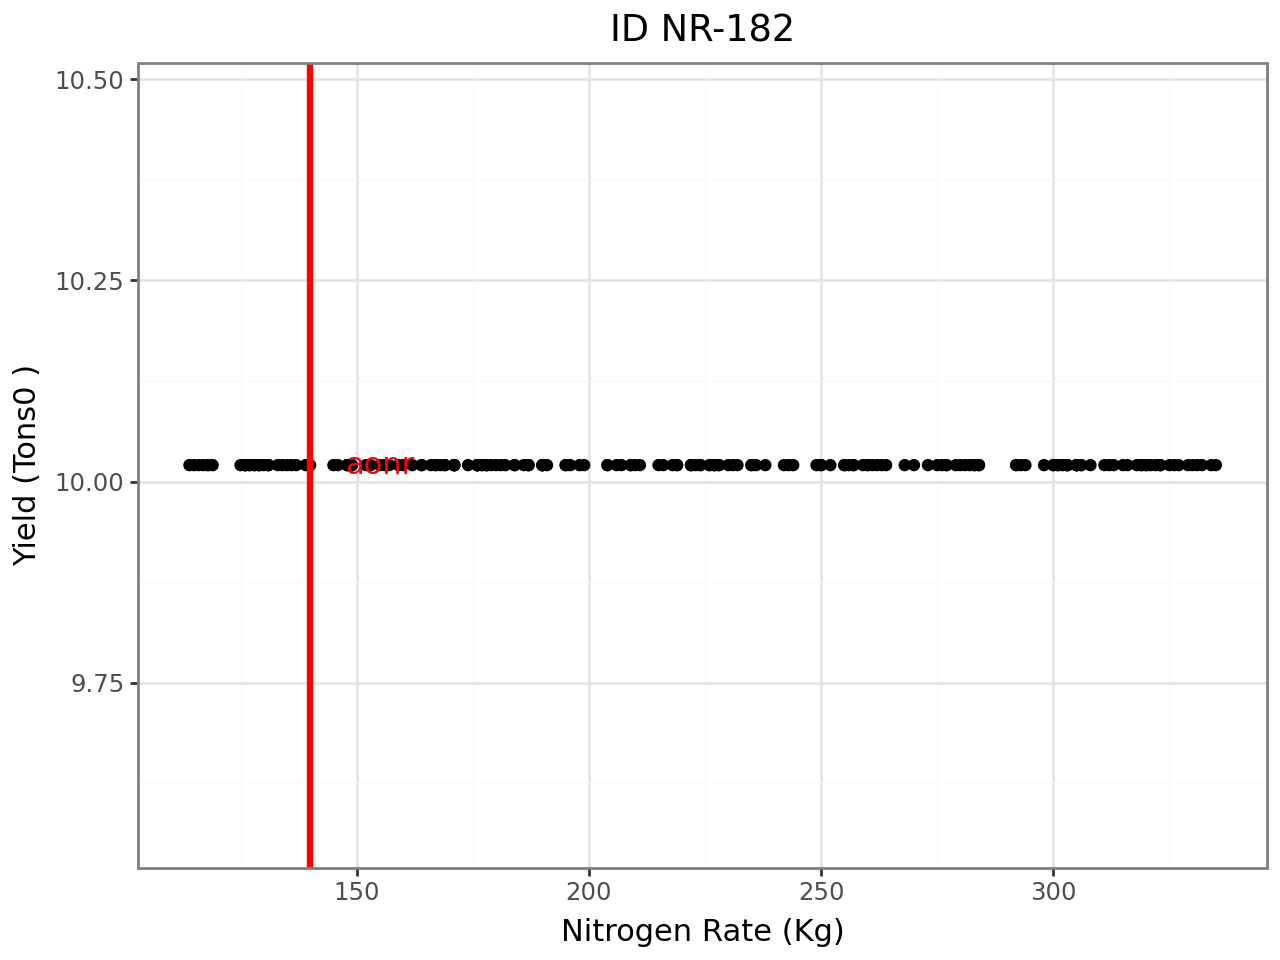

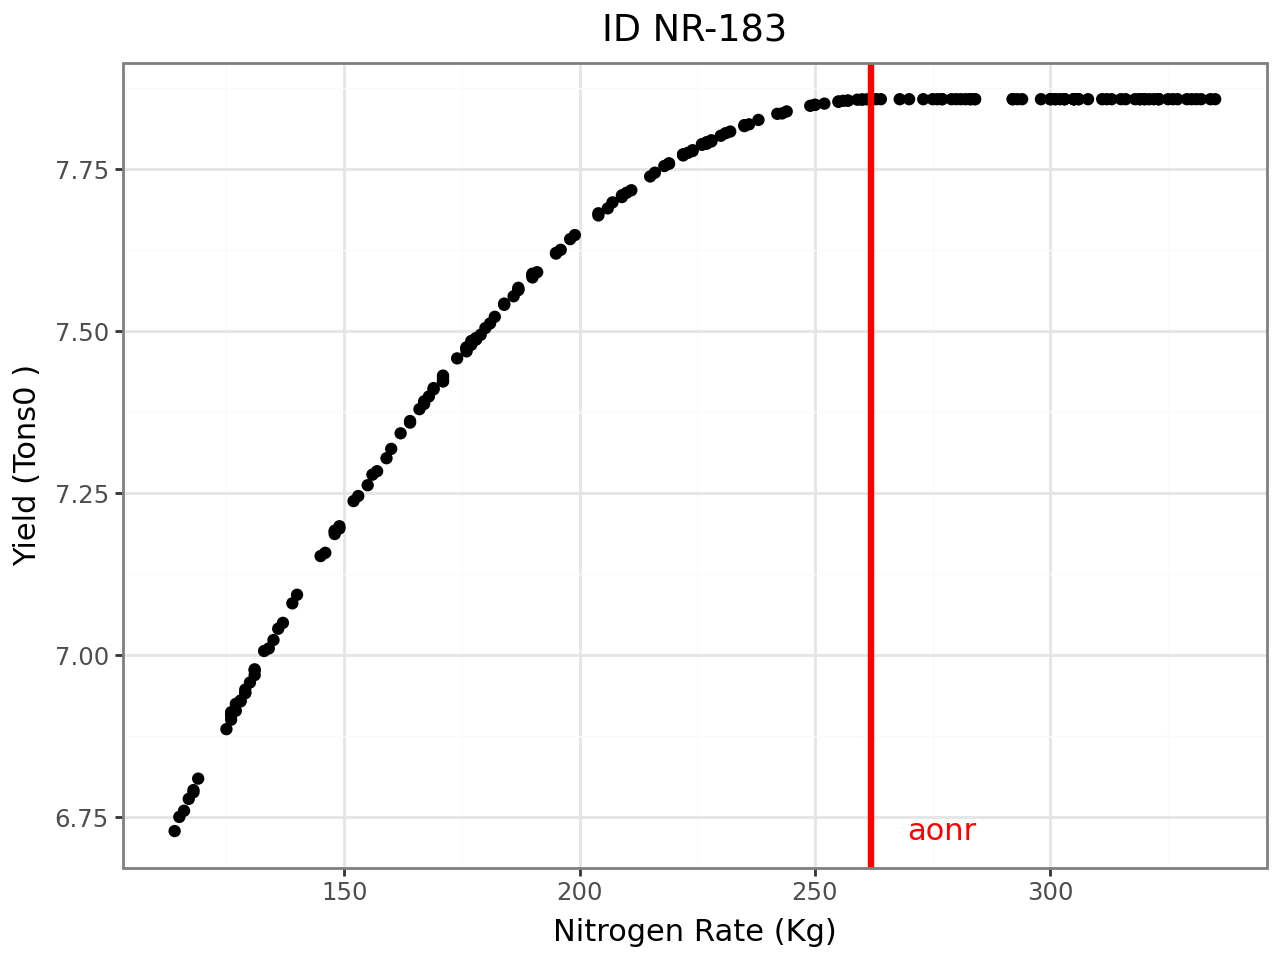

KeyboardInterrupt: 

In [11]:
for trial in new_gtd1['id'].unique():
# for trial in ['NR-047']:
    gtd_trial=new_gtd1[new_gtd1['id']==trial]
    
    min_yield=gtd_trial['yield_ton_ha'].min()
    g = (ggplot(gtd_trial,aes(x='nitro_kg_ha',y='yield_ton_ha'))+
         geom_point()+
         geom_vline(xintercept=gtd_trial['aonr_kg_ha'].median(),size=1.3,color='red')+
         annotate("text", x=gtd_trial['aonr_kg_ha'].mean()+15, y=min_yield, label= "aonr",color='red') + 
         labs(title=f'ID {gtd_trial.id.iloc[0]}',
              x='Nitrogen Rate (Kg)',
              y='Yield (Tons0 )')+
         theme_bw())
    display(g)

In [ ]:
##############################################################################################################################
#                              NRCS_N_project_Indiana_dataset_2025.04.17_CSV.xlsx                                             #
###############################################################################################################################

gtd2 = pd.read_excel('/usr/local/shared/indiana_nitrogen_initiative/nrcs_onfarm_project_2021_2023/NRCS_N_project_Indiana_dataset_2025.04.17_CSV.xlsx',sheet_name='Data',header=3, names=['state','county','year','field','field_name','id','grid_id','grid_org','transects_n','transect_id','transect_r','trans_a','trans_b','strategy','pnm','fp','damage','area_ac','plot_id','trt_n','tratment','ref_block','rep_refb','pt_npass','sd_npass','hybrid','tile','pre_crop','tillage','fnr_lbac','r_exn_lbac','r_stn_lbac','p_pren_lbac','r_pren_lbac','p_sidn_lbac','sidn_lbac','r_sdn_lbac','p_totn_lbac','rtn_lbac','rtotn_kgha','ryl15_buac','ry15_mtha'])
# Filtering rows
gtd2=gtd2[gtd2['pre_crop']=='Soybean']

# Selecting Columns 
gtd2_filtered=gtd2[['year','id','rtotn_kgha','ry15_mtha','county','year']]

# Here I just rounded the decimals and then I grouped by nrate to avoid repeated nrates
gtd2_filtered['rtotn_kgha'] = gtd2_filtered['rtotn_kgha'].div(10).astype('int')*10
gtd2_ind_trials = gtd2_filtered.groupby(['rtotn_kgha','id'],as_index=False)['ry15_mtha'].mean()

# Selecting the best curve that fit each field
def fitting_curves(group):

    quad = fit_quadratic_plateau(group, 'ry15_mtha', "rtotn_kgha")
    lin = fit_linear_plateau(group, 'ry15_mtha', "rtotn_kgha")

    is_quad = quad['r2'] > lin['r2']
    best = quad if is_quad else lin
    
    return pd.Series({
        'a': best['b0'],
        'b': best['b1'],
        'c': quad['b2'] if is_quad else np.nan,
        'x_break': best['x_break'],
        'model_type': 'quad' if is_quad else 'lin'
    })
    
trial_results = gtd2_ind_trials.groupby('id').apply(fitting_curves, include_groups=True).reset_index()
max_rates = gtd2_ind_trials.groupby('id')['rtotn_kgha'].max().rename('max_rate')
trial_results = trial_results.merge(max_rates, on='id')




# Getting yield for each rate
gtd2_curves = (
    trial_results
    .assign(key=1)
    .merge(
        pd.DataFrame({'rate': nitro_gtd2, 'key': 1}),
        on='key'
    )
    .drop(columns='key')
)

a = gtd2_curves['a'].astype(float)
b = gtd2_curves['b'].astype(float)
c = gtd2_curves['c'].abs()
r = gtd2_curves['rate'].astype(float)

# Capped to max. N rate in trial
gtd2_curves['effective_r'] = gtd2_curves[['rate', 'max_rate', 'x_break']].min(axis=1)


lin_val  = a + (b * gtd2_curves['effective_r'])
quad_val = a + (b * gtd2_curves['effective_r']) - (c * gtd2_curves['effective_r']**2)

gtd2_curves['yield_ton'] = np.where(c.isna(), lin_val, quad_val)


years=gtd2.groupby('id',as_index=True)['year'].mean()+2000
county=gtd2.groupby('id',as_index=True)['county'].first()
gtd2_curves['years']=gtd2_curves['id'].map(years)
gtd2_curves['county']=gtd2_curves['id'].map(county)
gtd2_curves['county']=gtd2_curves['county'].map(county_map)

gtd2_curves["region"] = gtd2_curves["county"].map(region3_map)

gtd2_curves['aonr']=np.minimum(gtd2_curves['x_break'],gtd2_curves['max_rate']).astype(int)
gtd2_curves['yield_ton']=np.where(gtd2_curves['yield_ton']<0,0,gtd2_curves['yield_ton'])
gtd2_curves['rate']=gtd2_curves['rate'].astype(int)
gtd2_curves['dbase'] = 'GTD2'

new_gtd2=gtd2_curves[['id','rate','yield_ton','years','county','region','aonr','dbase']]

new_gtd2.columns=['id','nitro_kg_ha','yield_ton_ha','year','county','region','aonr_kg_ha','dbase']


In [ ]:
for trial in new_gtd2['id'].unique():
# for trial in ['NR-047']:
    gtd_trial=new_gtd2[new_gtd2['id']==trial]
    
    min_yield=gtd_trial['yield_ton_ha'].min()
    g = (ggplot(gtd_trial,aes(x='nitro_kg_ha',y='yield_ton_ha'))+
         geom_point()+
         geom_vline(xintercept=gtd_trial['aonr_kg_ha'].median(),size=1.3,color='red')+
         annotate("text", x=gtd_trial['aonr_kg_ha'].mean()+15, y=min_yield, label= "aonr",color='red') + 
         labs(title=f'ID {gtd_trial.id.iloc[0]}',
              x='Nitrogen Rate (kg)',
              y='Yield (Tons)')+
         theme_bw())
    display(g)